In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import dataloader
from torch.nn.modules import activation
from torch.utils.data import Dataset, DataLoader

In [2]:
# Using GPU or CPU
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if cuda:
    print(f'gpu count: {torch.cuda.device_count()}')

# Data Load
train_imgs = np.load('../comp0090/fashion-train-imgs.npz')  #(28, 28, 12000)
train_label = np.load('../comp0090/fashion-train-labels.npz') #(12000, )
dev_imgs = np.load('../comp0090/fashion-dev-imgs.npz')     #(28, 28, 1000)
dev_label = np.load('../comp0090/fashion-dev-labels.npz')  #(1000, )
test_imgs = np.load('../comp0090/fashion-test-imgs.npz')   #(28, 28, 1000)
test_label = np.load('../comp0090/fashion-test-labels.npz') #(1000, )

gpu count: 1


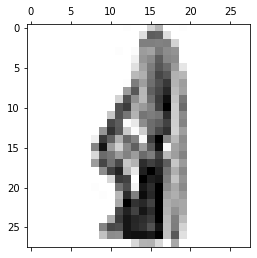

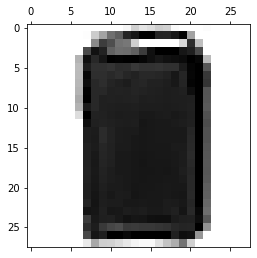

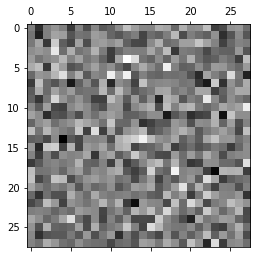

In [3]:
# Move axis for computing the matrix
train_imgs = np.moveaxis(train_imgs, -1, 0)   # (28, 28, 12000) -> (12000, 28, 28)
plt.matshow(train_imgs[1], cmap = matplotlib.cm.binary)

dev_imgs = np.moveaxis(dev_imgs, -1, 0)       # (28, 28, 1000) -> (1000, 28, 28)
plt.matshow(dev_imgs[1], cmap = matplotlib.cm.binary)

test_imgs = np.moveaxis(test_imgs, -1, 0)     # (28, 28, 1000)  -> (1000, 28, 28)
plt.matshow(test_imgs[1], cmap = matplotlib.cm.binary)

In [4]:
batch_size = 64 #train_imgs.shape[0]

# Dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        X = torch.as_tensor(self.X[idx], dtype = torch.float32)
        y = torch.as_tensor(self.y[idx], dtype = torch.long)
        return X, y

    def __len__(self):
        return(len(self.X))

train_dataset = MyDataset(train_imgs, train_label)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

dev_dataset = MyDataset(dev_imgs, dev_label)
dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False) 

test_dataset = MyDataset(test_imgs, test_label)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [5]:
# Modeling a multi-layer perceptron (Deep Neural Network)
class DNN(nn.Module):
    def __init__(self, n_input, n_hidden_list, activation_list):
        super(DNN, self).__init__()
        if type(activation_list) is not list:
            activation_list = [activation_list] * len[n_hidden_list]

        layers = [nn.Linear(n_input, n_hidden_list[0], activation_list[0])]
        for i in range(len(n_hidden_list) - 1):
            layers.extend([nn.Linear(n_hidden_list[i], n_hidden_list[i + 1]), activation_list[i + 1]])

        self.fc = nn.Sequential(*layers)

    def forward(self, X):
        X = X.reshape(len(X), -1) # Flatten
        return self.fc(X)

# Cross-entropy Loss function
criterion = nn.CrossEntropyLoss()

In [6]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.average = 0
        self.sum = 0
        self.count = 0

    def step(self, value, n = 1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [13]:
# Hyperparameter
n_epoch = 200
lr = 0.001
batch_size = 64 #train_imgs.shape[0]
n_input = 28 * 28
n_hidden_state = [2] # layer_size
activation_list = [nn.Sigmoid()]*1
model = DNN(n_input, n_hidden_state, activation_list)
# model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training set
train_loss_list = []   # Loss over each epoch
dev_loss_list = []
train_loss_meter = AverageMeter()  # Loss of single epoch
dev_loss_meter = AverageMeter()

for epoch in range(1, n_epoch + 1):
    train_loss_meter.reset()
    dev_loss_meter.reset()
    for i, (X, y) in enumerate(train_dataloader):
        y_hat1 = model(X)
        loss = criterion(y_hat1, y)
        optimizer.zero_grad()   # Remove the gradient history
        loss.backward()     # Differentiation
        optimizer.step()   # Apply
        train_loss_meter.step(loss.item())
        

        print('[Epoch: %s / %s] [Batch: %s / %s] Loss is: %.7f (% .7f)' % (epoch, n_epoch, i, len(train_dataloader) - 1, loss.item(), train_loss_meter.average))
    
    train_loss_list.append(train_loss_meter.average)

    # Validation on every epoch
    with torch.no_grad():
        for X, y in dev_dataloader:
            y_hat2 = model(X)
            loss = criterion(y_hat2, y)
            dev_loss_meter.step(loss.item())

    print('Validation Loss is: % .5f' %(dev_loss_meter.average))
    dev_loss_list.append(dev_loss_meter.average)

[Epoch: 1 / 200] [Batch: 0 / 187] Loss is: 0.6863361 ( 0.6863361)
[Epoch: 1 / 200] [Batch: 1 / 187] Loss is: 0.6678631 ( 0.6770996)
[Epoch: 1 / 200] [Batch: 2 / 187] Loss is: 0.6141188 ( 0.6561060)
[Epoch: 1 / 200] [Batch: 3 / 187] Loss is: 0.6106376 ( 0.6447389)
[Epoch: 1 / 200] [Batch: 4 / 187] Loss is: 0.5220070 ( 0.6201925)
[Epoch: 1 / 200] [Batch: 5 / 187] Loss is: 0.5474494 ( 0.6080687)
[Epoch: 1 / 200] [Batch: 6 / 187] Loss is: 0.5212323 ( 0.5956635)
[Epoch: 1 / 200] [Batch: 7 / 187] Loss is: 0.5459027 ( 0.5894434)
[Epoch: 1 / 200] [Batch: 8 / 187] Loss is: 0.4420012 ( 0.5730609)
[Epoch: 1 / 200] [Batch: 9 / 187] Loss is: 0.4574695 ( 0.5615018)
[Epoch: 1 / 200] [Batch: 10 / 187] Loss is: 0.5014190 ( 0.5560397)
[Epoch: 1 / 200] [Batch: 11 / 187] Loss is: 0.4394748 ( 0.5463260)
[Epoch: 1 / 200] [Batch: 12 / 187] Loss is: 0.4067041 ( 0.5355858)
[Epoch: 1 / 200] [Batch: 13 / 187] Loss is: 0.4723948 ( 0.5310722)
[Epoch: 1 / 200] [Batch: 14 / 187] Loss is: 0.4445013 ( 0.5253008)
[Epoc

[Epoch: 2 / 200] [Batch: 21 / 187] Loss is: 0.1093396 ( 0.1450601)
[Epoch: 2 / 200] [Batch: 22 / 187] Loss is: 0.1106529 ( 0.1435641)
[Epoch: 2 / 200] [Batch: 23 / 187] Loss is: 0.2172004 ( 0.1466323)
[Epoch: 2 / 200] [Batch: 24 / 187] Loss is: 0.1675565 ( 0.1474693)
[Epoch: 2 / 200] [Batch: 25 / 187] Loss is: 0.1189691 ( 0.1463731)
[Epoch: 2 / 200] [Batch: 26 / 187] Loss is: 0.1432534 ( 0.1462576)
[Epoch: 2 / 200] [Batch: 27 / 187] Loss is: 0.1085562 ( 0.1449111)
[Epoch: 2 / 200] [Batch: 28 / 187] Loss is: 0.2136461 ( 0.1472813)
[Epoch: 2 / 200] [Batch: 29 / 187] Loss is: 0.1584813 ( 0.1476546)
[Epoch: 2 / 200] [Batch: 30 / 187] Loss is: 0.1135232 ( 0.1465536)
[Epoch: 2 / 200] [Batch: 31 / 187] Loss is: 0.1373128 ( 0.1462648)
[Epoch: 2 / 200] [Batch: 32 / 187] Loss is: 0.0936049 ( 0.1446691)
[Epoch: 2 / 200] [Batch: 33 / 187] Loss is: 0.1065337 ( 0.1435474)
[Epoch: 2 / 200] [Batch: 34 / 187] Loss is: 0.1052182 ( 0.1424523)
[Epoch: 2 / 200] [Batch: 35 / 187] Loss is: 0.0990165 ( 0.1412

[Epoch: 3 / 200] [Batch: 52 / 187] Loss is: 0.0924891 ( 0.1336766)
[Epoch: 3 / 200] [Batch: 53 / 187] Loss is: 0.1788030 ( 0.1345123)
[Epoch: 3 / 200] [Batch: 54 / 187] Loss is: 0.0832042 ( 0.1335794)
[Epoch: 3 / 200] [Batch: 55 / 187] Loss is: 0.0905074 ( 0.1328103)
[Epoch: 3 / 200] [Batch: 56 / 187] Loss is: 0.0942133 ( 0.1321331)
[Epoch: 3 / 200] [Batch: 57 / 187] Loss is: 0.1248259 ( 0.1320072)
[Epoch: 3 / 200] [Batch: 58 / 187] Loss is: 0.0453226 ( 0.1305379)
[Epoch: 3 / 200] [Batch: 59 / 187] Loss is: 0.1309951 ( 0.1305456)
[Epoch: 3 / 200] [Batch: 60 / 187] Loss is: 0.0494524 ( 0.1292162)
[Epoch: 3 / 200] [Batch: 61 / 187] Loss is: 0.1158166 ( 0.1290000)
[Epoch: 3 / 200] [Batch: 62 / 187] Loss is: 0.1114288 ( 0.1287211)
[Epoch: 3 / 200] [Batch: 63 / 187] Loss is: 0.2002531 ( 0.1298388)
[Epoch: 3 / 200] [Batch: 64 / 187] Loss is: 0.1261352 ( 0.1297818)
[Epoch: 3 / 200] [Batch: 65 / 187] Loss is: 0.1074971 ( 0.1294442)
[Epoch: 3 / 200] [Batch: 66 / 187] Loss is: 0.0878045 ( 0.1288

[Epoch: 4 / 200] [Batch: 89 / 187] Loss is: 0.0933721 ( 0.1217220)
[Epoch: 4 / 200] [Batch: 90 / 187] Loss is: 0.1237698 ( 0.1217445)
[Epoch: 4 / 200] [Batch: 91 / 187] Loss is: 0.1399210 ( 0.1219421)
[Epoch: 4 / 200] [Batch: 92 / 187] Loss is: 0.2966570 ( 0.1238207)
[Epoch: 4 / 200] [Batch: 93 / 187] Loss is: 0.1062943 ( 0.1236343)
[Epoch: 4 / 200] [Batch: 94 / 187] Loss is: 0.0647512 ( 0.1230145)
[Epoch: 4 / 200] [Batch: 95 / 187] Loss is: 0.1026093 ( 0.1228019)
[Epoch: 4 / 200] [Batch: 96 / 187] Loss is: 0.0499126 ( 0.1220505)
[Epoch: 4 / 200] [Batch: 97 / 187] Loss is: 0.0813170 ( 0.1216348)
[Epoch: 4 / 200] [Batch: 98 / 187] Loss is: 0.1091425 ( 0.1215086)
[Epoch: 4 / 200] [Batch: 99 / 187] Loss is: 0.1872909 ( 0.1221665)
[Epoch: 4 / 200] [Batch: 100 / 187] Loss is: 0.2156558 ( 0.1230921)
[Epoch: 4 / 200] [Batch: 101 / 187] Loss is: 0.1504944 ( 0.1233607)
[Epoch: 4 / 200] [Batch: 102 / 187] Loss is: 0.1271010 ( 0.1233971)
[Epoch: 4 / 200] [Batch: 103 / 187] Loss is: 0.0631085 ( 0.

[Epoch: 5 / 200] [Batch: 111 / 187] Loss is: 0.0996523 ( 0.1128204)
[Epoch: 5 / 200] [Batch: 112 / 187] Loss is: 0.1357679 ( 0.1130235)
[Epoch: 5 / 200] [Batch: 113 / 187] Loss is: 0.1768610 ( 0.1135834)
[Epoch: 5 / 200] [Batch: 114 / 187] Loss is: 0.1931015 ( 0.1142749)
[Epoch: 5 / 200] [Batch: 115 / 187] Loss is: 0.0814532 ( 0.1139920)
[Epoch: 5 / 200] [Batch: 116 / 187] Loss is: 0.0569918 ( 0.1135048)
[Epoch: 5 / 200] [Batch: 117 / 187] Loss is: 0.3581931 ( 0.1155784)
[Epoch: 5 / 200] [Batch: 118 / 187] Loss is: 0.1195445 ( 0.1156117)
[Epoch: 5 / 200] [Batch: 119 / 187] Loss is: 0.2028724 ( 0.1163389)
[Epoch: 5 / 200] [Batch: 120 / 187] Loss is: 0.1239822 ( 0.1164021)
[Epoch: 5 / 200] [Batch: 121 / 187] Loss is: 0.0826258 ( 0.1161252)
[Epoch: 5 / 200] [Batch: 122 / 187] Loss is: 0.0679919 ( 0.1157339)
[Epoch: 5 / 200] [Batch: 123 / 187] Loss is: 0.0751792 ( 0.1154068)
[Epoch: 5 / 200] [Batch: 124 / 187] Loss is: 0.0788534 ( 0.1151144)
[Epoch: 5 / 200] [Batch: 125 / 187] Loss is: 0.0

[Epoch: 6 / 200] [Batch: 119 / 187] Loss is: 0.2103764 ( 0.1110393)
[Epoch: 6 / 200] [Batch: 120 / 187] Loss is: 0.0848093 ( 0.1108226)
[Epoch: 6 / 200] [Batch: 121 / 187] Loss is: 0.1782634 ( 0.1113754)
[Epoch: 6 / 200] [Batch: 122 / 187] Loss is: 0.0790138 ( 0.1111123)
[Epoch: 6 / 200] [Batch: 123 / 187] Loss is: 0.0683937 ( 0.1107678)
[Epoch: 6 / 200] [Batch: 124 / 187] Loss is: 0.0775382 ( 0.1105019)
[Epoch: 6 / 200] [Batch: 125 / 187] Loss is: 0.1240154 ( 0.1106092)
[Epoch: 6 / 200] [Batch: 126 / 187] Loss is: 0.0645070 ( 0.1102462)
[Epoch: 6 / 200] [Batch: 127 / 187] Loss is: 0.0382671 ( 0.1096838)
[Epoch: 6 / 200] [Batch: 128 / 187] Loss is: 0.1592026 ( 0.1100677)
[Epoch: 6 / 200] [Batch: 129 / 187] Loss is: 0.0737417 ( 0.1097883)
[Epoch: 6 / 200] [Batch: 130 / 187] Loss is: 0.1291292 ( 0.1099359)
[Epoch: 6 / 200] [Batch: 131 / 187] Loss is: 0.0973378 ( 0.1098405)
[Epoch: 6 / 200] [Batch: 132 / 187] Loss is: 0.1020834 ( 0.1097821)
[Epoch: 6 / 200] [Batch: 133 / 187] Loss is: 0.2

[Epoch: 7 / 200] [Batch: 57 / 187] Loss is: 0.0769336 ( 0.1054943)
[Epoch: 7 / 200] [Batch: 58 / 187] Loss is: 0.0456637 ( 0.1044802)
[Epoch: 7 / 200] [Batch: 59 / 187] Loss is: 0.0842320 ( 0.1041427)
[Epoch: 7 / 200] [Batch: 60 / 187] Loss is: 0.0338983 ( 0.1029912)
[Epoch: 7 / 200] [Batch: 61 / 187] Loss is: 0.0629259 ( 0.1023450)
[Epoch: 7 / 200] [Batch: 62 / 187] Loss is: 0.0486988 ( 0.1014934)
[Epoch: 7 / 200] [Batch: 63 / 187] Loss is: 0.0742533 ( 0.1010678)
[Epoch: 7 / 200] [Batch: 64 / 187] Loss is: 0.0742028 ( 0.1006545)
[Epoch: 7 / 200] [Batch: 65 / 187] Loss is: 0.1951670 ( 0.1020865)
[Epoch: 7 / 200] [Batch: 66 / 187] Loss is: 0.0731228 ( 0.1016542)
[Epoch: 7 / 200] [Batch: 67 / 187] Loss is: 0.1101645 ( 0.1017794)
[Epoch: 7 / 200] [Batch: 68 / 187] Loss is: 0.0447935 ( 0.1009535)
[Epoch: 7 / 200] [Batch: 69 / 187] Loss is: 0.0781456 ( 0.1006277)
[Epoch: 7 / 200] [Batch: 70 / 187] Loss is: 0.2824541 ( 0.1031886)
[Epoch: 7 / 200] [Batch: 71 / 187] Loss is: 0.0937652 ( 0.1030

[Epoch: 8 / 200] [Batch: 91 / 187] Loss is: 0.1962749 ( 0.1044385)
[Epoch: 8 / 200] [Batch: 92 / 187] Loss is: 0.0454665 ( 0.1038044)
[Epoch: 8 / 200] [Batch: 93 / 187] Loss is: 0.0825034 ( 0.1035778)
[Epoch: 8 / 200] [Batch: 94 / 187] Loss is: 0.0836244 ( 0.1033678)
[Epoch: 8 / 200] [Batch: 95 / 187] Loss is: 0.0946033 ( 0.1032765)
[Epoch: 8 / 200] [Batch: 96 / 187] Loss is: 0.1077470 ( 0.1033226)
[Epoch: 8 / 200] [Batch: 97 / 187] Loss is: 0.0676125 ( 0.1029582)
[Epoch: 8 / 200] [Batch: 98 / 187] Loss is: 0.1053596 ( 0.1029825)
[Epoch: 8 / 200] [Batch: 99 / 187] Loss is: 0.1136664 ( 0.1030893)
[Epoch: 8 / 200] [Batch: 100 / 187] Loss is: 0.0561927 ( 0.1026250)
[Epoch: 8 / 200] [Batch: 101 / 187] Loss is: 0.3884264 ( 0.1054269)
[Epoch: 8 / 200] [Batch: 102 / 187] Loss is: 0.0657827 ( 0.1050421)
[Epoch: 8 / 200] [Batch: 103 / 187] Loss is: 0.0547606 ( 0.1045586)
[Epoch: 8 / 200] [Batch: 104 / 187] Loss is: 0.0425574 ( 0.1039681)
[Epoch: 8 / 200] [Batch: 105 / 187] Loss is: 0.1676693 ( 

[Epoch: 9 / 200] [Batch: 130 / 187] Loss is: 0.1303262 ( 0.1004136)
[Epoch: 9 / 200] [Batch: 131 / 187] Loss is: 0.1083204 ( 0.1004735)
[Epoch: 9 / 200] [Batch: 132 / 187] Loss is: 0.2705418 ( 0.1017522)
[Epoch: 9 / 200] [Batch: 133 / 187] Loss is: 0.0650231 ( 0.1014781)
[Epoch: 9 / 200] [Batch: 134 / 187] Loss is: 0.1373878 ( 0.1017441)
[Epoch: 9 / 200] [Batch: 135 / 187] Loss is: 0.0570569 ( 0.1014155)
[Epoch: 9 / 200] [Batch: 136 / 187] Loss is: 0.0427338 ( 0.1009872)
[Epoch: 9 / 200] [Batch: 137 / 187] Loss is: 0.2788198 ( 0.1022758)
[Epoch: 9 / 200] [Batch: 138 / 187] Loss is: 0.0820951 ( 0.1021307)
[Epoch: 9 / 200] [Batch: 139 / 187] Loss is: 0.1529001 ( 0.1024933)
[Epoch: 9 / 200] [Batch: 140 / 187] Loss is: 0.0859096 ( 0.1023757)
[Epoch: 9 / 200] [Batch: 141 / 187] Loss is: 0.1357469 ( 0.1026107)
[Epoch: 9 / 200] [Batch: 142 / 187] Loss is: 0.0600106 ( 0.1023128)
[Epoch: 9 / 200] [Batch: 143 / 187] Loss is: 0.1214375 ( 0.1024456)
[Epoch: 9 / 200] [Batch: 144 / 187] Loss is: 0.1

[Epoch: 10 / 200] [Batch: 167 / 187] Loss is: 0.1277533 ( 0.0970383)
[Epoch: 10 / 200] [Batch: 168 / 187] Loss is: 0.1292180 ( 0.0972287)
[Epoch: 10 / 200] [Batch: 169 / 187] Loss is: 0.0728252 ( 0.0970852)
[Epoch: 10 / 200] [Batch: 170 / 187] Loss is: 0.0469695 ( 0.0967921)
[Epoch: 10 / 200] [Batch: 171 / 187] Loss is: 0.0379395 ( 0.0964499)
[Epoch: 10 / 200] [Batch: 172 / 187] Loss is: 0.1363577 ( 0.0966806)
[Epoch: 10 / 200] [Batch: 173 / 187] Loss is: 0.0671856 ( 0.0965111)
[Epoch: 10 / 200] [Batch: 174 / 187] Loss is: 0.0472111 ( 0.0962294)
[Epoch: 10 / 200] [Batch: 175 / 187] Loss is: 0.0838741 ( 0.0961592)
[Epoch: 10 / 200] [Batch: 176 / 187] Loss is: 0.1140513 ( 0.0962603)
[Epoch: 10 / 200] [Batch: 177 / 187] Loss is: 0.3452976 ( 0.0976594)
[Epoch: 10 / 200] [Batch: 178 / 187] Loss is: 0.0819988 ( 0.0975719)
[Epoch: 10 / 200] [Batch: 179 / 187] Loss is: 0.0980017 ( 0.0975743)
[Epoch: 10 / 200] [Batch: 180 / 187] Loss is: 0.1336807 ( 0.0977737)
[Epoch: 10 / 200] [Batch: 181 / 18

[Epoch: 11 / 200] [Batch: 183 / 187] Loss is: 0.0714585 ( 0.0953358)
[Epoch: 11 / 200] [Batch: 184 / 187] Loss is: 0.0899496 ( 0.0953067)
[Epoch: 11 / 200] [Batch: 185 / 187] Loss is: 0.1326169 ( 0.0955073)
[Epoch: 11 / 200] [Batch: 186 / 187] Loss is: 0.2044981 ( 0.0960901)
[Epoch: 11 / 200] [Batch: 187 / 187] Loss is: 0.0703400 ( 0.0959531)
Validation Loss is:  0.06945
[Epoch: 12 / 200] [Batch: 0 / 187] Loss is: 0.0646539 ( 0.0646539)
[Epoch: 12 / 200] [Batch: 1 / 187] Loss is: 0.1565465 ( 0.1106002)
[Epoch: 12 / 200] [Batch: 2 / 187] Loss is: 0.0393871 ( 0.0868625)
[Epoch: 12 / 200] [Batch: 3 / 187] Loss is: 0.0440144 ( 0.0761505)
[Epoch: 12 / 200] [Batch: 4 / 187] Loss is: 0.1031786 ( 0.0815561)
[Epoch: 12 / 200] [Batch: 5 / 187] Loss is: 0.0520494 ( 0.0766383)
[Epoch: 12 / 200] [Batch: 6 / 187] Loss is: 0.0658891 ( 0.0751027)
[Epoch: 12 / 200] [Batch: 7 / 187] Loss is: 0.2586946 ( 0.0980517)
[Epoch: 12 / 200] [Batch: 8 / 187] Loss is: 0.0483751 ( 0.0925321)
[Epoch: 12 / 200] [Batc

[Epoch: 13 / 200] [Batch: 5 / 187] Loss is: 0.1365546 ( 0.0675023)
[Epoch: 13 / 200] [Batch: 6 / 187] Loss is: 0.1593044 ( 0.0806169)
[Epoch: 13 / 200] [Batch: 7 / 187] Loss is: 0.0469537 ( 0.0764090)
[Epoch: 13 / 200] [Batch: 8 / 187] Loss is: 0.0810343 ( 0.0769229)
[Epoch: 13 / 200] [Batch: 9 / 187] Loss is: 0.2284952 ( 0.0920801)
[Epoch: 13 / 200] [Batch: 10 / 187] Loss is: 0.1419224 ( 0.0966112)
[Epoch: 13 / 200] [Batch: 11 / 187] Loss is: 0.0698192 ( 0.0943786)
[Epoch: 13 / 200] [Batch: 12 / 187] Loss is: 0.0666542 ( 0.0922459)
[Epoch: 13 / 200] [Batch: 13 / 187] Loss is: 0.0536353 ( 0.0894880)
[Epoch: 13 / 200] [Batch: 14 / 187] Loss is: 0.0678268 ( 0.0880439)
[Epoch: 13 / 200] [Batch: 15 / 187] Loss is: 0.0766954 ( 0.0873347)
[Epoch: 13 / 200] [Batch: 16 / 187] Loss is: 0.0336020 ( 0.0841739)
[Epoch: 13 / 200] [Batch: 17 / 187] Loss is: 0.0448962 ( 0.0819918)
[Epoch: 13 / 200] [Batch: 18 / 187] Loss is: 0.0366888 ( 0.0796074)
[Epoch: 13 / 200] [Batch: 19 / 187] Loss is: 0.060995

[Epoch: 14 / 200] [Batch: 38 / 187] Loss is: 0.0650488 ( 0.0853156)
[Epoch: 14 / 200] [Batch: 39 / 187] Loss is: 0.0894332 ( 0.0854185)
[Epoch: 14 / 200] [Batch: 40 / 187] Loss is: 0.0852638 ( 0.0854147)
[Epoch: 14 / 200] [Batch: 41 / 187] Loss is: 0.0789325 ( 0.0852604)
[Epoch: 14 / 200] [Batch: 42 / 187] Loss is: 0.0448613 ( 0.0843209)
[Epoch: 14 / 200] [Batch: 43 / 187] Loss is: 0.0487848 ( 0.0835132)
[Epoch: 14 / 200] [Batch: 44 / 187] Loss is: 0.1380446 ( 0.0847250)
[Epoch: 14 / 200] [Batch: 45 / 187] Loss is: 0.1366095 ( 0.0858530)
[Epoch: 14 / 200] [Batch: 46 / 187] Loss is: 0.2392438 ( 0.0891166)
[Epoch: 14 / 200] [Batch: 47 / 187] Loss is: 0.0413159 ( 0.0881208)
[Epoch: 14 / 200] [Batch: 48 / 187] Loss is: 0.0753348 ( 0.0878598)
[Epoch: 14 / 200] [Batch: 49 / 187] Loss is: 0.0494240 ( 0.0870911)
[Epoch: 14 / 200] [Batch: 50 / 187] Loss is: 0.1703065 ( 0.0887228)
[Epoch: 14 / 200] [Batch: 51 / 187] Loss is: 0.0888018 ( 0.0887243)
[Epoch: 14 / 200] [Batch: 52 / 187] Loss is: 0.0

[Epoch: 15 / 200] [Batch: 73 / 187] Loss is: 0.0348098 ( 0.0823302)
[Epoch: 15 / 200] [Batch: 74 / 187] Loss is: 0.0795064 ( 0.0822926)
[Epoch: 15 / 200] [Batch: 75 / 187] Loss is: 0.1253006 ( 0.0828585)
[Epoch: 15 / 200] [Batch: 76 / 187] Loss is: 0.1332008 ( 0.0835122)
[Epoch: 15 / 200] [Batch: 77 / 187] Loss is: 0.0780955 ( 0.0834428)
[Epoch: 15 / 200] [Batch: 78 / 187] Loss is: 0.1107738 ( 0.0837888)
[Epoch: 15 / 200] [Batch: 79 / 187] Loss is: 0.0827551 ( 0.0837758)
[Epoch: 15 / 200] [Batch: 80 / 187] Loss is: 0.0589455 ( 0.0834693)
[Epoch: 15 / 200] [Batch: 81 / 187] Loss is: 0.0815307 ( 0.0834457)
[Epoch: 15 / 200] [Batch: 82 / 187] Loss is: 0.1748083 ( 0.0845464)
[Epoch: 15 / 200] [Batch: 83 / 187] Loss is: 0.1259876 ( 0.0850398)
[Epoch: 15 / 200] [Batch: 84 / 187] Loss is: 0.1181342 ( 0.0854291)
[Epoch: 15 / 200] [Batch: 85 / 187] Loss is: 0.0556932 ( 0.0850833)
[Epoch: 15 / 200] [Batch: 86 / 187] Loss is: 0.0959355 ( 0.0852081)
[Epoch: 15 / 200] [Batch: 87 / 187] Loss is: 0.0

[Epoch: 16 / 200] [Batch: 111 / 187] Loss is: 0.1070506 ( 0.0897729)
[Epoch: 16 / 200] [Batch: 112 / 187] Loss is: 0.0703205 ( 0.0896008)
[Epoch: 16 / 200] [Batch: 113 / 187] Loss is: 0.0812160 ( 0.0895272)
[Epoch: 16 / 200] [Batch: 114 / 187] Loss is: 0.1971991 ( 0.0904635)
[Epoch: 16 / 200] [Batch: 115 / 187] Loss is: 0.0773954 ( 0.0903509)
[Epoch: 16 / 200] [Batch: 116 / 187] Loss is: 0.0692533 ( 0.0901705)
[Epoch: 16 / 200] [Batch: 117 / 187] Loss is: 0.0949981 ( 0.0902115)
[Epoch: 16 / 200] [Batch: 118 / 187] Loss is: 0.0821325 ( 0.0901436)
[Epoch: 16 / 200] [Batch: 119 / 187] Loss is: 0.0540370 ( 0.0898427)
[Epoch: 16 / 200] [Batch: 120 / 187] Loss is: 0.0310869 ( 0.0893571)
[Epoch: 16 / 200] [Batch: 121 / 187] Loss is: 0.0462552 ( 0.0890038)
[Epoch: 16 / 200] [Batch: 122 / 187] Loss is: 0.0579533 ( 0.0887514)
[Epoch: 16 / 200] [Batch: 123 / 187] Loss is: 0.1311862 ( 0.0890936)
[Epoch: 16 / 200] [Batch: 124 / 187] Loss is: 0.2814837 ( 0.0906327)
[Epoch: 16 / 200] [Batch: 125 / 18

[Epoch: 17 / 200] [Batch: 149 / 187] Loss is: 0.0439151 ( 0.0922361)
[Epoch: 17 / 200] [Batch: 150 / 187] Loss is: 0.0622383 ( 0.0920374)
[Epoch: 17 / 200] [Batch: 151 / 187] Loss is: 0.1355104 ( 0.0923234)
[Epoch: 17 / 200] [Batch: 152 / 187] Loss is: 0.0897330 ( 0.0923065)
[Epoch: 17 / 200] [Batch: 153 / 187] Loss is: 0.0527507 ( 0.0920496)
[Epoch: 17 / 200] [Batch: 154 / 187] Loss is: 0.0538058 ( 0.0918029)
[Epoch: 17 / 200] [Batch: 155 / 187] Loss is: 0.0800034 ( 0.0917272)
[Epoch: 17 / 200] [Batch: 156 / 187] Loss is: 0.0638503 ( 0.0915497)
[Epoch: 17 / 200] [Batch: 157 / 187] Loss is: 0.1116453 ( 0.0916769)
[Epoch: 17 / 200] [Batch: 158 / 187] Loss is: 0.2136979 ( 0.0924443)
[Epoch: 17 / 200] [Batch: 159 / 187] Loss is: 0.0278859 ( 0.0920408)
[Epoch: 17 / 200] [Batch: 160 / 187] Loss is: 0.0640793 ( 0.0918671)
[Epoch: 17 / 200] [Batch: 161 / 187] Loss is: 0.1044323 ( 0.0919447)
[Epoch: 17 / 200] [Batch: 162 / 187] Loss is: 0.0718911 ( 0.0918217)
[Epoch: 17 / 200] [Batch: 163 / 18

[Epoch: 19 / 200] [Batch: 0 / 187] Loss is: 0.1158790 ( 0.1158790)
[Epoch: 19 / 200] [Batch: 1 / 187] Loss is: 0.0464501 ( 0.0811646)
[Epoch: 19 / 200] [Batch: 2 / 187] Loss is: 0.1011939 ( 0.0878410)
[Epoch: 19 / 200] [Batch: 3 / 187] Loss is: 0.1315300 ( 0.0987632)
[Epoch: 19 / 200] [Batch: 4 / 187] Loss is: 0.1429104 ( 0.1075927)
[Epoch: 19 / 200] [Batch: 5 / 187] Loss is: 0.0481889 ( 0.0976921)
[Epoch: 19 / 200] [Batch: 6 / 187] Loss is: 0.0427408 ( 0.0898419)
[Epoch: 19 / 200] [Batch: 7 / 187] Loss is: 0.0233337 ( 0.0815284)
[Epoch: 19 / 200] [Batch: 8 / 187] Loss is: 0.0839090 ( 0.0817929)
[Epoch: 19 / 200] [Batch: 9 / 187] Loss is: 0.0458854 ( 0.0782021)
[Epoch: 19 / 200] [Batch: 10 / 187] Loss is: 0.0640805 ( 0.0769183)
[Epoch: 19 / 200] [Batch: 11 / 187] Loss is: 0.1175744 ( 0.0803063)
[Epoch: 19 / 200] [Batch: 12 / 187] Loss is: 0.0658225 ( 0.0791922)
[Epoch: 19 / 200] [Batch: 13 / 187] Loss is: 0.1180523 ( 0.0819679)
[Epoch: 19 / 200] [Batch: 14 / 187] Loss is: 0.1031079 ( 0

[Epoch: 20 / 200] [Batch: 39 / 187] Loss is: 0.0654351 ( 0.0794702)
[Epoch: 20 / 200] [Batch: 40 / 187] Loss is: 0.1120933 ( 0.0802658)
[Epoch: 20 / 200] [Batch: 41 / 187] Loss is: 0.0152286 ( 0.0787173)
[Epoch: 20 / 200] [Batch: 42 / 187] Loss is: 0.1237375 ( 0.0797643)
[Epoch: 20 / 200] [Batch: 43 / 187] Loss is: 0.0332040 ( 0.0787061)
[Epoch: 20 / 200] [Batch: 44 / 187] Loss is: 0.1338278 ( 0.0799311)
[Epoch: 20 / 200] [Batch: 45 / 187] Loss is: 0.2003718 ( 0.0825493)
[Epoch: 20 / 200] [Batch: 46 / 187] Loss is: 0.0392568 ( 0.0816282)
[Epoch: 20 / 200] [Batch: 47 / 187] Loss is: 0.1032951 ( 0.0820796)
[Epoch: 20 / 200] [Batch: 48 / 187] Loss is: 0.0478958 ( 0.0813820)
[Epoch: 20 / 200] [Batch: 49 / 187] Loss is: 0.0311496 ( 0.0803773)
[Epoch: 20 / 200] [Batch: 50 / 187] Loss is: 0.1380337 ( 0.0815078)
[Epoch: 20 / 200] [Batch: 51 / 187] Loss is: 0.0332614 ( 0.0805800)
[Epoch: 20 / 200] [Batch: 52 / 187] Loss is: 0.0999700 ( 0.0809459)
[Epoch: 20 / 200] [Batch: 53 / 187] Loss is: 0.1

[Epoch: 21 / 200] [Batch: 58 / 187] Loss is: 0.0209419 ( 0.0788770)
[Epoch: 21 / 200] [Batch: 59 / 187] Loss is: 0.0656038 ( 0.0786558)
[Epoch: 21 / 200] [Batch: 60 / 187] Loss is: 0.0570572 ( 0.0783017)
[Epoch: 21 / 200] [Batch: 61 / 187] Loss is: 0.0478918 ( 0.0778112)
[Epoch: 21 / 200] [Batch: 62 / 187] Loss is: 0.1772311 ( 0.0793893)
[Epoch: 21 / 200] [Batch: 63 / 187] Loss is: 0.0866008 ( 0.0795020)
[Epoch: 21 / 200] [Batch: 64 / 187] Loss is: 0.0404711 ( 0.0789015)
[Epoch: 21 / 200] [Batch: 65 / 187] Loss is: 0.0700817 ( 0.0787679)
[Epoch: 21 / 200] [Batch: 66 / 187] Loss is: 0.0660939 ( 0.0785787)
[Epoch: 21 / 200] [Batch: 67 / 187] Loss is: 0.1493760 ( 0.0796199)
[Epoch: 21 / 200] [Batch: 68 / 187] Loss is: 0.1397135 ( 0.0804908)
[Epoch: 21 / 200] [Batch: 69 / 187] Loss is: 0.0850566 ( 0.0805560)
[Epoch: 21 / 200] [Batch: 70 / 187] Loss is: 0.1467931 ( 0.0814889)
[Epoch: 21 / 200] [Batch: 71 / 187] Loss is: 0.0671442 ( 0.0812897)
[Epoch: 21 / 200] [Batch: 72 / 187] Loss is: 0.0

[Epoch: 22 / 200] [Batch: 74 / 187] Loss is: 0.0630760 ( 0.0881659)
[Epoch: 22 / 200] [Batch: 75 / 187] Loss is: 0.0536664 ( 0.0877120)
[Epoch: 22 / 200] [Batch: 76 / 187] Loss is: 0.0997261 ( 0.0878680)
[Epoch: 22 / 200] [Batch: 77 / 187] Loss is: 0.0286331 ( 0.0871086)
[Epoch: 22 / 200] [Batch: 78 / 187] Loss is: 0.0394022 ( 0.0865047)
[Epoch: 22 / 200] [Batch: 79 / 187] Loss is: 0.0209862 ( 0.0856857)
[Epoch: 22 / 200] [Batch: 80 / 187] Loss is: 0.0533577 ( 0.0852866)
[Epoch: 22 / 200] [Batch: 81 / 187] Loss is: 0.0641997 ( 0.0850294)
[Epoch: 22 / 200] [Batch: 82 / 187] Loss is: 0.0759176 ( 0.0849197)
[Epoch: 22 / 200] [Batch: 83 / 187] Loss is: 0.0468807 ( 0.0844668)
[Epoch: 22 / 200] [Batch: 84 / 187] Loss is: 0.0954143 ( 0.0845956)
[Epoch: 22 / 200] [Batch: 85 / 187] Loss is: 0.2085032 ( 0.0860364)
[Epoch: 22 / 200] [Batch: 86 / 187] Loss is: 0.0652576 ( 0.0857976)
[Epoch: 22 / 200] [Batch: 87 / 187] Loss is: 0.0702497 ( 0.0856209)
[Epoch: 22 / 200] [Batch: 88 / 187] Loss is: 0.1

[Epoch: 23 / 200] [Batch: 81 / 187] Loss is: 0.0588721 ( 0.0818818)
[Epoch: 23 / 200] [Batch: 82 / 187] Loss is: 0.0691235 ( 0.0817281)
[Epoch: 23 / 200] [Batch: 83 / 187] Loss is: 0.0931861 ( 0.0818645)
[Epoch: 23 / 200] [Batch: 84 / 187] Loss is: 0.0657234 ( 0.0816746)
[Epoch: 23 / 200] [Batch: 85 / 187] Loss is: 0.3128137 ( 0.0843623)
[Epoch: 23 / 200] [Batch: 86 / 187] Loss is: 0.0641251 ( 0.0841297)
[Epoch: 23 / 200] [Batch: 87 / 187] Loss is: 0.0324818 ( 0.0835428)
[Epoch: 23 / 200] [Batch: 88 / 187] Loss is: 0.2202197 ( 0.0850785)
[Epoch: 23 / 200] [Batch: 89 / 187] Loss is: 0.0858211 ( 0.0850867)
[Epoch: 23 / 200] [Batch: 90 / 187] Loss is: 0.0537447 ( 0.0847423)
[Epoch: 23 / 200] [Batch: 91 / 187] Loss is: 0.0556762 ( 0.0844264)
[Epoch: 23 / 200] [Batch: 92 / 187] Loss is: 0.0884156 ( 0.0844693)
[Epoch: 23 / 200] [Batch: 93 / 187] Loss is: 0.0326006 ( 0.0839175)
[Epoch: 23 / 200] [Batch: 94 / 187] Loss is: 0.0711630 ( 0.0837832)
[Epoch: 23 / 200] [Batch: 95 / 187] Loss is: 0.0

[Epoch: 24 / 200] [Batch: 23 / 187] Loss is: 0.0558802 ( 0.0829861)
[Epoch: 24 / 200] [Batch: 24 / 187] Loss is: 0.1575926 ( 0.0859703)
[Epoch: 24 / 200] [Batch: 25 / 187] Loss is: 0.0678051 ( 0.0852717)
[Epoch: 24 / 200] [Batch: 26 / 187] Loss is: 0.0848108 ( 0.0852546)
[Epoch: 24 / 200] [Batch: 27 / 187] Loss is: 0.1048755 ( 0.0859554)
[Epoch: 24 / 200] [Batch: 28 / 187] Loss is: 0.1286031 ( 0.0874260)
[Epoch: 24 / 200] [Batch: 29 / 187] Loss is: 0.1527071 ( 0.0896020)
[Epoch: 24 / 200] [Batch: 30 / 187] Loss is: 0.0480512 ( 0.0882617)
[Epoch: 24 / 200] [Batch: 31 / 187] Loss is: 0.0188100 ( 0.0860913)
[Epoch: 24 / 200] [Batch: 32 / 187] Loss is: 0.0710499 ( 0.0856355)
[Epoch: 24 / 200] [Batch: 33 / 187] Loss is: 0.1190050 ( 0.0866170)
[Epoch: 24 / 200] [Batch: 34 / 187] Loss is: 0.2032221 ( 0.0899485)
[Epoch: 24 / 200] [Batch: 35 / 187] Loss is: 0.1419772 ( 0.0913938)
[Epoch: 24 / 200] [Batch: 36 / 187] Loss is: 0.0802008 ( 0.0910913)
[Epoch: 24 / 200] [Batch: 37 / 187] Loss is: 0.1

[Epoch: 25 / 200] [Batch: 47 / 187] Loss is: 0.1437752 ( 0.0805343)
[Epoch: 25 / 200] [Batch: 48 / 187] Loss is: 0.0737650 ( 0.0803962)
[Epoch: 25 / 200] [Batch: 49 / 187] Loss is: 0.1879954 ( 0.0825481)
[Epoch: 25 / 200] [Batch: 50 / 187] Loss is: 0.0448163 ( 0.0818083)
[Epoch: 25 / 200] [Batch: 51 / 187] Loss is: 0.1393424 ( 0.0829147)
[Epoch: 25 / 200] [Batch: 52 / 187] Loss is: 0.0439287 ( 0.0821791)
[Epoch: 25 / 200] [Batch: 53 / 187] Loss is: 0.1617439 ( 0.0836526)
[Epoch: 25 / 200] [Batch: 54 / 187] Loss is: 0.1001885 ( 0.0839532)
[Epoch: 25 / 200] [Batch: 55 / 187] Loss is: 0.1440943 ( 0.0850272)
[Epoch: 25 / 200] [Batch: 56 / 187] Loss is: 0.0560664 ( 0.0845191)
[Epoch: 25 / 200] [Batch: 57 / 187] Loss is: 0.1365633 ( 0.0854164)
[Epoch: 25 / 200] [Batch: 58 / 187] Loss is: 0.0628040 ( 0.0850331)
[Epoch: 25 / 200] [Batch: 59 / 187] Loss is: 0.2018545 ( 0.0869802)
[Epoch: 25 / 200] [Batch: 60 / 187] Loss is: 0.0643240 ( 0.0866087)
[Epoch: 25 / 200] [Batch: 61 / 187] Loss is: 0.0

[Epoch: 26 / 200] [Batch: 71 / 187] Loss is: 0.0273476 ( 0.0882098)
[Epoch: 26 / 200] [Batch: 72 / 187] Loss is: 0.1623307 ( 0.0892251)
[Epoch: 26 / 200] [Batch: 73 / 187] Loss is: 0.1036456 ( 0.0894200)
[Epoch: 26 / 200] [Batch: 74 / 187] Loss is: 0.0593259 ( 0.0890187)
[Epoch: 26 / 200] [Batch: 75 / 187] Loss is: 0.0411481 ( 0.0883888)
[Epoch: 26 / 200] [Batch: 76 / 187] Loss is: 0.1154905 ( 0.0887408)
[Epoch: 26 / 200] [Batch: 77 / 187] Loss is: 0.0811693 ( 0.0886437)
[Epoch: 26 / 200] [Batch: 78 / 187] Loss is: 0.0367159 ( 0.0879864)
[Epoch: 26 / 200] [Batch: 79 / 187] Loss is: 0.0644740 ( 0.0876925)
[Epoch: 26 / 200] [Batch: 80 / 187] Loss is: 0.1190657 ( 0.0880799)
[Epoch: 26 / 200] [Batch: 81 / 187] Loss is: 0.0365997 ( 0.0874520)
[Epoch: 26 / 200] [Batch: 82 / 187] Loss is: 0.0566252 ( 0.0870806)
[Epoch: 26 / 200] [Batch: 83 / 187] Loss is: 0.1386554 ( 0.0876946)
[Epoch: 26 / 200] [Batch: 84 / 187] Loss is: 0.1793576 ( 0.0887730)
[Epoch: 26 / 200] [Batch: 85 / 187] Loss is: 0.0

[Epoch: 27 / 200] [Batch: 96 / 187] Loss is: 0.0391650 ( 0.0869537)
[Epoch: 27 / 200] [Batch: 97 / 187] Loss is: 0.1153013 ( 0.0872430)
[Epoch: 27 / 200] [Batch: 98 / 187] Loss is: 0.0190606 ( 0.0865543)
[Epoch: 27 / 200] [Batch: 99 / 187] Loss is: 0.0279370 ( 0.0859681)
[Epoch: 27 / 200] [Batch: 100 / 187] Loss is: 0.0555129 ( 0.0856666)
[Epoch: 27 / 200] [Batch: 101 / 187] Loss is: 0.0528690 ( 0.0853450)
[Epoch: 27 / 200] [Batch: 102 / 187] Loss is: 0.0344651 ( 0.0848511)
[Epoch: 27 / 200] [Batch: 103 / 187] Loss is: 0.0957963 ( 0.0849563)
[Epoch: 27 / 200] [Batch: 104 / 187] Loss is: 0.0673692 ( 0.0847888)
[Epoch: 27 / 200] [Batch: 105 / 187] Loss is: 0.0706299 ( 0.0846552)
[Epoch: 27 / 200] [Batch: 106 / 187] Loss is: 0.0845128 ( 0.0846539)
[Epoch: 27 / 200] [Batch: 107 / 187] Loss is: 0.1323401 ( 0.0850954)
[Epoch: 27 / 200] [Batch: 108 / 187] Loss is: 0.0726706 ( 0.0849814)
[Epoch: 27 / 200] [Batch: 109 / 187] Loss is: 0.0321165 ( 0.0845009)
[Epoch: 27 / 200] [Batch: 110 / 187] L

[Epoch: 28 / 200] [Batch: 83 / 187] Loss is: 0.1800930 ( 0.0762821)
[Epoch: 28 / 200] [Batch: 84 / 187] Loss is: 0.0463345 ( 0.0759298)
[Epoch: 28 / 200] [Batch: 85 / 187] Loss is: 0.0711824 ( 0.0758746)
[Epoch: 28 / 200] [Batch: 86 / 187] Loss is: 0.0371057 ( 0.0754290)
[Epoch: 28 / 200] [Batch: 87 / 187] Loss is: 0.1401166 ( 0.0761641)
[Epoch: 28 / 200] [Batch: 88 / 187] Loss is: 0.0955988 ( 0.0763824)
[Epoch: 28 / 200] [Batch: 89 / 187] Loss is: 0.1719623 ( 0.0774444)
[Epoch: 28 / 200] [Batch: 90 / 187] Loss is: 0.1245479 ( 0.0779621)
[Epoch: 28 / 200] [Batch: 91 / 187] Loss is: 0.0996238 ( 0.0781975)
[Epoch: 28 / 200] [Batch: 92 / 187] Loss is: 0.0580902 ( 0.0779813)
[Epoch: 28 / 200] [Batch: 93 / 187] Loss is: 0.0567933 ( 0.0777559)
[Epoch: 28 / 200] [Batch: 94 / 187] Loss is: 0.0599162 ( 0.0775681)
[Epoch: 28 / 200] [Batch: 95 / 187] Loss is: 0.0179601 ( 0.0769472)
[Epoch: 28 / 200] [Batch: 96 / 187] Loss is: 0.1079065 ( 0.0772664)
[Epoch: 28 / 200] [Batch: 97 / 187] Loss is: 0.1

[Epoch: 29 / 200] [Batch: 113 / 187] Loss is: 0.1090717 ( 0.0817004)
[Epoch: 29 / 200] [Batch: 114 / 187] Loss is: 0.1050222 ( 0.0819032)
[Epoch: 29 / 200] [Batch: 115 / 187] Loss is: 0.1486604 ( 0.0824787)
[Epoch: 29 / 200] [Batch: 116 / 187] Loss is: 0.0461286 ( 0.0821680)
[Epoch: 29 / 200] [Batch: 117 / 187] Loss is: 0.0474569 ( 0.0818739)
[Epoch: 29 / 200] [Batch: 118 / 187] Loss is: 0.1126146 ( 0.0821322)
[Epoch: 29 / 200] [Batch: 119 / 187] Loss is: 0.2767346 ( 0.0837539)
[Epoch: 29 / 200] [Batch: 120 / 187] Loss is: 0.2165352 ( 0.0848513)
[Epoch: 29 / 200] [Batch: 121 / 187] Loss is: 0.1483025 ( 0.0853713)
[Epoch: 29 / 200] [Batch: 122 / 187] Loss is: 0.0480506 ( 0.0850679)
[Epoch: 29 / 200] [Batch: 123 / 187] Loss is: 0.0606054 ( 0.0848706)
[Epoch: 29 / 200] [Batch: 124 / 187] Loss is: 0.1388669 ( 0.0853026)
[Epoch: 29 / 200] [Batch: 125 / 187] Loss is: 0.1038624 ( 0.0854499)
[Epoch: 29 / 200] [Batch: 126 / 187] Loss is: 0.0370969 ( 0.0850692)
[Epoch: 29 / 200] [Batch: 127 / 18

[Epoch: 30 / 200] [Batch: 138 / 187] Loss is: 0.0220458 ( 0.0838270)
[Epoch: 30 / 200] [Batch: 139 / 187] Loss is: 0.0502793 ( 0.0835873)
[Epoch: 30 / 200] [Batch: 140 / 187] Loss is: 0.0821554 ( 0.0835772)
[Epoch: 30 / 200] [Batch: 141 / 187] Loss is: 0.0760968 ( 0.0835245)
[Epoch: 30 / 200] [Batch: 142 / 187] Loss is: 0.0189140 ( 0.0830727)
[Epoch: 30 / 200] [Batch: 143 / 187] Loss is: 0.0739846 ( 0.0830096)
[Epoch: 30 / 200] [Batch: 144 / 187] Loss is: 0.0956370 ( 0.0830966)
[Epoch: 30 / 200] [Batch: 145 / 187] Loss is: 0.1057771 ( 0.0832520)
[Epoch: 30 / 200] [Batch: 146 / 187] Loss is: 0.2051440 ( 0.0840812)
[Epoch: 30 / 200] [Batch: 147 / 187] Loss is: 0.2420957 ( 0.0851489)
[Epoch: 30 / 200] [Batch: 148 / 187] Loss is: 0.0216014 ( 0.0847224)
[Epoch: 30 / 200] [Batch: 149 / 187] Loss is: 0.0598441 ( 0.0845565)
[Epoch: 30 / 200] [Batch: 150 / 187] Loss is: 0.1249862 ( 0.0848243)
[Epoch: 30 / 200] [Batch: 151 / 187] Loss is: 0.0891611 ( 0.0848528)
[Epoch: 30 / 200] [Batch: 152 / 18

[Epoch: 31 / 200] [Batch: 168 / 187] Loss is: 0.1702870 ( 0.0829385)
[Epoch: 31 / 200] [Batch: 169 / 187] Loss is: 0.0617911 ( 0.0828141)
[Epoch: 31 / 200] [Batch: 170 / 187] Loss is: 0.1195441 ( 0.0830289)
[Epoch: 31 / 200] [Batch: 171 / 187] Loss is: 0.0980092 ( 0.0831160)
[Epoch: 31 / 200] [Batch: 172 / 187] Loss is: 0.1208491 ( 0.0833341)
[Epoch: 31 / 200] [Batch: 173 / 187] Loss is: 0.0492132 ( 0.0831380)
[Epoch: 31 / 200] [Batch: 174 / 187] Loss is: 0.0692096 ( 0.0830584)
[Epoch: 31 / 200] [Batch: 175 / 187] Loss is: 0.1619465 ( 0.0835066)
[Epoch: 31 / 200] [Batch: 176 / 187] Loss is: 0.0975398 ( 0.0835859)
[Epoch: 31 / 200] [Batch: 177 / 187] Loss is: 0.0413359 ( 0.0833486)
[Epoch: 31 / 200] [Batch: 178 / 187] Loss is: 0.0958385 ( 0.0834183)
[Epoch: 31 / 200] [Batch: 179 / 187] Loss is: 0.0455169 ( 0.0832078)
[Epoch: 31 / 200] [Batch: 180 / 187] Loss is: 0.0481976 ( 0.0830144)
[Epoch: 31 / 200] [Batch: 181 / 187] Loss is: 0.0498292 ( 0.0828320)
[Epoch: 31 / 200] [Batch: 182 / 18

[Epoch: 33 / 200] [Batch: 0 / 187] Loss is: 0.1156296 ( 0.1156296)
[Epoch: 33 / 200] [Batch: 1 / 187] Loss is: 0.0707481 ( 0.0931888)
[Epoch: 33 / 200] [Batch: 2 / 187] Loss is: 0.0841291 ( 0.0901689)
[Epoch: 33 / 200] [Batch: 3 / 187] Loss is: 0.0489857 ( 0.0798731)
[Epoch: 33 / 200] [Batch: 4 / 187] Loss is: 0.1184442 ( 0.0875873)
[Epoch: 33 / 200] [Batch: 5 / 187] Loss is: 0.1028661 ( 0.0901338)
[Epoch: 33 / 200] [Batch: 6 / 187] Loss is: 0.0327518 ( 0.0819364)
[Epoch: 33 / 200] [Batch: 7 / 187] Loss is: 0.0535561 ( 0.0783888)
[Epoch: 33 / 200] [Batch: 8 / 187] Loss is: 0.0579906 ( 0.0761224)
[Epoch: 33 / 200] [Batch: 9 / 187] Loss is: 0.0353515 ( 0.0720453)
[Epoch: 33 / 200] [Batch: 10 / 187] Loss is: 0.2949332 ( 0.0923078)
[Epoch: 33 / 200] [Batch: 11 / 187] Loss is: 0.1185295 ( 0.0944930)
[Epoch: 33 / 200] [Batch: 12 / 187] Loss is: 0.0724986 ( 0.0928011)
[Epoch: 33 / 200] [Batch: 13 / 187] Loss is: 0.0509895 ( 0.0898145)
[Epoch: 33 / 200] [Batch: 14 / 187] Loss is: 0.0715580 ( 0

[Epoch: 34 / 200] [Batch: 16 / 187] Loss is: 0.0726707 ( 0.0566886)
[Epoch: 34 / 200] [Batch: 17 / 187] Loss is: 0.0747509 ( 0.0576920)
[Epoch: 34 / 200] [Batch: 18 / 187] Loss is: 0.0439547 ( 0.0569690)
[Epoch: 34 / 200] [Batch: 19 / 187] Loss is: 0.2089360 ( 0.0645674)
[Epoch: 34 / 200] [Batch: 20 / 187] Loss is: 0.0318777 ( 0.0630107)
[Epoch: 34 / 200] [Batch: 21 / 187] Loss is: 0.1821928 ( 0.0684281)
[Epoch: 34 / 200] [Batch: 22 / 187] Loss is: 0.0729448 ( 0.0686245)
[Epoch: 34 / 200] [Batch: 23 / 187] Loss is: 0.0662880 ( 0.0685271)
[Epoch: 34 / 200] [Batch: 24 / 187] Loss is: 0.0917035 ( 0.0694542)
[Epoch: 34 / 200] [Batch: 25 / 187] Loss is: 0.0630732 ( 0.0692088)
[Epoch: 34 / 200] [Batch: 26 / 187] Loss is: 0.0789230 ( 0.0695685)
[Epoch: 34 / 200] [Batch: 27 / 187] Loss is: 0.0439132 ( 0.0686523)
[Epoch: 34 / 200] [Batch: 28 / 187] Loss is: 0.0472298 ( 0.0679136)
[Epoch: 34 / 200] [Batch: 29 / 187] Loss is: 0.1136148 ( 0.0694369)
[Epoch: 34 / 200] [Batch: 30 / 187] Loss is: 0.0

[Epoch: 35 / 200] [Batch: 38 / 187] Loss is: 0.1144083 ( 0.0816463)
[Epoch: 35 / 200] [Batch: 39 / 187] Loss is: 0.0876033 ( 0.0817952)
[Epoch: 35 / 200] [Batch: 40 / 187] Loss is: 0.0361193 ( 0.0806812)
[Epoch: 35 / 200] [Batch: 41 / 187] Loss is: 0.0660472 ( 0.0803328)
[Epoch: 35 / 200] [Batch: 42 / 187] Loss is: 0.0267159 ( 0.0790859)
[Epoch: 35 / 200] [Batch: 43 / 187] Loss is: 0.0343113 ( 0.0780682)
[Epoch: 35 / 200] [Batch: 44 / 187] Loss is: 0.0569480 ( 0.0775989)
[Epoch: 35 / 200] [Batch: 45 / 187] Loss is: 0.2059323 ( 0.0803888)
[Epoch: 35 / 200] [Batch: 46 / 187] Loss is: 0.0358760 ( 0.0794417)
[Epoch: 35 / 200] [Batch: 47 / 187] Loss is: 0.0126983 ( 0.0780512)
[Epoch: 35 / 200] [Batch: 48 / 187] Loss is: 0.0389063 ( 0.0772523)
[Epoch: 35 / 200] [Batch: 49 / 187] Loss is: 0.0773494 ( 0.0772543)
[Epoch: 35 / 200] [Batch: 50 / 187] Loss is: 0.0951963 ( 0.0776061)
[Epoch: 35 / 200] [Batch: 51 / 187] Loss is: 0.0304885 ( 0.0767000)
[Epoch: 35 / 200] [Batch: 52 / 187] Loss is: 0.2

[Epoch: 36 / 200] [Batch: 22 / 187] Loss is: 0.1314197 ( 0.0729965)
[Epoch: 36 / 200] [Batch: 23 / 187] Loss is: 0.0262970 ( 0.0710507)
[Epoch: 36 / 200] [Batch: 24 / 187] Loss is: 0.0746821 ( 0.0711960)
[Epoch: 36 / 200] [Batch: 25 / 187] Loss is: 0.0173106 ( 0.0691234)
[Epoch: 36 / 200] [Batch: 26 / 187] Loss is: 0.0985173 ( 0.0702121)
[Epoch: 36 / 200] [Batch: 27 / 187] Loss is: 0.0426313 ( 0.0692271)
[Epoch: 36 / 200] [Batch: 28 / 187] Loss is: 0.0270268 ( 0.0677719)
[Epoch: 36 / 200] [Batch: 29 / 187] Loss is: 0.1227399 ( 0.0696042)
[Epoch: 36 / 200] [Batch: 30 / 187] Loss is: 0.0582628 ( 0.0692383)
[Epoch: 36 / 200] [Batch: 31 / 187] Loss is: 0.0556620 ( 0.0688141)
[Epoch: 36 / 200] [Batch: 32 / 187] Loss is: 0.0284498 ( 0.0675909)
[Epoch: 36 / 200] [Batch: 33 / 187] Loss is: 0.0378647 ( 0.0667166)
[Epoch: 36 / 200] [Batch: 34 / 187] Loss is: 0.0299506 ( 0.0656661)
[Epoch: 36 / 200] [Batch: 35 / 187] Loss is: 0.0552135 ( 0.0653758)
[Epoch: 36 / 200] [Batch: 36 / 187] Loss is: 0.0

[Epoch: 37 / 200] [Batch: 51 / 187] Loss is: 0.0619530 ( 0.0710159)
[Epoch: 37 / 200] [Batch: 52 / 187] Loss is: 0.0259411 ( 0.0701654)
[Epoch: 37 / 200] [Batch: 53 / 187] Loss is: 0.0317465 ( 0.0694539)
[Epoch: 37 / 200] [Batch: 54 / 187] Loss is: 0.1032301 ( 0.0700681)
[Epoch: 37 / 200] [Batch: 55 / 187] Loss is: 0.1231285 ( 0.0710156)
[Epoch: 37 / 200] [Batch: 56 / 187] Loss is: 0.0356116 ( 0.0703944)
[Epoch: 37 / 200] [Batch: 57 / 187] Loss is: 0.0963084 ( 0.0708412)
[Epoch: 37 / 200] [Batch: 58 / 187] Loss is: 0.0212699 ( 0.0700010)
[Epoch: 37 / 200] [Batch: 59 / 187] Loss is: 0.0920883 ( 0.0703692)
[Epoch: 37 / 200] [Batch: 60 / 187] Loss is: 0.0925743 ( 0.0707332)
[Epoch: 37 / 200] [Batch: 61 / 187] Loss is: 0.0546911 ( 0.0704744)
[Epoch: 37 / 200] [Batch: 62 / 187] Loss is: 0.1268721 ( 0.0713696)
[Epoch: 37 / 200] [Batch: 63 / 187] Loss is: 0.0978796 ( 0.0717839)
[Epoch: 37 / 200] [Batch: 64 / 187] Loss is: 0.0662866 ( 0.0716993)
[Epoch: 37 / 200] [Batch: 65 / 187] Loss is: 0.1

[Epoch: 38 / 200] [Batch: 76 / 187] Loss is: 0.2337141 ( 0.0795422)
[Epoch: 38 / 200] [Batch: 77 / 187] Loss is: 0.0360130 ( 0.0789841)
[Epoch: 38 / 200] [Batch: 78 / 187] Loss is: 0.1951243 ( 0.0804543)
[Epoch: 38 / 200] [Batch: 79 / 187] Loss is: 0.0546350 ( 0.0801315)
[Epoch: 38 / 200] [Batch: 80 / 187] Loss is: 0.0179763 ( 0.0793642)
[Epoch: 38 / 200] [Batch: 81 / 187] Loss is: 0.0402969 ( 0.0788877)
[Epoch: 38 / 200] [Batch: 82 / 187] Loss is: 0.1171826 ( 0.0793491)
[Epoch: 38 / 200] [Batch: 83 / 187] Loss is: 0.0346971 ( 0.0788176)
[Epoch: 38 / 200] [Batch: 84 / 187] Loss is: 0.2484709 ( 0.0808135)
[Epoch: 38 / 200] [Batch: 85 / 187] Loss is: 0.0394137 ( 0.0803321)
[Epoch: 38 / 200] [Batch: 86 / 187] Loss is: 0.1938811 ( 0.0816372)
[Epoch: 38 / 200] [Batch: 87 / 187] Loss is: 0.1171338 ( 0.0820406)
[Epoch: 38 / 200] [Batch: 88 / 187] Loss is: 0.1051636 ( 0.0823004)
[Epoch: 38 / 200] [Batch: 89 / 187] Loss is: 0.0452251 ( 0.0818885)
[Epoch: 38 / 200] [Batch: 90 / 187] Loss is: 0.0

[Epoch: 39 / 200] [Batch: 119 / 187] Loss is: 0.0247521 ( 0.0786217)
[Epoch: 39 / 200] [Batch: 120 / 187] Loss is: 0.0322972 ( 0.0782389)
[Epoch: 39 / 200] [Batch: 121 / 187] Loss is: 0.0444506 ( 0.0779619)
[Epoch: 39 / 200] [Batch: 122 / 187] Loss is: 0.1242872 ( 0.0783385)
[Epoch: 39 / 200] [Batch: 123 / 187] Loss is: 0.1290948 ( 0.0787479)
[Epoch: 39 / 200] [Batch: 124 / 187] Loss is: 0.1389529 ( 0.0792295)
[Epoch: 39 / 200] [Batch: 125 / 187] Loss is: 0.0601122 ( 0.0790778)
[Epoch: 39 / 200] [Batch: 126 / 187] Loss is: 0.0916418 ( 0.0791767)
[Epoch: 39 / 200] [Batch: 127 / 187] Loss is: 0.0296729 ( 0.0787900)
[Epoch: 39 / 200] [Batch: 128 / 187] Loss is: 0.0832593 ( 0.0788246)
[Epoch: 39 / 200] [Batch: 129 / 187] Loss is: 0.0316005 ( 0.0784613)
[Epoch: 39 / 200] [Batch: 130 / 187] Loss is: 0.0299688 ( 0.0780912)
[Epoch: 39 / 200] [Batch: 131 / 187] Loss is: 0.0386485 ( 0.0777924)
[Epoch: 39 / 200] [Batch: 132 / 187] Loss is: 0.0884999 ( 0.0778729)
[Epoch: 39 / 200] [Batch: 133 / 18

[Epoch: 40 / 200] [Batch: 152 / 187] Loss is: 0.1685053 ( 0.0809686)
[Epoch: 40 / 200] [Batch: 153 / 187] Loss is: 0.1532014 ( 0.0814376)
[Epoch: 40 / 200] [Batch: 154 / 187] Loss is: 0.0175370 ( 0.0810254)
[Epoch: 40 / 200] [Batch: 155 / 187] Loss is: 0.0642889 ( 0.0809181)
[Epoch: 40 / 200] [Batch: 156 / 187] Loss is: 0.0406247 ( 0.0806614)
[Epoch: 40 / 200] [Batch: 157 / 187] Loss is: 0.0536083 ( 0.0804902)
[Epoch: 40 / 200] [Batch: 158 / 187] Loss is: 0.0832162 ( 0.0805074)
[Epoch: 40 / 200] [Batch: 159 / 187] Loss is: 0.1136187 ( 0.0807143)
[Epoch: 40 / 200] [Batch: 160 / 187] Loss is: 0.0183940 ( 0.0803272)
[Epoch: 40 / 200] [Batch: 161 / 187] Loss is: 0.0600893 ( 0.0802023)
[Epoch: 40 / 200] [Batch: 162 / 187] Loss is: 0.0357379 ( 0.0799295)
[Epoch: 40 / 200] [Batch: 163 / 187] Loss is: 0.0474209 ( 0.0797313)
[Epoch: 40 / 200] [Batch: 164 / 187] Loss is: 0.0995438 ( 0.0798514)
[Epoch: 40 / 200] [Batch: 165 / 187] Loss is: 0.0553688 ( 0.0797039)
[Epoch: 40 / 200] [Batch: 166 / 18

[Epoch: 41 / 200] [Batch: 177 / 187] Loss is: 0.0157781 ( 0.0771336)
[Epoch: 41 / 200] [Batch: 178 / 187] Loss is: 0.0936773 ( 0.0772260)
[Epoch: 41 / 200] [Batch: 179 / 187] Loss is: 0.0659409 ( 0.0771633)
[Epoch: 41 / 200] [Batch: 180 / 187] Loss is: 0.0303419 ( 0.0769047)
[Epoch: 41 / 200] [Batch: 181 / 187] Loss is: 0.1179233 ( 0.0771300)
[Epoch: 41 / 200] [Batch: 182 / 187] Loss is: 0.0451619 ( 0.0769554)
[Epoch: 41 / 200] [Batch: 183 / 187] Loss is: 0.0637275 ( 0.0768835)
[Epoch: 41 / 200] [Batch: 184 / 187] Loss is: 0.1507046 ( 0.0772825)
[Epoch: 41 / 200] [Batch: 185 / 187] Loss is: 0.0328987 ( 0.0770439)
[Epoch: 41 / 200] [Batch: 186 / 187] Loss is: 0.2151756 ( 0.0777825)
[Epoch: 41 / 200] [Batch: 187 / 187] Loss is: 0.1076096 ( 0.0779412)
Validation Loss is:  0.06685
[Epoch: 42 / 200] [Batch: 0 / 187] Loss is: 0.0719441 ( 0.0719441)
[Epoch: 42 / 200] [Batch: 1 / 187] Loss is: 0.0534355 ( 0.0626898)
[Epoch: 42 / 200] [Batch: 2 / 187] Loss is: 0.0980866 ( 0.0744887)
[Epoch: 42 

[Epoch: 43 / 200] [Batch: 6 / 187] Loss is: 0.0370700 ( 0.0896564)
[Epoch: 43 / 200] [Batch: 7 / 187] Loss is: 0.0479904 ( 0.0844481)
[Epoch: 43 / 200] [Batch: 8 / 187] Loss is: 0.1003258 ( 0.0862123)
[Epoch: 43 / 200] [Batch: 9 / 187] Loss is: 0.1146669 ( 0.0890578)
[Epoch: 43 / 200] [Batch: 10 / 187] Loss is: 0.0194116 ( 0.0827263)
[Epoch: 43 / 200] [Batch: 11 / 187] Loss is: 0.1005647 ( 0.0842128)
[Epoch: 43 / 200] [Batch: 12 / 187] Loss is: 0.0489589 ( 0.0815010)
[Epoch: 43 / 200] [Batch: 13 / 187] Loss is: 0.0314874 ( 0.0779286)
[Epoch: 43 / 200] [Batch: 14 / 187] Loss is: 0.0415903 ( 0.0755060)
[Epoch: 43 / 200] [Batch: 15 / 187] Loss is: 0.0879518 ( 0.0762839)
[Epoch: 43 / 200] [Batch: 16 / 187] Loss is: 0.0477053 ( 0.0746028)
[Epoch: 43 / 200] [Batch: 17 / 187] Loss is: 0.0311050 ( 0.0721863)
[Epoch: 43 / 200] [Batch: 18 / 187] Loss is: 0.1161693 ( 0.0745012)
[Epoch: 43 / 200] [Batch: 19 / 187] Loss is: 0.0688579 ( 0.0742190)
[Epoch: 43 / 200] [Batch: 20 / 187] Loss is: 0.03520

[Epoch: 43 / 200] [Batch: 184 / 187] Loss is: 0.1226596 ( 0.0769783)
[Epoch: 43 / 200] [Batch: 185 / 187] Loss is: 0.1090525 ( 0.0771508)
[Epoch: 43 / 200] [Batch: 186 / 187] Loss is: 0.1605854 ( 0.0775969)
[Epoch: 43 / 200] [Batch: 187 / 187] Loss is: 0.1381746 ( 0.0779192)
Validation Loss is:  0.06960
[Epoch: 44 / 200] [Batch: 0 / 187] Loss is: 0.0872520 ( 0.0872520)
[Epoch: 44 / 200] [Batch: 1 / 187] Loss is: 0.0526920 ( 0.0699720)
[Epoch: 44 / 200] [Batch: 2 / 187] Loss is: 0.0981802 ( 0.0793747)
[Epoch: 44 / 200] [Batch: 3 / 187] Loss is: 0.0435155 ( 0.0704099)
[Epoch: 44 / 200] [Batch: 4 / 187] Loss is: 0.0234998 ( 0.0610279)
[Epoch: 44 / 200] [Batch: 5 / 187] Loss is: 0.1051847 ( 0.0683874)
[Epoch: 44 / 200] [Batch: 6 / 187] Loss is: 0.1230165 ( 0.0761915)
[Epoch: 44 / 200] [Batch: 7 / 187] Loss is: 0.0464637 ( 0.0724755)
[Epoch: 44 / 200] [Batch: 8 / 187] Loss is: 0.1281833 ( 0.0786653)
[Epoch: 44 / 200] [Batch: 9 / 187] Loss is: 0.1061214 ( 0.0814109)
[Epoch: 44 / 200] [Batch:

[Epoch: 44 / 200] [Batch: 176 / 187] Loss is: 0.0913349 ( 0.0766130)
[Epoch: 44 / 200] [Batch: 177 / 187] Loss is: 0.0272809 ( 0.0763358)
[Epoch: 44 / 200] [Batch: 178 / 187] Loss is: 0.0242778 ( 0.0760450)
[Epoch: 44 / 200] [Batch: 179 / 187] Loss is: 0.0814291 ( 0.0760749)
[Epoch: 44 / 200] [Batch: 180 / 187] Loss is: 0.0299223 ( 0.0758199)
[Epoch: 44 / 200] [Batch: 181 / 187] Loss is: 0.1880066 ( 0.0764363)
[Epoch: 44 / 200] [Batch: 182 / 187] Loss is: 0.0234265 ( 0.0761466)
[Epoch: 44 / 200] [Batch: 183 / 187] Loss is: 0.1219389 ( 0.0763955)
[Epoch: 44 / 200] [Batch: 184 / 187] Loss is: 0.2650841 ( 0.0774155)
[Epoch: 44 / 200] [Batch: 185 / 187] Loss is: 0.1650817 ( 0.0778868)
[Epoch: 44 / 200] [Batch: 186 / 187] Loss is: 0.1004878 ( 0.0780076)
[Epoch: 44 / 200] [Batch: 187 / 187] Loss is: 0.0343061 ( 0.0777752)
Validation Loss is:  0.06574
[Epoch: 45 / 200] [Batch: 0 / 187] Loss is: 0.0200357 ( 0.0200357)
[Epoch: 45 / 200] [Batch: 1 / 187] Loss is: 0.0502597 ( 0.0351477)
[Epoch: 4

[Epoch: 46 / 200] [Batch: 6 / 187] Loss is: 0.0538251 ( 0.0686691)
[Epoch: 46 / 200] [Batch: 7 / 187] Loss is: 0.0434469 ( 0.0655163)
[Epoch: 46 / 200] [Batch: 8 / 187] Loss is: 0.0798703 ( 0.0671112)
[Epoch: 46 / 200] [Batch: 9 / 187] Loss is: 0.0743626 ( 0.0678364)
[Epoch: 46 / 200] [Batch: 10 / 187] Loss is: 0.1690673 ( 0.0770392)
[Epoch: 46 / 200] [Batch: 11 / 187] Loss is: 0.0252386 ( 0.0727225)
[Epoch: 46 / 200] [Batch: 12 / 187] Loss is: 0.0317103 ( 0.0695677)
[Epoch: 46 / 200] [Batch: 13 / 187] Loss is: 0.0379992 ( 0.0673128)
[Epoch: 46 / 200] [Batch: 14 / 187] Loss is: 0.0683735 ( 0.0673835)
[Epoch: 46 / 200] [Batch: 15 / 187] Loss is: 0.0359753 ( 0.0654205)
[Epoch: 46 / 200] [Batch: 16 / 187] Loss is: 0.0325491 ( 0.0634869)
[Epoch: 46 / 200] [Batch: 17 / 187] Loss is: 0.0183583 ( 0.0609797)
[Epoch: 46 / 200] [Batch: 18 / 187] Loss is: 0.0534633 ( 0.0605841)
[Epoch: 46 / 200] [Batch: 19 / 187] Loss is: 0.0495991 ( 0.0600349)
[Epoch: 46 / 200] [Batch: 20 / 187] Loss is: 0.02720

[Epoch: 47 / 200] [Batch: 31 / 187] Loss is: 0.0189721 ( 0.0697414)
[Epoch: 47 / 200] [Batch: 32 / 187] Loss is: 0.0363404 ( 0.0687293)
[Epoch: 47 / 200] [Batch: 33 / 187] Loss is: 0.0356734 ( 0.0677570)
[Epoch: 47 / 200] [Batch: 34 / 187] Loss is: 0.0887636 ( 0.0683572)
[Epoch: 47 / 200] [Batch: 35 / 187] Loss is: 0.0380685 ( 0.0675159)
[Epoch: 47 / 200] [Batch: 36 / 187] Loss is: 0.0308275 ( 0.0665243)
[Epoch: 47 / 200] [Batch: 37 / 187] Loss is: 0.0426237 ( 0.0658953)
[Epoch: 47 / 200] [Batch: 38 / 187] Loss is: 0.0174348 ( 0.0646527)
[Epoch: 47 / 200] [Batch: 39 / 187] Loss is: 0.1119416 ( 0.0658350)
[Epoch: 47 / 200] [Batch: 40 / 187] Loss is: 0.0789736 ( 0.0661554)
[Epoch: 47 / 200] [Batch: 41 / 187] Loss is: 0.0670396 ( 0.0661765)
[Epoch: 47 / 200] [Batch: 42 / 187] Loss is: 0.0350657 ( 0.0654530)
[Epoch: 47 / 200] [Batch: 43 / 187] Loss is: 0.0373843 ( 0.0648150)
[Epoch: 47 / 200] [Batch: 44 / 187] Loss is: 0.0424555 ( 0.0643182)
[Epoch: 47 / 200] [Batch: 45 / 187] Loss is: 0.0

[Epoch: 48 / 200] [Batch: 56 / 187] Loss is: 0.0730407 ( 0.0687304)
[Epoch: 48 / 200] [Batch: 57 / 187] Loss is: 0.0836922 ( 0.0689883)
[Epoch: 48 / 200] [Batch: 58 / 187] Loss is: 0.2573780 ( 0.0721814)
[Epoch: 48 / 200] [Batch: 59 / 187] Loss is: 0.1233361 ( 0.0730340)
[Epoch: 48 / 200] [Batch: 60 / 187] Loss is: 0.0638450 ( 0.0728833)
[Epoch: 48 / 200] [Batch: 61 / 187] Loss is: 0.1215939 ( 0.0736690)
[Epoch: 48 / 200] [Batch: 62 / 187] Loss is: 0.1836509 ( 0.0754147)
[Epoch: 48 / 200] [Batch: 63 / 187] Loss is: 0.0729608 ( 0.0753764)
[Epoch: 48 / 200] [Batch: 64 / 187] Loss is: 0.0262045 ( 0.0746199)
[Epoch: 48 / 200] [Batch: 65 / 187] Loss is: 0.0435342 ( 0.0741489)
[Epoch: 48 / 200] [Batch: 66 / 187] Loss is: 0.0404240 ( 0.0736455)
[Epoch: 48 / 200] [Batch: 67 / 187] Loss is: 0.0450663 ( 0.0732252)
[Epoch: 48 / 200] [Batch: 68 / 187] Loss is: 0.0460039 ( 0.0728307)
[Epoch: 48 / 200] [Batch: 69 / 187] Loss is: 0.0469764 ( 0.0724614)
[Epoch: 48 / 200] [Batch: 70 / 187] Loss is: 0.1

[Epoch: 49 / 200] [Batch: 78 / 187] Loss is: 0.0502089 ( 0.0790241)
[Epoch: 49 / 200] [Batch: 79 / 187] Loss is: 0.0628054 ( 0.0788213)
[Epoch: 49 / 200] [Batch: 80 / 187] Loss is: 0.2830881 ( 0.0813431)
[Epoch: 49 / 200] [Batch: 81 / 187] Loss is: 0.0753568 ( 0.0812701)
[Epoch: 49 / 200] [Batch: 82 / 187] Loss is: 0.0463721 ( 0.0808497)
[Epoch: 49 / 200] [Batch: 83 / 187] Loss is: 0.0282636 ( 0.0802237)
[Epoch: 49 / 200] [Batch: 84 / 187] Loss is: 0.0466700 ( 0.0798289)
[Epoch: 49 / 200] [Batch: 85 / 187] Loss is: 0.0321518 ( 0.0792745)
[Epoch: 49 / 200] [Batch: 86 / 187] Loss is: 0.0588928 ( 0.0790402)
[Epoch: 49 / 200] [Batch: 87 / 187] Loss is: 0.1290116 ( 0.0796081)
[Epoch: 49 / 200] [Batch: 88 / 187] Loss is: 0.1469455 ( 0.0803647)
[Epoch: 49 / 200] [Batch: 89 / 187] Loss is: 0.1110002 ( 0.0807051)
[Epoch: 49 / 200] [Batch: 90 / 187] Loss is: 0.0460918 ( 0.0803247)
[Epoch: 49 / 200] [Batch: 91 / 187] Loss is: 0.0485505 ( 0.0799794)
[Epoch: 49 / 200] [Batch: 92 / 187] Loss is: 0.0

[Epoch: 50 / 200] [Batch: 71 / 187] Loss is: 0.1466779 ( 0.0820849)
[Epoch: 50 / 200] [Batch: 72 / 187] Loss is: 0.0400702 ( 0.0815094)
[Epoch: 50 / 200] [Batch: 73 / 187] Loss is: 0.0165688 ( 0.0806318)
[Epoch: 50 / 200] [Batch: 74 / 187] Loss is: 0.0471531 ( 0.0801854)
[Epoch: 50 / 200] [Batch: 75 / 187] Loss is: 0.1256816 ( 0.0807840)
[Epoch: 50 / 200] [Batch: 76 / 187] Loss is: 0.0482109 ( 0.0803610)
[Epoch: 50 / 200] [Batch: 77 / 187] Loss is: 0.1635565 ( 0.0814276)
[Epoch: 50 / 200] [Batch: 78 / 187] Loss is: 0.0260970 ( 0.0807272)
[Epoch: 50 / 200] [Batch: 79 / 187] Loss is: 0.0497969 ( 0.0803406)
[Epoch: 50 / 200] [Batch: 80 / 187] Loss is: 0.0355788 ( 0.0797880)
[Epoch: 50 / 200] [Batch: 81 / 187] Loss is: 0.1050835 ( 0.0800965)
[Epoch: 50 / 200] [Batch: 82 / 187] Loss is: 0.0649346 ( 0.0799138)
[Epoch: 50 / 200] [Batch: 83 / 187] Loss is: 0.0645636 ( 0.0797311)
[Epoch: 50 / 200] [Batch: 84 / 187] Loss is: 0.0207811 ( 0.0790375)
[Epoch: 50 / 200] [Batch: 85 / 187] Loss is: 0.0

[Epoch: 51 / 200] [Batch: 74 / 187] Loss is: 0.0604275 ( 0.0769095)
[Epoch: 51 / 200] [Batch: 75 / 187] Loss is: 0.1503520 ( 0.0778758)
[Epoch: 51 / 200] [Batch: 76 / 187] Loss is: 0.0630815 ( 0.0776837)
[Epoch: 51 / 200] [Batch: 77 / 187] Loss is: 0.0903782 ( 0.0778465)
[Epoch: 51 / 200] [Batch: 78 / 187] Loss is: 0.0787569 ( 0.0778580)
[Epoch: 51 / 200] [Batch: 79 / 187] Loss is: 0.0608361 ( 0.0776452)
[Epoch: 51 / 200] [Batch: 80 / 187] Loss is: 0.0521871 ( 0.0773309)
[Epoch: 51 / 200] [Batch: 81 / 187] Loss is: 0.0774216 ( 0.0773320)
[Epoch: 51 / 200] [Batch: 82 / 187] Loss is: 0.0585918 ( 0.0771062)
[Epoch: 51 / 200] [Batch: 83 / 187] Loss is: 0.0495133 ( 0.0767777)
[Epoch: 51 / 200] [Batch: 84 / 187] Loss is: 0.0379719 ( 0.0763212)
[Epoch: 51 / 200] [Batch: 85 / 187] Loss is: 0.1249198 ( 0.0768863)
[Epoch: 51 / 200] [Batch: 86 / 187] Loss is: 0.0204263 ( 0.0762373)
[Epoch: 51 / 200] [Batch: 87 / 187] Loss is: 0.2546962 ( 0.0782653)
[Epoch: 51 / 200] [Batch: 88 / 187] Loss is: 0.1

[Epoch: 52 / 200] [Batch: 104 / 187] Loss is: 0.0713435 ( 0.0756188)
[Epoch: 52 / 200] [Batch: 105 / 187] Loss is: 0.0289336 ( 0.0751784)
[Epoch: 52 / 200] [Batch: 106 / 187] Loss is: 0.1409974 ( 0.0757935)
[Epoch: 52 / 200] [Batch: 107 / 187] Loss is: 0.0259615 ( 0.0753321)
[Epoch: 52 / 200] [Batch: 108 / 187] Loss is: 0.0623073 ( 0.0752126)
[Epoch: 52 / 200] [Batch: 109 / 187] Loss is: 0.2235070 ( 0.0765608)
[Epoch: 52 / 200] [Batch: 110 / 187] Loss is: 0.0249817 ( 0.0760961)
[Epoch: 52 / 200] [Batch: 111 / 187] Loss is: 0.0330315 ( 0.0757116)
[Epoch: 52 / 200] [Batch: 112 / 187] Loss is: 0.0344286 ( 0.0753462)
[Epoch: 52 / 200] [Batch: 113 / 187] Loss is: 0.0573491 ( 0.0751884)
[Epoch: 52 / 200] [Batch: 114 / 187] Loss is: 0.0532489 ( 0.0749976)
[Epoch: 52 / 200] [Batch: 115 / 187] Loss is: 0.1168578 ( 0.0753585)
[Epoch: 52 / 200] [Batch: 116 / 187] Loss is: 0.0346800 ( 0.0750108)
[Epoch: 52 / 200] [Batch: 117 / 187] Loss is: 0.0702771 ( 0.0749707)
[Epoch: 52 / 200] [Batch: 118 / 18

[Epoch: 53 / 200] [Batch: 129 / 187] Loss is: 0.0559089 ( 0.0697978)
[Epoch: 53 / 200] [Batch: 130 / 187] Loss is: 0.1373936 ( 0.0703138)
[Epoch: 53 / 200] [Batch: 131 / 187] Loss is: 0.0737462 ( 0.0703398)
[Epoch: 53 / 200] [Batch: 132 / 187] Loss is: 0.0404505 ( 0.0701150)
[Epoch: 53 / 200] [Batch: 133 / 187] Loss is: 0.0700835 ( 0.0701148)
[Epoch: 53 / 200] [Batch: 134 / 187] Loss is: 0.0815274 ( 0.0701993)
[Epoch: 53 / 200] [Batch: 135 / 187] Loss is: 0.1050382 ( 0.0704555)
[Epoch: 53 / 200] [Batch: 136 / 187] Loss is: 0.1571780 ( 0.0710885)
[Epoch: 53 / 200] [Batch: 137 / 187] Loss is: 0.0496010 ( 0.0709328)
[Epoch: 53 / 200] [Batch: 138 / 187] Loss is: 0.0471854 ( 0.0707620)
[Epoch: 53 / 200] [Batch: 139 / 187] Loss is: 0.2371639 ( 0.0719506)
[Epoch: 53 / 200] [Batch: 140 / 187] Loss is: 0.0296637 ( 0.0716507)
[Epoch: 53 / 200] [Batch: 141 / 187] Loss is: 0.0246328 ( 0.0713195)
[Epoch: 53 / 200] [Batch: 142 / 187] Loss is: 0.0142676 ( 0.0709206)
[Epoch: 53 / 200] [Batch: 143 / 18

[Epoch: 54 / 200] [Batch: 106 / 187] Loss is: 0.0710544 ( 0.0686474)
[Epoch: 54 / 200] [Batch: 107 / 187] Loss is: 0.1211852 ( 0.0691339)
[Epoch: 54 / 200] [Batch: 108 / 187] Loss is: 0.1075170 ( 0.0694860)
[Epoch: 54 / 200] [Batch: 109 / 187] Loss is: 0.0713600 ( 0.0695030)
[Epoch: 54 / 200] [Batch: 110 / 187] Loss is: 0.1512916 ( 0.0702399)
[Epoch: 54 / 200] [Batch: 111 / 187] Loss is: 0.0560095 ( 0.0701128)
[Epoch: 54 / 200] [Batch: 112 / 187] Loss is: 0.1258938 ( 0.0706065)
[Epoch: 54 / 200] [Batch: 113 / 187] Loss is: 0.1008540 ( 0.0708718)
[Epoch: 54 / 200] [Batch: 114 / 187] Loss is: 0.0559830 ( 0.0707423)
[Epoch: 54 / 200] [Batch: 115 / 187] Loss is: 0.0901995 ( 0.0709100)
[Epoch: 54 / 200] [Batch: 116 / 187] Loss is: 0.1492812 ( 0.0715799)
[Epoch: 54 / 200] [Batch: 117 / 187] Loss is: 0.1700024 ( 0.0724140)
[Epoch: 54 / 200] [Batch: 118 / 187] Loss is: 0.0645617 ( 0.0723480)
[Epoch: 54 / 200] [Batch: 119 / 187] Loss is: 0.1204796 ( 0.0727491)
[Epoch: 54 / 200] [Batch: 120 / 18

[Epoch: 55 / 200] [Batch: 144 / 187] Loss is: 0.1642692 ( 0.0733412)
[Epoch: 55 / 200] [Batch: 145 / 187] Loss is: 0.0147972 ( 0.0729402)
[Epoch: 55 / 200] [Batch: 146 / 187] Loss is: 0.1130791 ( 0.0732132)
[Epoch: 55 / 200] [Batch: 147 / 187] Loss is: 0.0848584 ( 0.0732919)
[Epoch: 55 / 200] [Batch: 148 / 187] Loss is: 0.0741420 ( 0.0732976)
[Epoch: 55 / 200] [Batch: 149 / 187] Loss is: 0.0190301 ( 0.0729358)
[Epoch: 55 / 200] [Batch: 150 / 187] Loss is: 0.0937353 ( 0.0730736)
[Epoch: 55 / 200] [Batch: 151 / 187] Loss is: 0.1844431 ( 0.0738063)
[Epoch: 55 / 200] [Batch: 152 / 187] Loss is: 0.1648890 ( 0.0744016)
[Epoch: 55 / 200] [Batch: 153 / 187] Loss is: 0.0775333 ( 0.0744219)
[Epoch: 55 / 200] [Batch: 154 / 187] Loss is: 0.1650676 ( 0.0750067)
[Epoch: 55 / 200] [Batch: 155 / 187] Loss is: 0.0936565 ( 0.0751263)
[Epoch: 55 / 200] [Batch: 156 / 187] Loss is: 0.1322902 ( 0.0754904)
[Epoch: 55 / 200] [Batch: 157 / 187] Loss is: 0.0291444 ( 0.0751971)
[Epoch: 55 / 200] [Batch: 158 / 18

[Epoch: 56 / 200] [Batch: 175 / 187] Loss is: 0.0207395 ( 0.0760032)
[Epoch: 56 / 200] [Batch: 176 / 187] Loss is: 0.0611162 ( 0.0759191)
[Epoch: 56 / 200] [Batch: 177 / 187] Loss is: 0.0276603 ( 0.0756479)
[Epoch: 56 / 200] [Batch: 178 / 187] Loss is: 0.0825886 ( 0.0756867)
[Epoch: 56 / 200] [Batch: 179 / 187] Loss is: 0.0308222 ( 0.0754375)
[Epoch: 56 / 200] [Batch: 180 / 187] Loss is: 0.0386000 ( 0.0752340)
[Epoch: 56 / 200] [Batch: 181 / 187] Loss is: 0.0157581 ( 0.0749072)
[Epoch: 56 / 200] [Batch: 182 / 187] Loss is: 0.0711464 ( 0.0748866)
[Epoch: 56 / 200] [Batch: 183 / 187] Loss is: 0.0174185 ( 0.0745743)
[Epoch: 56 / 200] [Batch: 184 / 187] Loss is: 0.0882438 ( 0.0746482)
[Epoch: 56 / 200] [Batch: 185 / 187] Loss is: 0.0490630 ( 0.0745106)
[Epoch: 56 / 200] [Batch: 186 / 187] Loss is: 0.0607922 ( 0.0744373)
[Epoch: 56 / 200] [Batch: 187 / 187] Loss is: 0.0171092 ( 0.0741323)
Validation Loss is:  0.06674
[Epoch: 57 / 200] [Batch: 0 / 187] Loss is: 0.0544575 ( 0.0544575)
[Epoch:

[Epoch: 58 / 200] [Batch: 0 / 187] Loss is: 0.1060667 ( 0.1060667)
[Epoch: 58 / 200] [Batch: 1 / 187] Loss is: 0.0694030 ( 0.0877348)
[Epoch: 58 / 200] [Batch: 2 / 187] Loss is: 0.0284427 ( 0.0679708)
[Epoch: 58 / 200] [Batch: 3 / 187] Loss is: 0.0929593 ( 0.0742179)
[Epoch: 58 / 200] [Batch: 4 / 187] Loss is: 0.1674399 ( 0.0928623)
[Epoch: 58 / 200] [Batch: 5 / 187] Loss is: 0.0471251 ( 0.0852394)
[Epoch: 58 / 200] [Batch: 6 / 187] Loss is: 0.0274513 ( 0.0769840)
[Epoch: 58 / 200] [Batch: 7 / 187] Loss is: 0.0455850 ( 0.0730591)
[Epoch: 58 / 200] [Batch: 8 / 187] Loss is: 0.0593808 ( 0.0715393)
[Epoch: 58 / 200] [Batch: 9 / 187] Loss is: 0.1615985 ( 0.0805452)
[Epoch: 58 / 200] [Batch: 10 / 187] Loss is: 0.0294192 ( 0.0758974)
[Epoch: 58 / 200] [Batch: 11 / 187] Loss is: 0.0867803 ( 0.0768043)
[Epoch: 58 / 200] [Batch: 12 / 187] Loss is: 0.0327793 ( 0.0734178)
[Epoch: 58 / 200] [Batch: 13 / 187] Loss is: 0.1886565 ( 0.0816491)
[Epoch: 58 / 200] [Batch: 14 / 187] Loss is: 0.0997211 ( 0

[Epoch: 59 / 200] [Batch: 20 / 187] Loss is: 0.0758321 ( 0.0788351)
[Epoch: 59 / 200] [Batch: 21 / 187] Loss is: 0.0792886 ( 0.0788557)
[Epoch: 59 / 200] [Batch: 22 / 187] Loss is: 0.2686754 ( 0.0871088)
[Epoch: 59 / 200] [Batch: 23 / 187] Loss is: 0.0255515 ( 0.0845439)
[Epoch: 59 / 200] [Batch: 24 / 187] Loss is: 0.2618623 ( 0.0916366)
[Epoch: 59 / 200] [Batch: 25 / 187] Loss is: 0.0204032 ( 0.0888969)
[Epoch: 59 / 200] [Batch: 26 / 187] Loss is: 0.1460121 ( 0.0910122)
[Epoch: 59 / 200] [Batch: 27 / 187] Loss is: 0.0422124 ( 0.0892694)
[Epoch: 59 / 200] [Batch: 28 / 187] Loss is: 0.0529122 ( 0.0880157)
[Epoch: 59 / 200] [Batch: 29 / 187] Loss is: 0.0659486 ( 0.0872801)
[Epoch: 59 / 200] [Batch: 30 / 187] Loss is: 0.0269237 ( 0.0853331)
[Epoch: 59 / 200] [Batch: 31 / 187] Loss is: 0.0377463 ( 0.0838461)
[Epoch: 59 / 200] [Batch: 32 / 187] Loss is: 0.0685732 ( 0.0833832)
[Epoch: 59 / 200] [Batch: 33 / 187] Loss is: 0.0266503 ( 0.0817146)
[Epoch: 59 / 200] [Batch: 34 / 187] Loss is: 0.1

[Epoch: 60 / 200] [Batch: 16 / 187] Loss is: 0.1212322 ( 0.0607557)
[Epoch: 60 / 200] [Batch: 17 / 187] Loss is: 0.0494585 ( 0.0601281)
[Epoch: 60 / 200] [Batch: 18 / 187] Loss is: 0.0167759 ( 0.0578464)
[Epoch: 60 / 200] [Batch: 19 / 187] Loss is: 0.0488717 ( 0.0573976)
[Epoch: 60 / 200] [Batch: 20 / 187] Loss is: 0.0287542 ( 0.0560337)
[Epoch: 60 / 200] [Batch: 21 / 187] Loss is: 0.0421228 ( 0.0554013)
[Epoch: 60 / 200] [Batch: 22 / 187] Loss is: 0.0417311 ( 0.0548070)
[Epoch: 60 / 200] [Batch: 23 / 187] Loss is: 0.0303817 ( 0.0537893)
[Epoch: 60 / 200] [Batch: 24 / 187] Loss is: 0.0335069 ( 0.0529780)
[Epoch: 60 / 200] [Batch: 25 / 187] Loss is: 0.2104961 ( 0.0590364)
[Epoch: 60 / 200] [Batch: 26 / 187] Loss is: 0.0485006 ( 0.0586461)
[Epoch: 60 / 200] [Batch: 27 / 187] Loss is: 0.0610571 ( 0.0587323)
[Epoch: 60 / 200] [Batch: 28 / 187] Loss is: 0.1028052 ( 0.0602520)
[Epoch: 60 / 200] [Batch: 29 / 187] Loss is: 0.0259364 ( 0.0591082)
[Epoch: 60 / 200] [Batch: 30 / 187] Loss is: 0.1

[Epoch: 61 / 200] [Batch: 53 / 187] Loss is: 0.0420271 ( 0.0800593)
[Epoch: 61 / 200] [Batch: 54 / 187] Loss is: 0.0291384 ( 0.0791335)
[Epoch: 61 / 200] [Batch: 55 / 187] Loss is: 0.1161924 ( 0.0797953)
[Epoch: 61 / 200] [Batch: 56 / 187] Loss is: 0.1288543 ( 0.0806560)
[Epoch: 61 / 200] [Batch: 57 / 187] Loss is: 0.0645099 ( 0.0803776)
[Epoch: 61 / 200] [Batch: 58 / 187] Loss is: 0.0219845 ( 0.0793879)
[Epoch: 61 / 200] [Batch: 59 / 187] Loss is: 0.0550096 ( 0.0789816)
[Epoch: 61 / 200] [Batch: 60 / 187] Loss is: 0.1185399 ( 0.0796301)
[Epoch: 61 / 200] [Batch: 61 / 187] Loss is: 0.0557713 ( 0.0792452)
[Epoch: 61 / 200] [Batch: 62 / 187] Loss is: 0.1877641 ( 0.0809678)
[Epoch: 61 / 200] [Batch: 63 / 187] Loss is: 0.0648416 ( 0.0807158)
[Epoch: 61 / 200] [Batch: 64 / 187] Loss is: 0.0232671 ( 0.0798320)
[Epoch: 61 / 200] [Batch: 65 / 187] Loss is: 0.0405402 ( 0.0792366)
[Epoch: 61 / 200] [Batch: 66 / 187] Loss is: 0.0575658 ( 0.0789132)
[Epoch: 61 / 200] [Batch: 67 / 187] Loss is: 0.0

[Epoch: 62 / 200] [Batch: 70 / 187] Loss is: 0.1028496 ( 0.0745629)
[Epoch: 62 / 200] [Batch: 71 / 187] Loss is: 0.1019018 ( 0.0749427)
[Epoch: 62 / 200] [Batch: 72 / 187] Loss is: 0.2357595 ( 0.0771456)
[Epoch: 62 / 200] [Batch: 73 / 187] Loss is: 0.0861242 ( 0.0772670)
[Epoch: 62 / 200] [Batch: 74 / 187] Loss is: 0.0293432 ( 0.0766280)
[Epoch: 62 / 200] [Batch: 75 / 187] Loss is: 0.0437126 ( 0.0761949)
[Epoch: 62 / 200] [Batch: 76 / 187] Loss is: 0.0372998 ( 0.0756897)
[Epoch: 62 / 200] [Batch: 77 / 187] Loss is: 0.0923046 ( 0.0759028)
[Epoch: 62 / 200] [Batch: 78 / 187] Loss is: 0.0609924 ( 0.0757140)
[Epoch: 62 / 200] [Batch: 79 / 187] Loss is: 0.0846375 ( 0.0758256)
[Epoch: 62 / 200] [Batch: 80 / 187] Loss is: 0.0528208 ( 0.0755415)
[Epoch: 62 / 200] [Batch: 81 / 187] Loss is: 0.0574788 ( 0.0753213)
[Epoch: 62 / 200] [Batch: 82 / 187] Loss is: 0.0426239 ( 0.0749273)
[Epoch: 62 / 200] [Batch: 83 / 187] Loss is: 0.0664644 ( 0.0748266)
[Epoch: 62 / 200] [Batch: 84 / 187] Loss is: 0.0

[Epoch: 63 / 200] [Batch: 98 / 187] Loss is: 0.0372969 ( 0.0686345)
[Epoch: 63 / 200] [Batch: 99 / 187] Loss is: 0.1517136 ( 0.0694653)
[Epoch: 63 / 200] [Batch: 100 / 187] Loss is: 0.0483199 ( 0.0692559)
[Epoch: 63 / 200] [Batch: 101 / 187] Loss is: 0.0705920 ( 0.0692690)
[Epoch: 63 / 200] [Batch: 102 / 187] Loss is: 0.1979574 ( 0.0705184)
[Epoch: 63 / 200] [Batch: 103 / 187] Loss is: 0.1124972 ( 0.0709221)
[Epoch: 63 / 200] [Batch: 104 / 187] Loss is: 0.0183982 ( 0.0704218)
[Epoch: 63 / 200] [Batch: 105 / 187] Loss is: 0.0206896 ( 0.0699527)
[Epoch: 63 / 200] [Batch: 106 / 187] Loss is: 0.1381616 ( 0.0705901)
[Epoch: 63 / 200] [Batch: 107 / 187] Loss is: 0.0597898 ( 0.0704901)
[Epoch: 63 / 200] [Batch: 108 / 187] Loss is: 0.0603747 ( 0.0703973)
[Epoch: 63 / 200] [Batch: 109 / 187] Loss is: 0.0779087 ( 0.0704656)
[Epoch: 63 / 200] [Batch: 110 / 187] Loss is: 0.0658076 ( 0.0704236)
[Epoch: 63 / 200] [Batch: 111 / 187] Loss is: 0.1235357 ( 0.0708979)
[Epoch: 63 / 200] [Batch: 112 / 187]

[Epoch: 64 / 200] [Batch: 127 / 187] Loss is: 0.0491436 ( 0.0756596)
[Epoch: 64 / 200] [Batch: 128 / 187] Loss is: 0.0554946 ( 0.0755033)
[Epoch: 64 / 200] [Batch: 129 / 187] Loss is: 0.0428586 ( 0.0752522)
[Epoch: 64 / 200] [Batch: 130 / 187] Loss is: 0.1061772 ( 0.0754883)
[Epoch: 64 / 200] [Batch: 131 / 187] Loss is: 0.0746537 ( 0.0754820)
[Epoch: 64 / 200] [Batch: 132 / 187] Loss is: 0.0349448 ( 0.0751772)
[Epoch: 64 / 200] [Batch: 133 / 187] Loss is: 0.1045473 ( 0.0753964)
[Epoch: 64 / 200] [Batch: 134 / 187] Loss is: 0.1306929 ( 0.0758060)
[Epoch: 64 / 200] [Batch: 135 / 187] Loss is: 0.0548606 ( 0.0756519)
[Epoch: 64 / 200] [Batch: 136 / 187] Loss is: 0.0419150 ( 0.0754057)
[Epoch: 64 / 200] [Batch: 137 / 187] Loss is: 0.0200077 ( 0.0750043)
[Epoch: 64 / 200] [Batch: 138 / 187] Loss is: 0.0317169 ( 0.0746928)
[Epoch: 64 / 200] [Batch: 139 / 187] Loss is: 0.0268579 ( 0.0743512)
[Epoch: 64 / 200] [Batch: 140 / 187] Loss is: 0.0455496 ( 0.0741469)
[Epoch: 64 / 200] [Batch: 141 / 18

[Epoch: 65 / 200] [Batch: 107 / 187] Loss is: 0.0545722 ( 0.0753645)
[Epoch: 65 / 200] [Batch: 108 / 187] Loss is: 0.0602685 ( 0.0752260)
[Epoch: 65 / 200] [Batch: 109 / 187] Loss is: 0.0331597 ( 0.0748436)
[Epoch: 65 / 200] [Batch: 110 / 187] Loss is: 0.0288105 ( 0.0744289)
[Epoch: 65 / 200] [Batch: 111 / 187] Loss is: 0.0687205 ( 0.0743779)
[Epoch: 65 / 200] [Batch: 112 / 187] Loss is: 0.0814971 ( 0.0744409)
[Epoch: 65 / 200] [Batch: 113 / 187] Loss is: 0.1777750 ( 0.0753474)
[Epoch: 65 / 200] [Batch: 114 / 187] Loss is: 0.0525141 ( 0.0751488)
[Epoch: 65 / 200] [Batch: 115 / 187] Loss is: 0.1052529 ( 0.0754083)
[Epoch: 65 / 200] [Batch: 116 / 187] Loss is: 0.1339181 ( 0.0759084)
[Epoch: 65 / 200] [Batch: 117 / 187] Loss is: 0.0282876 ( 0.0755048)
[Epoch: 65 / 200] [Batch: 118 / 187] Loss is: 0.0458154 ( 0.0752553)
[Epoch: 65 / 200] [Batch: 119 / 187] Loss is: 0.0684857 ( 0.0751989)
[Epoch: 65 / 200] [Batch: 120 / 187] Loss is: 0.0283089 ( 0.0748114)
[Epoch: 65 / 200] [Batch: 121 / 18

[Epoch: 66 / 200] [Batch: 50 / 187] Loss is: 0.0962688 ( 0.0716967)
[Epoch: 66 / 200] [Batch: 51 / 187] Loss is: 0.0643988 ( 0.0715564)
[Epoch: 66 / 200] [Batch: 52 / 187] Loss is: 0.0726469 ( 0.0715769)
[Epoch: 66 / 200] [Batch: 53 / 187] Loss is: 0.1375762 ( 0.0727991)
[Epoch: 66 / 200] [Batch: 54 / 187] Loss is: 0.1084883 ( 0.0734480)
[Epoch: 66 / 200] [Batch: 55 / 187] Loss is: 0.0192059 ( 0.0724794)
[Epoch: 66 / 200] [Batch: 56 / 187] Loss is: 0.0668114 ( 0.0723800)
[Epoch: 66 / 200] [Batch: 57 / 187] Loss is: 0.0495113 ( 0.0719857)
[Epoch: 66 / 200] [Batch: 58 / 187] Loss is: 0.0619656 ( 0.0718159)
[Epoch: 66 / 200] [Batch: 59 / 187] Loss is: 0.0772342 ( 0.0719062)
[Epoch: 66 / 200] [Batch: 60 / 187] Loss is: 0.0755932 ( 0.0719666)
[Epoch: 66 / 200] [Batch: 61 / 187] Loss is: 0.0707553 ( 0.0719471)
[Epoch: 66 / 200] [Batch: 62 / 187] Loss is: 0.1597602 ( 0.0733409)
[Epoch: 66 / 200] [Batch: 63 / 187] Loss is: 0.0991039 ( 0.0737435)
[Epoch: 66 / 200] [Batch: 64 / 187] Loss is: 0.0

[Epoch: 67 / 200] [Batch: 0 / 187] Loss is: 0.0719227 ( 0.0719227)
[Epoch: 67 / 200] [Batch: 1 / 187] Loss is: 0.0271484 ( 0.0495355)
[Epoch: 67 / 200] [Batch: 2 / 187] Loss is: 0.0834904 ( 0.0608538)
[Epoch: 67 / 200] [Batch: 3 / 187] Loss is: 0.2029588 ( 0.0963801)
[Epoch: 67 / 200] [Batch: 4 / 187] Loss is: 0.0230317 ( 0.0817104)
[Epoch: 67 / 200] [Batch: 5 / 187] Loss is: 0.1894620 ( 0.0996690)
[Epoch: 67 / 200] [Batch: 6 / 187] Loss is: 0.0814787 ( 0.0970704)
[Epoch: 67 / 200] [Batch: 7 / 187] Loss is: 0.1276730 ( 0.1008957)
[Epoch: 67 / 200] [Batch: 8 / 187] Loss is: 0.2159343 ( 0.1136778)
[Epoch: 67 / 200] [Batch: 9 / 187] Loss is: 0.0657537 ( 0.1088854)
[Epoch: 67 / 200] [Batch: 10 / 187] Loss is: 0.0121748 ( 0.1000935)
[Epoch: 67 / 200] [Batch: 11 / 187] Loss is: 0.1681243 ( 0.1057627)
[Epoch: 67 / 200] [Batch: 12 / 187] Loss is: 0.0574611 ( 0.1020472)
[Epoch: 67 / 200] [Batch: 13 / 187] Loss is: 0.0559337 ( 0.0987534)
[Epoch: 67 / 200] [Batch: 14 / 187] Loss is: 0.0172623 ( 0

[Epoch: 67 / 200] [Batch: 166 / 187] Loss is: 0.0983788 ( 0.0732352)
[Epoch: 67 / 200] [Batch: 167 / 187] Loss is: 0.0426767 ( 0.0730533)
[Epoch: 67 / 200] [Batch: 168 / 187] Loss is: 0.0513419 ( 0.0729248)
[Epoch: 67 / 200] [Batch: 169 / 187] Loss is: 0.0440448 ( 0.0727549)
[Epoch: 67 / 200] [Batch: 170 / 187] Loss is: 0.1451173 ( 0.0731781)
[Epoch: 67 / 200] [Batch: 171 / 187] Loss is: 0.1118060 ( 0.0734027)
[Epoch: 67 / 200] [Batch: 172 / 187] Loss is: 0.0804243 ( 0.0734433)
[Epoch: 67 / 200] [Batch: 173 / 187] Loss is: 0.0228709 ( 0.0731526)
[Epoch: 67 / 200] [Batch: 174 / 187] Loss is: 0.1043562 ( 0.0733309)
[Epoch: 67 / 200] [Batch: 175 / 187] Loss is: 0.0573585 ( 0.0732402)
[Epoch: 67 / 200] [Batch: 176 / 187] Loss is: 0.1160610 ( 0.0734821)
[Epoch: 67 / 200] [Batch: 177 / 187] Loss is: 0.0313770 ( 0.0732455)
[Epoch: 67 / 200] [Batch: 178 / 187] Loss is: 0.0523902 ( 0.0731290)
[Epoch: 67 / 200] [Batch: 179 / 187] Loss is: 0.0550349 ( 0.0730285)
[Epoch: 67 / 200] [Batch: 180 / 18

[Epoch: 68 / 200] [Batch: 187 / 187] Loss is: 0.2189302 ( 0.0730091)
Validation Loss is:  0.06745
[Epoch: 69 / 200] [Batch: 0 / 187] Loss is: 0.0580534 ( 0.0580534)
[Epoch: 69 / 200] [Batch: 1 / 187] Loss is: 0.0316671 ( 0.0448602)
[Epoch: 69 / 200] [Batch: 2 / 187] Loss is: 0.0714871 ( 0.0537358)
[Epoch: 69 / 200] [Batch: 3 / 187] Loss is: 0.0225708 ( 0.0459446)
[Epoch: 69 / 200] [Batch: 4 / 187] Loss is: 0.0312982 ( 0.0430153)
[Epoch: 69 / 200] [Batch: 5 / 187] Loss is: 0.1117821 ( 0.0544764)
[Epoch: 69 / 200] [Batch: 6 / 187] Loss is: 0.0252124 ( 0.0502959)
[Epoch: 69 / 200] [Batch: 7 / 187] Loss is: 0.0744066 ( 0.0533097)
[Epoch: 69 / 200] [Batch: 8 / 187] Loss is: 0.0392658 ( 0.0517493)
[Epoch: 69 / 200] [Batch: 9 / 187] Loss is: 0.0363140 ( 0.0502057)
[Epoch: 69 / 200] [Batch: 10 / 187] Loss is: 0.0489328 ( 0.0500900)
[Epoch: 69 / 200] [Batch: 11 / 187] Loss is: 0.0542072 ( 0.0504331)
[Epoch: 69 / 200] [Batch: 12 / 187] Loss is: 0.0313525 ( 0.0489654)
[Epoch: 69 / 200] [Batch: 13

[Epoch: 70 / 200] [Batch: 22 / 187] Loss is: 0.0384316 ( 0.0817150)
[Epoch: 70 / 200] [Batch: 23 / 187] Loss is: 0.1758412 ( 0.0856369)
[Epoch: 70 / 200] [Batch: 24 / 187] Loss is: 0.0977587 ( 0.0861218)
[Epoch: 70 / 200] [Batch: 25 / 187] Loss is: 0.1584086 ( 0.0889020)
[Epoch: 70 / 200] [Batch: 26 / 187] Loss is: 0.0606323 ( 0.0878550)
[Epoch: 70 / 200] [Batch: 27 / 187] Loss is: 0.0439015 ( 0.0862852)
[Epoch: 70 / 200] [Batch: 28 / 187] Loss is: 0.0667787 ( 0.0856126)
[Epoch: 70 / 200] [Batch: 29 / 187] Loss is: 0.0414651 ( 0.0841410)
[Epoch: 70 / 200] [Batch: 30 / 187] Loss is: 0.1176627 ( 0.0852223)
[Epoch: 70 / 200] [Batch: 31 / 187] Loss is: 0.0443977 ( 0.0839466)
[Epoch: 70 / 200] [Batch: 32 / 187] Loss is: 0.0238655 ( 0.0821259)
[Epoch: 70 / 200] [Batch: 33 / 187] Loss is: 0.0336617 ( 0.0807005)
[Epoch: 70 / 200] [Batch: 34 / 187] Loss is: 0.0755930 ( 0.0805546)
[Epoch: 70 / 200] [Batch: 35 / 187] Loss is: 0.0584900 ( 0.0799417)
[Epoch: 70 / 200] [Batch: 36 / 187] Loss is: 0.0

[Epoch: 71 / 200] [Batch: 47 / 187] Loss is: 0.1088757 ( 0.0653865)
[Epoch: 71 / 200] [Batch: 48 / 187] Loss is: 0.0345142 ( 0.0647565)
[Epoch: 71 / 200] [Batch: 49 / 187] Loss is: 0.0905802 ( 0.0652729)
[Epoch: 71 / 200] [Batch: 50 / 187] Loss is: 0.0456844 ( 0.0648889)
[Epoch: 71 / 200] [Batch: 51 / 187] Loss is: 0.0220596 ( 0.0640652)
[Epoch: 71 / 200] [Batch: 52 / 187] Loss is: 0.0660459 ( 0.0641026)
[Epoch: 71 / 200] [Batch: 53 / 187] Loss is: 0.0271747 ( 0.0634187)
[Epoch: 71 / 200] [Batch: 54 / 187] Loss is: 0.0244204 ( 0.0627097)
[Epoch: 71 / 200] [Batch: 55 / 187] Loss is: 0.0866977 ( 0.0631380)
[Epoch: 71 / 200] [Batch: 56 / 187] Loss is: 0.0290641 ( 0.0625402)
[Epoch: 71 / 200] [Batch: 57 / 187] Loss is: 0.1025277 ( 0.0632297)
[Epoch: 71 / 200] [Batch: 58 / 187] Loss is: 0.1121520 ( 0.0640589)
[Epoch: 71 / 200] [Batch: 59 / 187] Loss is: 0.0132640 ( 0.0632123)
[Epoch: 71 / 200] [Batch: 60 / 187] Loss is: 0.0380525 ( 0.0627998)
[Epoch: 71 / 200] [Batch: 61 / 187] Loss is: 0.0

[Epoch: 72 / 200] [Batch: 52 / 187] Loss is: 0.2913518 ( 0.0709461)
[Epoch: 72 / 200] [Batch: 53 / 187] Loss is: 0.2531736 ( 0.0743207)
[Epoch: 72 / 200] [Batch: 54 / 187] Loss is: 0.0259908 ( 0.0734419)
[Epoch: 72 / 200] [Batch: 55 / 187] Loss is: 0.0153287 ( 0.0724042)
[Epoch: 72 / 200] [Batch: 56 / 187] Loss is: 0.2243637 ( 0.0750702)
[Epoch: 72 / 200] [Batch: 57 / 187] Loss is: 0.0233823 ( 0.0741790)
[Epoch: 72 / 200] [Batch: 58 / 187] Loss is: 0.0211102 ( 0.0732795)
[Epoch: 72 / 200] [Batch: 59 / 187] Loss is: 0.0448820 ( 0.0728062)
[Epoch: 72 / 200] [Batch: 60 / 187] Loss is: 0.0510744 ( 0.0724500)
[Epoch: 72 / 200] [Batch: 61 / 187] Loss is: 0.0469937 ( 0.0720394)
[Epoch: 72 / 200] [Batch: 62 / 187] Loss is: 0.1101983 ( 0.0726451)
[Epoch: 72 / 200] [Batch: 63 / 187] Loss is: 0.0553509 ( 0.0723749)
[Epoch: 72 / 200] [Batch: 64 / 187] Loss is: 0.0800226 ( 0.0724925)
[Epoch: 72 / 200] [Batch: 65 / 187] Loss is: 0.0835428 ( 0.0726599)
[Epoch: 72 / 200] [Batch: 66 / 187] Loss is: 0.0

[Epoch: 73 / 200] [Batch: 72 / 187] Loss is: 0.0372476 ( 0.0765598)
[Epoch: 73 / 200] [Batch: 73 / 187] Loss is: 0.0248466 ( 0.0758610)
[Epoch: 73 / 200] [Batch: 74 / 187] Loss is: 0.0487220 ( 0.0754991)
[Epoch: 73 / 200] [Batch: 75 / 187] Loss is: 0.0412148 ( 0.0750480)
[Epoch: 73 / 200] [Batch: 76 / 187] Loss is: 0.0605105 ( 0.0748592)
[Epoch: 73 / 200] [Batch: 77 / 187] Loss is: 0.0726430 ( 0.0748308)
[Epoch: 73 / 200] [Batch: 78 / 187] Loss is: 0.1047221 ( 0.0752092)
[Epoch: 73 / 200] [Batch: 79 / 187] Loss is: 0.0259709 ( 0.0745937)
[Epoch: 73 / 200] [Batch: 80 / 187] Loss is: 0.0497403 ( 0.0742869)
[Epoch: 73 / 200] [Batch: 81 / 187] Loss is: 0.0527080 ( 0.0740237)
[Epoch: 73 / 200] [Batch: 82 / 187] Loss is: 0.0627034 ( 0.0738873)
[Epoch: 73 / 200] [Batch: 83 / 187] Loss is: 0.0382245 ( 0.0734628)
[Epoch: 73 / 200] [Batch: 84 / 187] Loss is: 0.0296213 ( 0.0729470)
[Epoch: 73 / 200] [Batch: 85 / 187] Loss is: 0.0418516 ( 0.0725854)
[Epoch: 73 / 200] [Batch: 86 / 187] Loss is: 0.0

[Epoch: 74 / 200] [Batch: 118 / 187] Loss is: 0.0922794 ( 0.0739037)
[Epoch: 74 / 200] [Batch: 119 / 187] Loss is: 0.0299109 ( 0.0735371)
[Epoch: 74 / 200] [Batch: 120 / 187] Loss is: 0.0428889 ( 0.0732838)
[Epoch: 74 / 200] [Batch: 121 / 187] Loss is: 0.0596257 ( 0.0731719)
[Epoch: 74 / 200] [Batch: 122 / 187] Loss is: 0.1152868 ( 0.0735143)
[Epoch: 74 / 200] [Batch: 123 / 187] Loss is: 0.0534225 ( 0.0733522)
[Epoch: 74 / 200] [Batch: 124 / 187] Loss is: 0.0450464 ( 0.0731258)
[Epoch: 74 / 200] [Batch: 125 / 187] Loss is: 0.0344999 ( 0.0728192)
[Epoch: 74 / 200] [Batch: 126 / 187] Loss is: 0.0846064 ( 0.0729120)
[Epoch: 74 / 200] [Batch: 127 / 187] Loss is: 0.0289387 ( 0.0725685)
[Epoch: 74 / 200] [Batch: 128 / 187] Loss is: 0.0516294 ( 0.0724062)
[Epoch: 74 / 200] [Batch: 129 / 187] Loss is: 0.0175694 ( 0.0719844)
[Epoch: 74 / 200] [Batch: 130 / 187] Loss is: 0.0219754 ( 0.0716026)
[Epoch: 74 / 200] [Batch: 131 / 187] Loss is: 0.0511395 ( 0.0714476)
[Epoch: 74 / 200] [Batch: 132 / 18

[Epoch: 75 / 200] [Batch: 145 / 187] Loss is: 0.0255201 ( 0.0711484)
[Epoch: 75 / 200] [Batch: 146 / 187] Loss is: 0.0356523 ( 0.0709069)
[Epoch: 75 / 200] [Batch: 147 / 187] Loss is: 0.0352136 ( 0.0706657)
[Epoch: 75 / 200] [Batch: 148 / 187] Loss is: 0.0417783 ( 0.0704718)
[Epoch: 75 / 200] [Batch: 149 / 187] Loss is: 0.0308309 ( 0.0702076)
[Epoch: 75 / 200] [Batch: 150 / 187] Loss is: 0.0507559 ( 0.0700788)
[Epoch: 75 / 200] [Batch: 151 / 187] Loss is: 0.0269674 ( 0.0697951)
[Epoch: 75 / 200] [Batch: 152 / 187] Loss is: 0.0352230 ( 0.0695692)
[Epoch: 75 / 200] [Batch: 153 / 187] Loss is: 0.0372774 ( 0.0693595)
[Epoch: 75 / 200] [Batch: 154 / 187] Loss is: 0.0547210 ( 0.0692650)
[Epoch: 75 / 200] [Batch: 155 / 187] Loss is: 0.0739433 ( 0.0692950)
[Epoch: 75 / 200] [Batch: 156 / 187] Loss is: 0.2320270 ( 0.0703315)
[Epoch: 75 / 200] [Batch: 157 / 187] Loss is: 0.0650028 ( 0.0702978)
[Epoch: 75 / 200] [Batch: 158 / 187] Loss is: 0.1143291 ( 0.0705747)
[Epoch: 75 / 200] [Batch: 159 / 18

[Epoch: 76 / 200] [Batch: 175 / 187] Loss is: 0.1242715 ( 0.0732945)
[Epoch: 76 / 200] [Batch: 176 / 187] Loss is: 0.0388265 ( 0.0730998)
[Epoch: 76 / 200] [Batch: 177 / 187] Loss is: 0.1471349 ( 0.0735157)
[Epoch: 76 / 200] [Batch: 178 / 187] Loss is: 0.1088291 ( 0.0737130)
[Epoch: 76 / 200] [Batch: 179 / 187] Loss is: 0.0980232 ( 0.0738480)
[Epoch: 76 / 200] [Batch: 180 / 187] Loss is: 0.0156632 ( 0.0735266)
[Epoch: 76 / 200] [Batch: 181 / 187] Loss is: 0.0151500 ( 0.0732058)
[Epoch: 76 / 200] [Batch: 182 / 187] Loss is: 0.1485607 ( 0.0736176)
[Epoch: 76 / 200] [Batch: 183 / 187] Loss is: 0.0479697 ( 0.0734782)
[Epoch: 76 / 200] [Batch: 184 / 187] Loss is: 0.0398107 ( 0.0732962)
[Epoch: 76 / 200] [Batch: 185 / 187] Loss is: 0.0608538 ( 0.0732293)
[Epoch: 76 / 200] [Batch: 186 / 187] Loss is: 0.0182496 ( 0.0729353)
[Epoch: 76 / 200] [Batch: 187 / 187] Loss is: 0.0103700 ( 0.0726025)
Validation Loss is:  0.06816
[Epoch: 77 / 200] [Batch: 0 / 187] Loss is: 0.0613373 ( 0.0613373)
[Epoch:

[Epoch: 78 / 200] [Batch: 7 / 187] Loss is: 0.0672602 ( 0.0773896)
[Epoch: 78 / 200] [Batch: 8 / 187] Loss is: 0.0295286 ( 0.0720717)
[Epoch: 78 / 200] [Batch: 9 / 187] Loss is: 0.0444711 ( 0.0693116)
[Epoch: 78 / 200] [Batch: 10 / 187] Loss is: 0.0491466 ( 0.0674784)
[Epoch: 78 / 200] [Batch: 11 / 187] Loss is: 0.0228554 ( 0.0637599)
[Epoch: 78 / 200] [Batch: 12 / 187] Loss is: 0.0119805 ( 0.0597768)
[Epoch: 78 / 200] [Batch: 13 / 187] Loss is: 0.1393477 ( 0.0654605)
[Epoch: 78 / 200] [Batch: 14 / 187] Loss is: 0.0613001 ( 0.0651831)
[Epoch: 78 / 200] [Batch: 15 / 187] Loss is: 0.0557486 ( 0.0645934)
[Epoch: 78 / 200] [Batch: 16 / 187] Loss is: 0.1063544 ( 0.0670500)
[Epoch: 78 / 200] [Batch: 17 / 187] Loss is: 0.2816278 ( 0.0789710)
[Epoch: 78 / 200] [Batch: 18 / 187] Loss is: 0.0528645 ( 0.0775969)
[Epoch: 78 / 200] [Batch: 19 / 187] Loss is: 0.0944625 ( 0.0784402)
[Epoch: 78 / 200] [Batch: 20 / 187] Loss is: 0.0258262 ( 0.0759348)
[Epoch: 78 / 200] [Batch: 21 / 187] Loss is: 0.1191

Validation Loss is:  0.06861
[Epoch: 79 / 200] [Batch: 0 / 187] Loss is: 0.0237994 ( 0.0237994)
[Epoch: 79 / 200] [Batch: 1 / 187] Loss is: 0.0206696 ( 0.0222345)
[Epoch: 79 / 200] [Batch: 2 / 187] Loss is: 0.0295334 ( 0.0246675)
[Epoch: 79 / 200] [Batch: 3 / 187] Loss is: 0.0266487 ( 0.0251628)
[Epoch: 79 / 200] [Batch: 4 / 187] Loss is: 0.0557130 ( 0.0312728)
[Epoch: 79 / 200] [Batch: 5 / 187] Loss is: 0.0560311 ( 0.0353992)
[Epoch: 79 / 200] [Batch: 6 / 187] Loss is: 0.0870052 ( 0.0427715)
[Epoch: 79 / 200] [Batch: 7 / 187] Loss is: 0.0327082 ( 0.0415136)
[Epoch: 79 / 200] [Batch: 8 / 187] Loss is: 0.0524621 ( 0.0427301)
[Epoch: 79 / 200] [Batch: 9 / 187] Loss is: 0.0424285 ( 0.0426999)
[Epoch: 79 / 200] [Batch: 10 / 187] Loss is: 0.0313053 ( 0.0416640)
[Epoch: 79 / 200] [Batch: 11 / 187] Loss is: 0.0667533 ( 0.0437548)
[Epoch: 79 / 200] [Batch: 12 / 187] Loss is: 0.0218840 ( 0.0420724)
[Epoch: 79 / 200] [Batch: 13 / 187] Loss is: 0.2045525 ( 0.0536782)
[Epoch: 79 / 200] [Batch: 14 

[Epoch: 80 / 200] [Batch: 10 / 187] Loss is: 0.0251634 ( 0.0689277)
[Epoch: 80 / 200] [Batch: 11 / 187] Loss is: 0.1288214 ( 0.0739189)
[Epoch: 80 / 200] [Batch: 12 / 187] Loss is: 0.0211196 ( 0.0698574)
[Epoch: 80 / 200] [Batch: 13 / 187] Loss is: 0.0777478 ( 0.0704210)
[Epoch: 80 / 200] [Batch: 14 / 187] Loss is: 0.0981167 ( 0.0722674)
[Epoch: 80 / 200] [Batch: 15 / 187] Loss is: 0.1033328 ( 0.0742089)
[Epoch: 80 / 200] [Batch: 16 / 187] Loss is: 0.0601423 ( 0.0733815)
[Epoch: 80 / 200] [Batch: 17 / 187] Loss is: 0.0641056 ( 0.0728662)
[Epoch: 80 / 200] [Batch: 18 / 187] Loss is: 0.0214860 ( 0.0701619)
[Epoch: 80 / 200] [Batch: 19 / 187] Loss is: 0.0442342 ( 0.0688656)
[Epoch: 80 / 200] [Batch: 20 / 187] Loss is: 0.0336604 ( 0.0671891)
[Epoch: 80 / 200] [Batch: 21 / 187] Loss is: 0.0952197 ( 0.0684632)
[Epoch: 80 / 200] [Batch: 22 / 187] Loss is: 0.0362452 ( 0.0670625)
[Epoch: 80 / 200] [Batch: 23 / 187] Loss is: 0.1288216 ( 0.0696358)
[Epoch: 80 / 200] [Batch: 24 / 187] Loss is: 0.0

[Epoch: 81 / 200] [Batch: 41 / 187] Loss is: 0.0851243 ( 0.0583707)
[Epoch: 81 / 200] [Batch: 42 / 187] Loss is: 0.2029809 ( 0.0617338)
[Epoch: 81 / 200] [Batch: 43 / 187] Loss is: 0.0269745 ( 0.0609438)
[Epoch: 81 / 200] [Batch: 44 / 187] Loss is: 0.0470915 ( 0.0606360)
[Epoch: 81 / 200] [Batch: 45 / 187] Loss is: 0.1104729 ( 0.0617194)
[Epoch: 81 / 200] [Batch: 46 / 187] Loss is: 0.1345955 ( 0.0632699)
[Epoch: 81 / 200] [Batch: 47 / 187] Loss is: 0.0186648 ( 0.0623407)
[Epoch: 81 / 200] [Batch: 48 / 187] Loss is: 0.1716629 ( 0.0645717)
[Epoch: 81 / 200] [Batch: 49 / 187] Loss is: 0.0647793 ( 0.0645759)
[Epoch: 81 / 200] [Batch: 50 / 187] Loss is: 0.0441050 ( 0.0641745)
[Epoch: 81 / 200] [Batch: 51 / 187] Loss is: 0.0284547 ( 0.0634876)
[Epoch: 81 / 200] [Batch: 52 / 187] Loss is: 0.0856714 ( 0.0639061)
[Epoch: 81 / 200] [Batch: 53 / 187] Loss is: 0.0304029 ( 0.0632857)
[Epoch: 81 / 200] [Batch: 54 / 187] Loss is: 0.0359733 ( 0.0627891)
[Epoch: 81 / 200] [Batch: 55 / 187] Loss is: 0.0

[Epoch: 82 / 200] [Batch: 72 / 187] Loss is: 0.0197722 ( 0.0724918)
[Epoch: 82 / 200] [Batch: 73 / 187] Loss is: 0.0440144 ( 0.0721070)
[Epoch: 82 / 200] [Batch: 74 / 187] Loss is: 0.0768793 ( 0.0721706)
[Epoch: 82 / 200] [Batch: 75 / 187] Loss is: 0.0506248 ( 0.0718871)
[Epoch: 82 / 200] [Batch: 76 / 187] Loss is: 0.1134094 ( 0.0724264)
[Epoch: 82 / 200] [Batch: 77 / 187] Loss is: 0.1148379 ( 0.0729701)
[Epoch: 82 / 200] [Batch: 78 / 187] Loss is: 0.0643926 ( 0.0728615)
[Epoch: 82 / 200] [Batch: 79 / 187] Loss is: 0.0226510 ( 0.0722339)
[Epoch: 82 / 200] [Batch: 80 / 187] Loss is: 0.0509090 ( 0.0719706)
[Epoch: 82 / 200] [Batch: 81 / 187] Loss is: 0.1471100 ( 0.0728870)
[Epoch: 82 / 200] [Batch: 82 / 187] Loss is: 0.0350490 ( 0.0724311)
[Epoch: 82 / 200] [Batch: 83 / 187] Loss is: 0.0566685 ( 0.0722434)
[Epoch: 82 / 200] [Batch: 84 / 187] Loss is: 0.0618547 ( 0.0721212)
[Epoch: 82 / 200] [Batch: 85 / 187] Loss is: 0.0879153 ( 0.0723049)
[Epoch: 82 / 200] [Batch: 86 / 187] Loss is: 0.0

[Epoch: 83 / 200] [Batch: 104 / 187] Loss is: 0.1487582 ( 0.0672922)
[Epoch: 83 / 200] [Batch: 105 / 187] Loss is: 0.1453815 ( 0.0680289)
[Epoch: 83 / 200] [Batch: 106 / 187] Loss is: 0.0457060 ( 0.0678203)
[Epoch: 83 / 200] [Batch: 107 / 187] Loss is: 0.2553811 ( 0.0695569)
[Epoch: 83 / 200] [Batch: 108 / 187] Loss is: 0.0525427 ( 0.0694008)
[Epoch: 83 / 200] [Batch: 109 / 187] Loss is: 0.0660038 ( 0.0693700)
[Epoch: 83 / 200] [Batch: 110 / 187] Loss is: 0.0312226 ( 0.0690263)
[Epoch: 83 / 200] [Batch: 111 / 187] Loss is: 0.0182359 ( 0.0685728)
[Epoch: 83 / 200] [Batch: 112 / 187] Loss is: 0.0915942 ( 0.0687765)
[Epoch: 83 / 200] [Batch: 113 / 187] Loss is: 0.0279197 ( 0.0684181)
[Epoch: 83 / 200] [Batch: 114 / 187] Loss is: 0.0566298 ( 0.0683156)
[Epoch: 83 / 200] [Batch: 115 / 187] Loss is: 0.0226342 ( 0.0679218)
[Epoch: 83 / 200] [Batch: 116 / 187] Loss is: 0.1074338 ( 0.0682595)
[Epoch: 83 / 200] [Batch: 117 / 187] Loss is: 0.0561871 ( 0.0681572)
[Epoch: 83 / 200] [Batch: 118 / 18

[Epoch: 84 / 200] [Batch: 133 / 187] Loss is: 0.0583425 ( 0.0699828)
[Epoch: 84 / 200] [Batch: 134 / 187] Loss is: 0.0522121 ( 0.0698512)
[Epoch: 84 / 200] [Batch: 135 / 187] Loss is: 0.0633752 ( 0.0698035)
[Epoch: 84 / 200] [Batch: 136 / 187] Loss is: 0.0395022 ( 0.0695824)
[Epoch: 84 / 200] [Batch: 137 / 187] Loss is: 0.0359812 ( 0.0693389)
[Epoch: 84 / 200] [Batch: 138 / 187] Loss is: 0.0622691 ( 0.0692880)
[Epoch: 84 / 200] [Batch: 139 / 187] Loss is: 0.1801181 ( 0.0700797)
[Epoch: 84 / 200] [Batch: 140 / 187] Loss is: 0.0903760 ( 0.0702236)
[Epoch: 84 / 200] [Batch: 141 / 187] Loss is: 0.0730600 ( 0.0702436)
[Epoch: 84 / 200] [Batch: 142 / 187] Loss is: 0.0780630 ( 0.0702983)
[Epoch: 84 / 200] [Batch: 143 / 187] Loss is: 0.0541162 ( 0.0701859)
[Epoch: 84 / 200] [Batch: 144 / 187] Loss is: 0.0553780 ( 0.0700838)
[Epoch: 84 / 200] [Batch: 145 / 187] Loss is: 0.0340645 ( 0.0698371)
[Epoch: 84 / 200] [Batch: 146 / 187] Loss is: 0.1383661 ( 0.0703032)
[Epoch: 84 / 200] [Batch: 147 / 18

[Epoch: 85 / 200] [Batch: 155 / 187] Loss is: 0.0896852 ( 0.0736151)
[Epoch: 85 / 200] [Batch: 156 / 187] Loss is: 0.0239893 ( 0.0732990)
[Epoch: 85 / 200] [Batch: 157 / 187] Loss is: 0.0358740 ( 0.0730621)
[Epoch: 85 / 200] [Batch: 158 / 187] Loss is: 0.1883900 ( 0.0737875)
[Epoch: 85 / 200] [Batch: 159 / 187] Loss is: 0.0307891 ( 0.0735187)
[Epoch: 85 / 200] [Batch: 160 / 187] Loss is: 0.0265549 ( 0.0732270)
[Epoch: 85 / 200] [Batch: 161 / 187] Loss is: 0.0694573 ( 0.0732038)
[Epoch: 85 / 200] [Batch: 162 / 187] Loss is: 0.0252956 ( 0.0729098)
[Epoch: 85 / 200] [Batch: 163 / 187] Loss is: 0.1101504 ( 0.0731369)
[Epoch: 85 / 200] [Batch: 164 / 187] Loss is: 0.1289620 ( 0.0734753)
[Epoch: 85 / 200] [Batch: 165 / 187] Loss is: 0.0611781 ( 0.0734012)
[Epoch: 85 / 200] [Batch: 166 / 187] Loss is: 0.0376229 ( 0.0731869)
[Epoch: 85 / 200] [Batch: 167 / 187] Loss is: 0.0516093 ( 0.0730585)
[Epoch: 85 / 200] [Batch: 168 / 187] Loss is: 0.1157836 ( 0.0733113)
[Epoch: 85 / 200] [Batch: 169 / 18

[Epoch: 86 / 200] [Batch: 177 / 187] Loss is: 0.1023021 ( 0.0702090)
[Epoch: 86 / 200] [Batch: 178 / 187] Loss is: 0.1563781 ( 0.0706904)
[Epoch: 86 / 200] [Batch: 179 / 187] Loss is: 0.0444426 ( 0.0705446)
[Epoch: 86 / 200] [Batch: 180 / 187] Loss is: 0.0368971 ( 0.0703587)
[Epoch: 86 / 200] [Batch: 181 / 187] Loss is: 0.0435335 ( 0.0702113)
[Epoch: 86 / 200] [Batch: 182 / 187] Loss is: 0.0880283 ( 0.0703086)
[Epoch: 86 / 200] [Batch: 183 / 187] Loss is: 0.0422241 ( 0.0701560)
[Epoch: 86 / 200] [Batch: 184 / 187] Loss is: 0.0753974 ( 0.0701843)
[Epoch: 86 / 200] [Batch: 185 / 187] Loss is: 0.0807835 ( 0.0702413)
[Epoch: 86 / 200] [Batch: 186 / 187] Loss is: 0.0254476 ( 0.0700018)
[Epoch: 86 / 200] [Batch: 187 / 187] Loss is: 0.0251919 ( 0.0697634)
Validation Loss is:  0.07041
[Epoch: 87 / 200] [Batch: 0 / 187] Loss is: 0.0308867 ( 0.0308867)
[Epoch: 87 / 200] [Batch: 1 / 187] Loss is: 0.1385494 ( 0.0847181)
[Epoch: 87 / 200] [Batch: 2 / 187] Loss is: 0.1054958 ( 0.0916440)
[Epoch: 87 

[Epoch: 88 / 200] [Batch: 6 / 187] Loss is: 0.0210475 ( 0.0502881)
[Epoch: 88 / 200] [Batch: 7 / 187] Loss is: 0.0957805 ( 0.0559746)
[Epoch: 88 / 200] [Batch: 8 / 187] Loss is: 0.0459728 ( 0.0548633)
[Epoch: 88 / 200] [Batch: 9 / 187] Loss is: 0.0779717 ( 0.0571742)
[Epoch: 88 / 200] [Batch: 10 / 187] Loss is: 0.0706212 ( 0.0583966)
[Epoch: 88 / 200] [Batch: 11 / 187] Loss is: 0.0203847 ( 0.0552290)
[Epoch: 88 / 200] [Batch: 12 / 187] Loss is: 0.0437519 ( 0.0543461)
[Epoch: 88 / 200] [Batch: 13 / 187] Loss is: 0.1188649 ( 0.0589546)
[Epoch: 88 / 200] [Batch: 14 / 187] Loss is: 0.0206631 ( 0.0564018)
[Epoch: 88 / 200] [Batch: 15 / 187] Loss is: 0.0220419 ( 0.0542543)
[Epoch: 88 / 200] [Batch: 16 / 187] Loss is: 0.0673821 ( 0.0550266)
[Epoch: 88 / 200] [Batch: 17 / 187] Loss is: 0.0822482 ( 0.0565389)
[Epoch: 88 / 200] [Batch: 18 / 187] Loss is: 0.0410956 ( 0.0557261)
[Epoch: 88 / 200] [Batch: 19 / 187] Loss is: 0.1743270 ( 0.0616561)
[Epoch: 88 / 200] [Batch: 20 / 187] Loss is: 0.05150

Validation Loss is:  0.07543
[Epoch: 89 / 200] [Batch: 0 / 187] Loss is: 0.0838400 ( 0.0838400)
[Epoch: 89 / 200] [Batch: 1 / 187] Loss is: 0.0919077 ( 0.0878739)
[Epoch: 89 / 200] [Batch: 2 / 187] Loss is: 0.0423783 ( 0.0727087)
[Epoch: 89 / 200] [Batch: 3 / 187] Loss is: 0.0761604 ( 0.0735716)
[Epoch: 89 / 200] [Batch: 4 / 187] Loss is: 0.1351684 ( 0.0858910)
[Epoch: 89 / 200] [Batch: 5 / 187] Loss is: 0.0092180 ( 0.0731121)
[Epoch: 89 / 200] [Batch: 6 / 187] Loss is: 0.0410973 ( 0.0685386)
[Epoch: 89 / 200] [Batch: 7 / 187] Loss is: 0.0415275 ( 0.0651622)
[Epoch: 89 / 200] [Batch: 8 / 187] Loss is: 0.1624974 ( 0.0759772)
[Epoch: 89 / 200] [Batch: 9 / 187] Loss is: 0.0197704 ( 0.0703566)
[Epoch: 89 / 200] [Batch: 10 / 187] Loss is: 0.0323336 ( 0.0668999)
[Epoch: 89 / 200] [Batch: 11 / 187] Loss is: 0.0775032 ( 0.0677835)
[Epoch: 89 / 200] [Batch: 12 / 187] Loss is: 0.0694521 ( 0.0679119)
[Epoch: 89 / 200] [Batch: 13 / 187] Loss is: 0.0264052 ( 0.0649471)
[Epoch: 89 / 200] [Batch: 14 

[Epoch: 90 / 200] [Batch: 29 / 187] Loss is: 0.0714013 ( 0.0639723)
[Epoch: 90 / 200] [Batch: 30 / 187] Loss is: 0.0370835 ( 0.0631049)
[Epoch: 90 / 200] [Batch: 31 / 187] Loss is: 0.0533350 ( 0.0627996)
[Epoch: 90 / 200] [Batch: 32 / 187] Loss is: 0.0568800 ( 0.0626202)
[Epoch: 90 / 200] [Batch: 33 / 187] Loss is: 0.0443057 ( 0.0620816)
[Epoch: 90 / 200] [Batch: 34 / 187] Loss is: 0.0476072 ( 0.0616680)
[Epoch: 90 / 200] [Batch: 35 / 187] Loss is: 0.0362989 ( 0.0609633)
[Epoch: 90 / 200] [Batch: 36 / 187] Loss is: 0.0395485 ( 0.0603846)
[Epoch: 90 / 200] [Batch: 37 / 187] Loss is: 0.0474194 ( 0.0600434)
[Epoch: 90 / 200] [Batch: 38 / 187] Loss is: 0.0185527 ( 0.0589795)
[Epoch: 90 / 200] [Batch: 39 / 187] Loss is: 0.1590403 ( 0.0614810)
[Epoch: 90 / 200] [Batch: 40 / 187] Loss is: 0.2363760 ( 0.0657468)
[Epoch: 90 / 200] [Batch: 41 / 187] Loss is: 0.0347264 ( 0.0650082)
[Epoch: 90 / 200] [Batch: 42 / 187] Loss is: 0.1424860 ( 0.0668100)
[Epoch: 90 / 200] [Batch: 43 / 187] Loss is: 0.1

[Epoch: 91 / 200] [Batch: 50 / 187] Loss is: 0.0337968 ( 0.0635987)
[Epoch: 91 / 200] [Batch: 51 / 187] Loss is: 0.0411517 ( 0.0631670)
[Epoch: 91 / 200] [Batch: 52 / 187] Loss is: 0.0204529 ( 0.0623611)
[Epoch: 91 / 200] [Batch: 53 / 187] Loss is: 0.0433914 ( 0.0620098)
[Epoch: 91 / 200] [Batch: 54 / 187] Loss is: 0.0354172 ( 0.0615263)
[Epoch: 91 / 200] [Batch: 55 / 187] Loss is: 0.1505773 ( 0.0631165)
[Epoch: 91 / 200] [Batch: 56 / 187] Loss is: 0.0234217 ( 0.0624201)
[Epoch: 91 / 200] [Batch: 57 / 187] Loss is: 0.0390254 ( 0.0620167)
[Epoch: 91 / 200] [Batch: 58 / 187] Loss is: 0.1878921 ( 0.0641502)
[Epoch: 91 / 200] [Batch: 59 / 187] Loss is: 0.1064260 ( 0.0648548)
[Epoch: 91 / 200] [Batch: 60 / 187] Loss is: 0.1393244 ( 0.0660756)
[Epoch: 91 / 200] [Batch: 61 / 187] Loss is: 0.0527290 ( 0.0658604)
[Epoch: 91 / 200] [Batch: 62 / 187] Loss is: 0.0498907 ( 0.0656069)
[Epoch: 91 / 200] [Batch: 63 / 187] Loss is: 0.1110056 ( 0.0663162)
[Epoch: 91 / 200] [Batch: 64 / 187] Loss is: 0.0

[Epoch: 92 / 200] [Batch: 76 / 187] Loss is: 0.0475390 ( 0.0678489)
[Epoch: 92 / 200] [Batch: 77 / 187] Loss is: 0.0937618 ( 0.0681812)
[Epoch: 92 / 200] [Batch: 78 / 187] Loss is: 0.0238371 ( 0.0676198)
[Epoch: 92 / 200] [Batch: 79 / 187] Loss is: 0.0450832 ( 0.0673381)
[Epoch: 92 / 200] [Batch: 80 / 187] Loss is: 0.0684125 ( 0.0673514)
[Epoch: 92 / 200] [Batch: 81 / 187] Loss is: 0.0520997 ( 0.0671654)
[Epoch: 92 / 200] [Batch: 82 / 187] Loss is: 0.1316479 ( 0.0679423)
[Epoch: 92 / 200] [Batch: 83 / 187] Loss is: 0.0149375 ( 0.0673113)
[Epoch: 92 / 200] [Batch: 84 / 187] Loss is: 0.1121191 ( 0.0678384)
[Epoch: 92 / 200] [Batch: 85 / 187] Loss is: 0.1978686 ( 0.0693504)
[Epoch: 92 / 200] [Batch: 86 / 187] Loss is: 0.0388540 ( 0.0689999)
[Epoch: 92 / 200] [Batch: 87 / 187] Loss is: 0.1130493 ( 0.0695004)
[Epoch: 92 / 200] [Batch: 88 / 187] Loss is: 0.0339063 ( 0.0691005)
[Epoch: 92 / 200] [Batch: 89 / 187] Loss is: 0.0987398 ( 0.0694298)
[Epoch: 92 / 200] [Batch: 90 / 187] Loss is: 0.0

[Epoch: 93 / 200] [Batch: 100 / 187] Loss is: 0.0272817 ( 0.0700069)
[Epoch: 93 / 200] [Batch: 101 / 187] Loss is: 0.0539140 ( 0.0698492)
[Epoch: 93 / 200] [Batch: 102 / 187] Loss is: 0.0192988 ( 0.0693584)
[Epoch: 93 / 200] [Batch: 103 / 187] Loss is: 0.1828965 ( 0.0704501)
[Epoch: 93 / 200] [Batch: 104 / 187] Loss is: 0.0234246 ( 0.0700022)
[Epoch: 93 / 200] [Batch: 105 / 187] Loss is: 0.0372383 ( 0.0696931)
[Epoch: 93 / 200] [Batch: 106 / 187] Loss is: 0.0809103 ( 0.0697980)
[Epoch: 93 / 200] [Batch: 107 / 187] Loss is: 0.0345148 ( 0.0694713)
[Epoch: 93 / 200] [Batch: 108 / 187] Loss is: 0.0071674 ( 0.0688997)
[Epoch: 93 / 200] [Batch: 109 / 187] Loss is: 0.1251661 ( 0.0694112)
[Epoch: 93 / 200] [Batch: 110 / 187] Loss is: 0.1055425 ( 0.0697367)
[Epoch: 93 / 200] [Batch: 111 / 187] Loss is: 0.0548814 ( 0.0696041)
[Epoch: 93 / 200] [Batch: 112 / 187] Loss is: 0.0593911 ( 0.0695137)
[Epoch: 93 / 200] [Batch: 113 / 187] Loss is: 0.0252280 ( 0.0691252)
[Epoch: 93 / 200] [Batch: 114 / 18

[Epoch: 94 / 200] [Batch: 127 / 187] Loss is: 0.0678224 ( 0.0732900)
[Epoch: 94 / 200] [Batch: 128 / 187] Loss is: 0.0554523 ( 0.0731517)
[Epoch: 94 / 200] [Batch: 129 / 187] Loss is: 0.0669091 ( 0.0731037)
[Epoch: 94 / 200] [Batch: 130 / 187] Loss is: 0.1182354 ( 0.0734482)
[Epoch: 94 / 200] [Batch: 131 / 187] Loss is: 0.0428074 ( 0.0732161)
[Epoch: 94 / 200] [Batch: 132 / 187] Loss is: 0.0815399 ( 0.0732787)
[Epoch: 94 / 200] [Batch: 133 / 187] Loss is: 0.0503095 ( 0.0731073)
[Epoch: 94 / 200] [Batch: 134 / 187] Loss is: 0.0614447 ( 0.0730209)
[Epoch: 94 / 200] [Batch: 135 / 187] Loss is: 0.0260033 ( 0.0726752)
[Epoch: 94 / 200] [Batch: 136 / 187] Loss is: 0.0100270 ( 0.0722179)
[Epoch: 94 / 200] [Batch: 137 / 187] Loss is: 0.0634941 ( 0.0721547)
[Epoch: 94 / 200] [Batch: 138 / 187] Loss is: 0.0692849 ( 0.0721340)
[Epoch: 94 / 200] [Batch: 139 / 187] Loss is: 0.0253921 ( 0.0718002)
[Epoch: 94 / 200] [Batch: 140 / 187] Loss is: 0.0494874 ( 0.0716419)
[Epoch: 94 / 200] [Batch: 141 / 18

[Epoch: 95 / 200] [Batch: 113 / 187] Loss is: 0.0166263 ( 0.0710673)
[Epoch: 95 / 200] [Batch: 114 / 187] Loss is: 0.0515459 ( 0.0708975)
[Epoch: 95 / 200] [Batch: 115 / 187] Loss is: 0.0921765 ( 0.0710810)
[Epoch: 95 / 200] [Batch: 116 / 187] Loss is: 0.0168114 ( 0.0706171)
[Epoch: 95 / 200] [Batch: 117 / 187] Loss is: 0.0857475 ( 0.0707453)
[Epoch: 95 / 200] [Batch: 118 / 187] Loss is: 0.2282509 ( 0.0720689)
[Epoch: 95 / 200] [Batch: 119 / 187] Loss is: 0.0295859 ( 0.0717149)
[Epoch: 95 / 200] [Batch: 120 / 187] Loss is: 0.0362502 ( 0.0714218)
[Epoch: 95 / 200] [Batch: 121 / 187] Loss is: 0.0494009 ( 0.0712413)
[Epoch: 95 / 200] [Batch: 122 / 187] Loss is: 0.0460164 ( 0.0710362)
[Epoch: 95 / 200] [Batch: 123 / 187] Loss is: 0.0411881 ( 0.0707955)
[Epoch: 95 / 200] [Batch: 124 / 187] Loss is: 0.0721172 ( 0.0708061)
[Epoch: 95 / 200] [Batch: 125 / 187] Loss is: 0.1201695 ( 0.0711978)
[Epoch: 95 / 200] [Batch: 126 / 187] Loss is: 0.0476652 ( 0.0710126)
[Epoch: 95 / 200] [Batch: 127 / 18

[Epoch: 96 / 200] [Batch: 114 / 187] Loss is: 0.1424120 ( 0.0687279)
[Epoch: 96 / 200] [Batch: 115 / 187] Loss is: 0.0273151 ( 0.0683709)
[Epoch: 96 / 200] [Batch: 116 / 187] Loss is: 0.0397302 ( 0.0681261)
[Epoch: 96 / 200] [Batch: 117 / 187] Loss is: 0.0193573 ( 0.0677128)
[Epoch: 96 / 200] [Batch: 118 / 187] Loss is: 0.0449917 ( 0.0675219)
[Epoch: 96 / 200] [Batch: 119 / 187] Loss is: 0.1056953 ( 0.0678400)
[Epoch: 96 / 200] [Batch: 120 / 187] Loss is: 0.1663045 ( 0.0686538)
[Epoch: 96 / 200] [Batch: 121 / 187] Loss is: 0.0300626 ( 0.0683374)
[Epoch: 96 / 200] [Batch: 122 / 187] Loss is: 0.0582420 ( 0.0682554)
[Epoch: 96 / 200] [Batch: 123 / 187] Loss is: 0.0268978 ( 0.0679218)
[Epoch: 96 / 200] [Batch: 124 / 187] Loss is: 0.0587656 ( 0.0678486)
[Epoch: 96 / 200] [Batch: 125 / 187] Loss is: 0.1191728 ( 0.0682559)
[Epoch: 96 / 200] [Batch: 126 / 187] Loss is: 0.1294713 ( 0.0687379)
[Epoch: 96 / 200] [Batch: 127 / 187] Loss is: 0.0585262 ( 0.0686581)
[Epoch: 96 / 200] [Batch: 128 / 18

[Epoch: 97 / 200] [Batch: 136 / 187] Loss is: 0.0185688 ( 0.0721437)
[Epoch: 97 / 200] [Batch: 137 / 187] Loss is: 0.0477671 ( 0.0719671)
[Epoch: 97 / 200] [Batch: 138 / 187] Loss is: 0.1128091 ( 0.0722609)
[Epoch: 97 / 200] [Batch: 139 / 187] Loss is: 0.0265447 ( 0.0719343)
[Epoch: 97 / 200] [Batch: 140 / 187] Loss is: 0.0278592 ( 0.0716218)
[Epoch: 97 / 200] [Batch: 141 / 187] Loss is: 0.0725922 ( 0.0716286)
[Epoch: 97 / 200] [Batch: 142 / 187] Loss is: 0.0101651 ( 0.0711988)
[Epoch: 97 / 200] [Batch: 143 / 187] Loss is: 0.0414575 ( 0.0709922)
[Epoch: 97 / 200] [Batch: 144 / 187] Loss is: 0.0187778 ( 0.0706321)
[Epoch: 97 / 200] [Batch: 145 / 187] Loss is: 0.0807728 ( 0.0707016)
[Epoch: 97 / 200] [Batch: 146 / 187] Loss is: 0.0589826 ( 0.0706219)
[Epoch: 97 / 200] [Batch: 147 / 187] Loss is: 0.0457457 ( 0.0704538)
[Epoch: 97 / 200] [Batch: 148 / 187] Loss is: 0.0547042 ( 0.0703481)
[Epoch: 97 / 200] [Batch: 149 / 187] Loss is: 0.1530802 ( 0.0708996)
[Epoch: 97 / 200] [Batch: 150 / 18

[Epoch: 98 / 200] [Batch: 157 / 187] Loss is: 0.0721618 ( 0.0714587)
[Epoch: 98 / 200] [Batch: 158 / 187] Loss is: 0.0850619 ( 0.0715443)
[Epoch: 98 / 200] [Batch: 159 / 187] Loss is: 0.0152796 ( 0.0711926)
[Epoch: 98 / 200] [Batch: 160 / 187] Loss is: 0.0219219 ( 0.0708866)
[Epoch: 98 / 200] [Batch: 161 / 187] Loss is: 0.1435346 ( 0.0713350)
[Epoch: 98 / 200] [Batch: 162 / 187] Loss is: 0.1629603 ( 0.0718972)
[Epoch: 98 / 200] [Batch: 163 / 187] Loss is: 0.0642955 ( 0.0718508)
[Epoch: 98 / 200] [Batch: 164 / 187] Loss is: 0.0329161 ( 0.0716148)
[Epoch: 98 / 200] [Batch: 165 / 187] Loss is: 0.0287479 ( 0.0713566)
[Epoch: 98 / 200] [Batch: 166 / 187] Loss is: 0.0395914 ( 0.0711664)
[Epoch: 98 / 200] [Batch: 167 / 187] Loss is: 0.0248005 ( 0.0708904)
[Epoch: 98 / 200] [Batch: 168 / 187] Loss is: 0.0212539 ( 0.0705967)
[Epoch: 98 / 200] [Batch: 169 / 187] Loss is: 0.0703593 ( 0.0705953)
[Epoch: 98 / 200] [Batch: 170 / 187] Loss is: 0.0469796 ( 0.0704572)
[Epoch: 98 / 200] [Batch: 171 / 18

[Epoch: 99 / 200] [Batch: 184 / 187] Loss is: 0.0935969 ( 0.0689920)
[Epoch: 99 / 200] [Batch: 185 / 187] Loss is: 0.0444932 ( 0.0688603)
[Epoch: 99 / 200] [Batch: 186 / 187] Loss is: 0.0628290 ( 0.0688280)
[Epoch: 99 / 200] [Batch: 187 / 187] Loss is: 0.0323664 ( 0.0686341)
Validation Loss is:  0.08362
[Epoch: 100 / 200] [Batch: 0 / 187] Loss is: 0.0891716 ( 0.0891716)
[Epoch: 100 / 200] [Batch: 1 / 187] Loss is: 0.0916531 ( 0.0904123)
[Epoch: 100 / 200] [Batch: 2 / 187] Loss is: 0.1023278 ( 0.0943842)
[Epoch: 100 / 200] [Batch: 3 / 187] Loss is: 0.0277459 ( 0.0777246)
[Epoch: 100 / 200] [Batch: 4 / 187] Loss is: 0.0542488 ( 0.0730295)
[Epoch: 100 / 200] [Batch: 5 / 187] Loss is: 0.1224860 ( 0.0812722)
[Epoch: 100 / 200] [Batch: 6 / 187] Loss is: 0.0299681 ( 0.0739430)
[Epoch: 100 / 200] [Batch: 7 / 187] Loss is: 0.0752369 ( 0.0741048)
[Epoch: 100 / 200] [Batch: 8 / 187] Loss is: 0.0391513 ( 0.0702211)
[Epoch: 100 / 200] [Batch: 9 / 187] Loss is: 0.0598796 ( 0.0691869)
[Epoch: 100 / 2

[Epoch: 101 / 200] [Batch: 0 / 187] Loss is: 0.0368015 ( 0.0368015)
[Epoch: 101 / 200] [Batch: 1 / 187] Loss is: 0.0225716 ( 0.0296866)
[Epoch: 101 / 200] [Batch: 2 / 187] Loss is: 0.0264076 ( 0.0285936)
[Epoch: 101 / 200] [Batch: 3 / 187] Loss is: 0.0371557 ( 0.0307341)
[Epoch: 101 / 200] [Batch: 4 / 187] Loss is: 0.1690305 ( 0.0583934)
[Epoch: 101 / 200] [Batch: 5 / 187] Loss is: 0.0470452 ( 0.0565020)
[Epoch: 101 / 200] [Batch: 6 / 187] Loss is: 0.1106516 ( 0.0642377)
[Epoch: 101 / 200] [Batch: 7 / 187] Loss is: 0.0445517 ( 0.0617769)
[Epoch: 101 / 200] [Batch: 8 / 187] Loss is: 0.0320598 ( 0.0584750)
[Epoch: 101 / 200] [Batch: 9 / 187] Loss is: 0.0979890 ( 0.0624264)
[Epoch: 101 / 200] [Batch: 10 / 187] Loss is: 0.0655230 ( 0.0627079)
[Epoch: 101 / 200] [Batch: 11 / 187] Loss is: 0.0892380 ( 0.0649188)
[Epoch: 101 / 200] [Batch: 12 / 187] Loss is: 0.0657749 ( 0.0649846)
[Epoch: 101 / 200] [Batch: 13 / 187] Loss is: 0.0166418 ( 0.0615316)
[Epoch: 101 / 200] [Batch: 14 / 187] Loss is

[Epoch: 102 / 200] [Batch: 29 / 187] Loss is: 0.0438855 ( 0.0828098)
[Epoch: 102 / 200] [Batch: 30 / 187] Loss is: 0.1847973 ( 0.0860998)
[Epoch: 102 / 200] [Batch: 31 / 187] Loss is: 0.0660295 ( 0.0854726)
[Epoch: 102 / 200] [Batch: 32 / 187] Loss is: 0.0497859 ( 0.0843912)
[Epoch: 102 / 200] [Batch: 33 / 187] Loss is: 0.0659573 ( 0.0838490)
[Epoch: 102 / 200] [Batch: 34 / 187] Loss is: 0.0080334 ( 0.0816828)
[Epoch: 102 / 200] [Batch: 35 / 187] Loss is: 0.1046078 ( 0.0823196)
[Epoch: 102 / 200] [Batch: 36 / 187] Loss is: 0.1378681 ( 0.0838209)
[Epoch: 102 / 200] [Batch: 37 / 187] Loss is: 0.0239489 ( 0.0822454)
[Epoch: 102 / 200] [Batch: 38 / 187] Loss is: 0.0260227 ( 0.0808038)
[Epoch: 102 / 200] [Batch: 39 / 187] Loss is: 0.1026853 ( 0.0813508)
[Epoch: 102 / 200] [Batch: 40 / 187] Loss is: 0.0854502 ( 0.0814508)
[Epoch: 102 / 200] [Batch: 41 / 187] Loss is: 0.0327249 ( 0.0802906)
[Epoch: 102 / 200] [Batch: 42 / 187] Loss is: 0.0779717 ( 0.0802367)
[Epoch: 102 / 200] [Batch: 43 / 18

[Epoch: 103 / 200] [Batch: 55 / 187] Loss is: 0.0793902 ( 0.0686775)
[Epoch: 103 / 200] [Batch: 56 / 187] Loss is: 0.0810381 ( 0.0688943)
[Epoch: 103 / 200] [Batch: 57 / 187] Loss is: 0.0217807 ( 0.0680820)
[Epoch: 103 / 200] [Batch: 58 / 187] Loss is: 0.0289390 ( 0.0674186)
[Epoch: 103 / 200] [Batch: 59 / 187] Loss is: 0.0118100 ( 0.0664918)
[Epoch: 103 / 200] [Batch: 60 / 187] Loss is: 0.0124738 ( 0.0656062)
[Epoch: 103 / 200] [Batch: 61 / 187] Loss is: 0.0153882 ( 0.0647963)
[Epoch: 103 / 200] [Batch: 62 / 187] Loss is: 0.0706879 ( 0.0648898)
[Epoch: 103 / 200] [Batch: 63 / 187] Loss is: 0.0471214 ( 0.0646122)
[Epoch: 103 / 200] [Batch: 64 / 187] Loss is: 0.0644756 ( 0.0646101)
[Epoch: 103 / 200] [Batch: 65 / 187] Loss is: 0.0210167 ( 0.0639495)
[Epoch: 103 / 200] [Batch: 66 / 187] Loss is: 0.0639681 ( 0.0639498)
[Epoch: 103 / 200] [Batch: 67 / 187] Loss is: 0.0126269 ( 0.0631951)
[Epoch: 103 / 200] [Batch: 68 / 187] Loss is: 0.0618394 ( 0.0631754)
[Epoch: 103 / 200] [Batch: 69 / 18

[Epoch: 104 / 200] [Batch: 77 / 187] Loss is: 0.1943663 ( 0.0710446)
[Epoch: 104 / 200] [Batch: 78 / 187] Loss is: 0.0401696 ( 0.0706538)
[Epoch: 104 / 200] [Batch: 79 / 187] Loss is: 0.0812226 ( 0.0707859)
[Epoch: 104 / 200] [Batch: 80 / 187] Loss is: 0.0273903 ( 0.0702502)
[Epoch: 104 / 200] [Batch: 81 / 187] Loss is: 0.0468698 ( 0.0699650)
[Epoch: 104 / 200] [Batch: 82 / 187] Loss is: 0.0294155 ( 0.0694765)
[Epoch: 104 / 200] [Batch: 83 / 187] Loss is: 0.2458453 ( 0.0715761)
[Epoch: 104 / 200] [Batch: 84 / 187] Loss is: 0.0420152 ( 0.0712283)
[Epoch: 104 / 200] [Batch: 85 / 187] Loss is: 0.0495016 ( 0.0709757)
[Epoch: 104 / 200] [Batch: 86 / 187] Loss is: 0.0851846 ( 0.0711390)
[Epoch: 104 / 200] [Batch: 87 / 187] Loss is: 0.0379241 ( 0.0707616)
[Epoch: 104 / 200] [Batch: 88 / 187] Loss is: 0.0229945 ( 0.0702249)
[Epoch: 104 / 200] [Batch: 89 / 187] Loss is: 0.0384538 ( 0.0698719)
[Epoch: 104 / 200] [Batch: 90 / 187] Loss is: 0.0790712 ( 0.0699729)
[Epoch: 104 / 200] [Batch: 91 / 18

[Epoch: 105 / 200] [Batch: 105 / 187] Loss is: 0.0420830 ( 0.0669757)
[Epoch: 105 / 200] [Batch: 106 / 187] Loss is: 0.0345485 ( 0.0666726)
[Epoch: 105 / 200] [Batch: 107 / 187] Loss is: 0.0435459 ( 0.0664585)
[Epoch: 105 / 200] [Batch: 108 / 187] Loss is: 0.0385055 ( 0.0662020)
[Epoch: 105 / 200] [Batch: 109 / 187] Loss is: 0.0365288 ( 0.0659323)
[Epoch: 105 / 200] [Batch: 110 / 187] Loss is: 0.1218587 ( 0.0664361)
[Epoch: 105 / 200] [Batch: 111 / 187] Loss is: 0.0690763 ( 0.0664597)
[Epoch: 105 / 200] [Batch: 112 / 187] Loss is: 0.1004736 ( 0.0667607)
[Epoch: 105 / 200] [Batch: 113 / 187] Loss is: 0.1357238 ( 0.0673656)
[Epoch: 105 / 200] [Batch: 114 / 187] Loss is: 0.1008792 ( 0.0676571)
[Epoch: 105 / 200] [Batch: 115 / 187] Loss is: 0.0259713 ( 0.0672977)
[Epoch: 105 / 200] [Batch: 116 / 187] Loss is: 0.1045026 ( 0.0676157)
[Epoch: 105 / 200] [Batch: 117 / 187] Loss is: 0.0358605 ( 0.0673466)
[Epoch: 105 / 200] [Batch: 118 / 187] Loss is: 0.0494642 ( 0.0671963)
[Epoch: 105 / 200] [

[Epoch: 106 / 200] [Batch: 132 / 187] Loss is: 0.0411265 ( 0.0683529)
[Epoch: 106 / 200] [Batch: 133 / 187] Loss is: 0.1530885 ( 0.0689853)
[Epoch: 106 / 200] [Batch: 134 / 187] Loss is: 0.0332618 ( 0.0687207)
[Epoch: 106 / 200] [Batch: 135 / 187] Loss is: 0.0081621 ( 0.0682754)
[Epoch: 106 / 200] [Batch: 136 / 187] Loss is: 0.0796916 ( 0.0683587)
[Epoch: 106 / 200] [Batch: 137 / 187] Loss is: 0.0343534 ( 0.0681123)
[Epoch: 106 / 200] [Batch: 138 / 187] Loss is: 0.1572375 ( 0.0687535)
[Epoch: 106 / 200] [Batch: 139 / 187] Loss is: 0.0489589 ( 0.0686121)
[Epoch: 106 / 200] [Batch: 140 / 187] Loss is: 0.0187613 ( 0.0682585)
[Epoch: 106 / 200] [Batch: 141 / 187] Loss is: 0.0410388 ( 0.0680669)
[Epoch: 106 / 200] [Batch: 142 / 187] Loss is: 0.1729391 ( 0.0688002)
[Epoch: 106 / 200] [Batch: 143 / 187] Loss is: 0.0665740 ( 0.0687848)
[Epoch: 106 / 200] [Batch: 144 / 187] Loss is: 0.0365554 ( 0.0685625)
[Epoch: 106 / 200] [Batch: 145 / 187] Loss is: 0.0371668 ( 0.0683475)
[Epoch: 106 / 200] [

[Epoch: 107 / 200] [Batch: 101 / 187] Loss is: 0.0783198 ( 0.0662918)
[Epoch: 107 / 200] [Batch: 102 / 187] Loss is: 0.0560441 ( 0.0661923)
[Epoch: 107 / 200] [Batch: 103 / 187] Loss is: 0.0904365 ( 0.0664254)
[Epoch: 107 / 200] [Batch: 104 / 187] Loss is: 0.1111511 ( 0.0668514)
[Epoch: 107 / 200] [Batch: 105 / 187] Loss is: 0.0581691 ( 0.0667695)
[Epoch: 107 / 200] [Batch: 106 / 187] Loss is: 0.0286911 ( 0.0664136)
[Epoch: 107 / 200] [Batch: 107 / 187] Loss is: 0.0329556 ( 0.0661038)
[Epoch: 107 / 200] [Batch: 108 / 187] Loss is: 0.1014364 ( 0.0664280)
[Epoch: 107 / 200] [Batch: 109 / 187] Loss is: 0.0360312 ( 0.0661516)
[Epoch: 107 / 200] [Batch: 110 / 187] Loss is: 0.0288631 ( 0.0658157)
[Epoch: 107 / 200] [Batch: 111 / 187] Loss is: 0.0171299 ( 0.0653810)
[Epoch: 107 / 200] [Batch: 112 / 187] Loss is: 0.0105669 ( 0.0648959)
[Epoch: 107 / 200] [Batch: 113 / 187] Loss is: 0.0148939 ( 0.0644573)
[Epoch: 107 / 200] [Batch: 114 / 187] Loss is: 0.0978229 ( 0.0647475)
[Epoch: 107 / 200] [

[Epoch: 108 / 200] [Batch: 115 / 187] Loss is: 0.0418863 ( 0.0679770)
[Epoch: 108 / 200] [Batch: 116 / 187] Loss is: 0.0921825 ( 0.0681838)
[Epoch: 108 / 200] [Batch: 117 / 187] Loss is: 0.0249782 ( 0.0678177)
[Epoch: 108 / 200] [Batch: 118 / 187] Loss is: 0.0189682 ( 0.0674072)
[Epoch: 108 / 200] [Batch: 119 / 187] Loss is: 0.0318516 ( 0.0671109)
[Epoch: 108 / 200] [Batch: 120 / 187] Loss is: 0.0528674 ( 0.0669932)
[Epoch: 108 / 200] [Batch: 121 / 187] Loss is: 0.0679339 ( 0.0670009)
[Epoch: 108 / 200] [Batch: 122 / 187] Loss is: 0.0349030 ( 0.0667399)
[Epoch: 108 / 200] [Batch: 123 / 187] Loss is: 0.0464481 ( 0.0665763)
[Epoch: 108 / 200] [Batch: 124 / 187] Loss is: 0.0244707 ( 0.0662394)
[Epoch: 108 / 200] [Batch: 125 / 187] Loss is: 0.0373603 ( 0.0660102)
[Epoch: 108 / 200] [Batch: 126 / 187] Loss is: 0.0500657 ( 0.0658847)
[Epoch: 108 / 200] [Batch: 127 / 187] Loss is: 0.0413064 ( 0.0656927)
[Epoch: 108 / 200] [Batch: 128 / 187] Loss is: 0.1547286 ( 0.0663829)
[Epoch: 108 / 200] [

[Epoch: 109 / 200] [Batch: 154 / 187] Loss is: 0.0628280 ( 0.0652749)
[Epoch: 109 / 200] [Batch: 155 / 187] Loss is: 0.1334443 ( 0.0657118)
[Epoch: 109 / 200] [Batch: 156 / 187] Loss is: 0.0393433 ( 0.0655439)
[Epoch: 109 / 200] [Batch: 157 / 187] Loss is: 0.1986416 ( 0.0663863)
[Epoch: 109 / 200] [Batch: 158 / 187] Loss is: 0.0649591 ( 0.0663773)
[Epoch: 109 / 200] [Batch: 159 / 187] Loss is: 0.0949288 ( 0.0665558)
[Epoch: 109 / 200] [Batch: 160 / 187] Loss is: 0.2068254 ( 0.0674270)
[Epoch: 109 / 200] [Batch: 161 / 187] Loss is: 0.1145405 ( 0.0677178)
[Epoch: 109 / 200] [Batch: 162 / 187] Loss is: 0.0407110 ( 0.0675521)
[Epoch: 109 / 200] [Batch: 163 / 187] Loss is: 0.0808666 ( 0.0676333)
[Epoch: 109 / 200] [Batch: 164 / 187] Loss is: 0.0135165 ( 0.0673053)
[Epoch: 109 / 200] [Batch: 165 / 187] Loss is: 0.0639132 ( 0.0672849)
[Epoch: 109 / 200] [Batch: 166 / 187] Loss is: 0.1286409 ( 0.0676523)
[Epoch: 109 / 200] [Batch: 167 / 187] Loss is: 0.0868813 ( 0.0677668)
[Epoch: 109 / 200] [

[Epoch: 110 / 200] [Batch: 183 / 187] Loss is: 0.0757157 ( 0.0694037)
[Epoch: 110 / 200] [Batch: 184 / 187] Loss is: 0.0460323 ( 0.0692774)
[Epoch: 110 / 200] [Batch: 185 / 187] Loss is: 0.0634778 ( 0.0692462)
[Epoch: 110 / 200] [Batch: 186 / 187] Loss is: 0.0655697 ( 0.0692266)
[Epoch: 110 / 200] [Batch: 187 / 187] Loss is: 0.0184602 ( 0.0689565)
Validation Loss is:  0.07241
[Epoch: 111 / 200] [Batch: 0 / 187] Loss is: 0.0561280 ( 0.0561280)
[Epoch: 111 / 200] [Batch: 1 / 187] Loss is: 0.0889800 ( 0.0725540)
[Epoch: 111 / 200] [Batch: 2 / 187] Loss is: 0.0327244 ( 0.0592775)
[Epoch: 111 / 200] [Batch: 3 / 187] Loss is: 0.1066557 ( 0.0711220)
[Epoch: 111 / 200] [Batch: 4 / 187] Loss is: 0.1308948 ( 0.0830766)
[Epoch: 111 / 200] [Batch: 5 / 187] Loss is: 0.0130655 ( 0.0714081)
[Epoch: 111 / 200] [Batch: 6 / 187] Loss is: 0.1058167 ( 0.0763236)
[Epoch: 111 / 200] [Batch: 7 / 187] Loss is: 0.0227315 ( 0.0696246)
[Epoch: 111 / 200] [Batch: 8 / 187] Loss is: 0.0329324 ( 0.0655477)
[Epoch: 1

[Epoch: 112 / 200] [Batch: 7 / 187] Loss is: 0.0846613 ( 0.0773622)
[Epoch: 112 / 200] [Batch: 8 / 187] Loss is: 0.0481784 ( 0.0741196)
[Epoch: 112 / 200] [Batch: 9 / 187] Loss is: 0.1191230 ( 0.0786199)
[Epoch: 112 / 200] [Batch: 10 / 187] Loss is: 0.0346012 ( 0.0746182)
[Epoch: 112 / 200] [Batch: 11 / 187] Loss is: 0.0383521 ( 0.0715961)
[Epoch: 112 / 200] [Batch: 12 / 187] Loss is: 0.0229307 ( 0.0678526)
[Epoch: 112 / 200] [Batch: 13 / 187] Loss is: 0.0368424 ( 0.0656376)
[Epoch: 112 / 200] [Batch: 14 / 187] Loss is: 0.1031773 ( 0.0681402)
[Epoch: 112 / 200] [Batch: 15 / 187] Loss is: 0.0168746 ( 0.0649361)
[Epoch: 112 / 200] [Batch: 16 / 187] Loss is: 0.1892183 ( 0.0722468)
[Epoch: 112 / 200] [Batch: 17 / 187] Loss is: 0.0285350 ( 0.0698184)
[Epoch: 112 / 200] [Batch: 18 / 187] Loss is: 0.0328755 ( 0.0678740)
[Epoch: 112 / 200] [Batch: 19 / 187] Loss is: 0.0474256 ( 0.0668516)
[Epoch: 112 / 200] [Batch: 20 / 187] Loss is: 0.0134988 ( 0.0643110)
[Epoch: 112 / 200] [Batch: 21 / 187] 

[Epoch: 113 / 200] [Batch: 13 / 187] Loss is: 0.1395068 ( 0.0692135)
[Epoch: 113 / 200] [Batch: 14 / 187] Loss is: 0.1421018 ( 0.0740727)
[Epoch: 113 / 200] [Batch: 15 / 187] Loss is: 0.0863486 ( 0.0748399)
[Epoch: 113 / 200] [Batch: 16 / 187] Loss is: 0.0469449 ( 0.0731991)
[Epoch: 113 / 200] [Batch: 17 / 187] Loss is: 0.0290832 ( 0.0707482)
[Epoch: 113 / 200] [Batch: 18 / 187] Loss is: 0.1942801 ( 0.0772499)
[Epoch: 113 / 200] [Batch: 19 / 187] Loss is: 0.0688061 ( 0.0768277)
[Epoch: 113 / 200] [Batch: 20 / 187] Loss is: 0.0389582 ( 0.0750244)
[Epoch: 113 / 200] [Batch: 21 / 187] Loss is: 0.0249548 ( 0.0727485)
[Epoch: 113 / 200] [Batch: 22 / 187] Loss is: 0.0280418 ( 0.0708047)
[Epoch: 113 / 200] [Batch: 23 / 187] Loss is: 0.0574628 ( 0.0702488)
[Epoch: 113 / 200] [Batch: 24 / 187] Loss is: 0.0337274 ( 0.0687879)
[Epoch: 113 / 200] [Batch: 25 / 187] Loss is: 0.1383971 ( 0.0714652)
[Epoch: 113 / 200] [Batch: 26 / 187] Loss is: 0.1208783 ( 0.0732953)
[Epoch: 113 / 200] [Batch: 27 / 18

[Epoch: 114 / 200] [Batch: 38 / 187] Loss is: 0.0425576 ( 0.0747546)
[Epoch: 114 / 200] [Batch: 39 / 187] Loss is: 0.0235355 ( 0.0734741)
[Epoch: 114 / 200] [Batch: 40 / 187] Loss is: 0.0373389 ( 0.0725928)
[Epoch: 114 / 200] [Batch: 41 / 187] Loss is: 0.0939248 ( 0.0731007)
[Epoch: 114 / 200] [Batch: 42 / 187] Loss is: 0.0589137 ( 0.0727708)
[Epoch: 114 / 200] [Batch: 43 / 187] Loss is: 0.1067299 ( 0.0735426)
[Epoch: 114 / 200] [Batch: 44 / 187] Loss is: 0.0284000 ( 0.0725394)
[Epoch: 114 / 200] [Batch: 45 / 187] Loss is: 0.0614313 ( 0.0722979)
[Epoch: 114 / 200] [Batch: 46 / 187] Loss is: 0.0455759 ( 0.0717294)
[Epoch: 114 / 200] [Batch: 47 / 187] Loss is: 0.0185632 ( 0.0706217)
[Epoch: 114 / 200] [Batch: 48 / 187] Loss is: 0.1388779 ( 0.0720147)
[Epoch: 114 / 200] [Batch: 49 / 187] Loss is: 0.0596719 ( 0.0717679)
[Epoch: 114 / 200] [Batch: 50 / 187] Loss is: 0.0617850 ( 0.0715721)
[Epoch: 114 / 200] [Batch: 51 / 187] Loss is: 0.1371953 ( 0.0728341)
[Epoch: 114 / 200] [Batch: 52 / 18

[Epoch: 114 / 200] [Batch: 156 / 187] Loss is: 0.2006463 ( 0.0680024)
[Epoch: 114 / 200] [Batch: 157 / 187] Loss is: 0.0385593 ( 0.0678161)
[Epoch: 114 / 200] [Batch: 158 / 187] Loss is: 0.0603341 ( 0.0677690)
[Epoch: 114 / 200] [Batch: 159 / 187] Loss is: 0.1299463 ( 0.0681577)
[Epoch: 114 / 200] [Batch: 160 / 187] Loss is: 0.0719538 ( 0.0681812)
[Epoch: 114 / 200] [Batch: 161 / 187] Loss is: 0.0150500 ( 0.0678533)
[Epoch: 114 / 200] [Batch: 162 / 187] Loss is: 0.2397724 ( 0.0689080)
[Epoch: 114 / 200] [Batch: 163 / 187] Loss is: 0.0367797 ( 0.0687121)
[Epoch: 114 / 200] [Batch: 164 / 187] Loss is: 0.0651462 ( 0.0686905)
[Epoch: 114 / 200] [Batch: 165 / 187] Loss is: 0.0330932 ( 0.0684760)
[Epoch: 114 / 200] [Batch: 166 / 187] Loss is: 0.0865390 ( 0.0685842)
[Epoch: 114 / 200] [Batch: 167 / 187] Loss is: 0.0567780 ( 0.0685139)
[Epoch: 114 / 200] [Batch: 168 / 187] Loss is: 0.0525514 ( 0.0684195)
[Epoch: 114 / 200] [Batch: 169 / 187] Loss is: 0.0835302 ( 0.0685083)
[Epoch: 114 / 200] [

[Epoch: 115 / 200] [Batch: 186 / 187] Loss is: 0.0370633 ( 0.0681562)
[Epoch: 115 / 200] [Batch: 187 / 187] Loss is: 0.0489049 ( 0.0680538)
Validation Loss is:  0.07177
[Epoch: 116 / 200] [Batch: 0 / 187] Loss is: 0.1082415 ( 0.1082415)
[Epoch: 116 / 200] [Batch: 1 / 187] Loss is: 0.0262403 ( 0.0672409)
[Epoch: 116 / 200] [Batch: 2 / 187] Loss is: 0.0456466 ( 0.0600428)
[Epoch: 116 / 200] [Batch: 3 / 187] Loss is: 0.0479554 ( 0.0570210)
[Epoch: 116 / 200] [Batch: 4 / 187] Loss is: 0.0615751 ( 0.0579318)
[Epoch: 116 / 200] [Batch: 5 / 187] Loss is: 0.0525316 ( 0.0570317)
[Epoch: 116 / 200] [Batch: 6 / 187] Loss is: 0.1542210 ( 0.0709159)
[Epoch: 116 / 200] [Batch: 7 / 187] Loss is: 0.0830809 ( 0.0724365)
[Epoch: 116 / 200] [Batch: 8 / 187] Loss is: 0.0381821 ( 0.0686305)
[Epoch: 116 / 200] [Batch: 9 / 187] Loss is: 0.0336091 ( 0.0651283)
[Epoch: 116 / 200] [Batch: 10 / 187] Loss is: 0.0523439 ( 0.0639661)
[Epoch: 116 / 200] [Batch: 11 / 187] Loss is: 0.0284972 ( 0.0610104)
[Epoch: 116 /

[Epoch: 117 / 200] [Batch: 12 / 187] Loss is: 0.0818174 ( 0.0991379)
[Epoch: 117 / 200] [Batch: 13 / 187] Loss is: 0.1325602 ( 0.1015252)
[Epoch: 117 / 200] [Batch: 14 / 187] Loss is: 0.0376862 ( 0.0972692)
[Epoch: 117 / 200] [Batch: 15 / 187] Loss is: 0.0635912 ( 0.0951644)
[Epoch: 117 / 200] [Batch: 16 / 187] Loss is: 0.0934263 ( 0.0950621)
[Epoch: 117 / 200] [Batch: 17 / 187] Loss is: 0.0609270 ( 0.0931657)
[Epoch: 117 / 200] [Batch: 18 / 187] Loss is: 0.0511211 ( 0.0909529)
[Epoch: 117 / 200] [Batch: 19 / 187] Loss is: 0.0349484 ( 0.0881526)
[Epoch: 117 / 200] [Batch: 20 / 187] Loss is: 0.0422373 ( 0.0859662)
[Epoch: 117 / 200] [Batch: 21 / 187] Loss is: 0.0447630 ( 0.0840933)
[Epoch: 117 / 200] [Batch: 22 / 187] Loss is: 0.0495523 ( 0.0825915)
[Epoch: 117 / 200] [Batch: 23 / 187] Loss is: 0.0570837 ( 0.0815287)
[Epoch: 117 / 200] [Batch: 24 / 187] Loss is: 0.0299728 ( 0.0794665)
[Epoch: 117 / 200] [Batch: 25 / 187] Loss is: 0.1007440 ( 0.0802848)
[Epoch: 117 / 200] [Batch: 26 / 18

[Epoch: 118 / 200] [Batch: 37 / 187] Loss is: 0.0492543 ( 0.0566185)
[Epoch: 118 / 200] [Batch: 38 / 187] Loss is: 0.1898297 ( 0.0600342)
[Epoch: 118 / 200] [Batch: 39 / 187] Loss is: 0.1666209 ( 0.0626989)
[Epoch: 118 / 200] [Batch: 40 / 187] Loss is: 0.0375298 ( 0.0620850)
[Epoch: 118 / 200] [Batch: 41 / 187] Loss is: 0.0414241 ( 0.0615930)
[Epoch: 118 / 200] [Batch: 42 / 187] Loss is: 0.0225059 ( 0.0606840)
[Epoch: 118 / 200] [Batch: 43 / 187] Loss is: 0.1319526 ( 0.0623038)
[Epoch: 118 / 200] [Batch: 44 / 187] Loss is: 0.0375016 ( 0.0617526)
[Epoch: 118 / 200] [Batch: 45 / 187] Loss is: 0.0152086 ( 0.0607408)
[Epoch: 118 / 200] [Batch: 46 / 187] Loss is: 0.0337979 ( 0.0601675)
[Epoch: 118 / 200] [Batch: 47 / 187] Loss is: 0.1069948 ( 0.0611431)
[Epoch: 118 / 200] [Batch: 48 / 187] Loss is: 0.0389891 ( 0.0606910)
[Epoch: 118 / 200] [Batch: 49 / 187] Loss is: 0.0145056 ( 0.0597673)
[Epoch: 118 / 200] [Batch: 50 / 187] Loss is: 0.0364448 ( 0.0593100)
[Epoch: 118 / 200] [Batch: 51 / 18

[Epoch: 119 / 200] [Batch: 63 / 187] Loss is: 0.0740231 ( 0.0743604)
[Epoch: 119 / 200] [Batch: 64 / 187] Loss is: 0.0696832 ( 0.0742884)
[Epoch: 119 / 200] [Batch: 65 / 187] Loss is: 0.1320850 ( 0.0751641)
[Epoch: 119 / 200] [Batch: 66 / 187] Loss is: 0.0447432 ( 0.0747101)
[Epoch: 119 / 200] [Batch: 67 / 187] Loss is: 0.1454790 ( 0.0757508)
[Epoch: 119 / 200] [Batch: 68 / 187] Loss is: 0.0499338 ( 0.0753766)
[Epoch: 119 / 200] [Batch: 69 / 187] Loss is: 0.0444605 ( 0.0749350)
[Epoch: 119 / 200] [Batch: 70 / 187] Loss is: 0.0894307 ( 0.0751391)
[Epoch: 119 / 200] [Batch: 71 / 187] Loss is: 0.0370753 ( 0.0746105)
[Epoch: 119 / 200] [Batch: 72 / 187] Loss is: 0.0159670 ( 0.0738071)
[Epoch: 119 / 200] [Batch: 73 / 187] Loss is: 0.1060818 ( 0.0742433)
[Epoch: 119 / 200] [Batch: 74 / 187] Loss is: 0.1551276 ( 0.0753217)
[Epoch: 119 / 200] [Batch: 75 / 187] Loss is: 0.0697328 ( 0.0752482)
[Epoch: 119 / 200] [Batch: 76 / 187] Loss is: 0.0396182 ( 0.0747855)
[Epoch: 119 / 200] [Batch: 77 / 18

[Epoch: 120 / 200] [Batch: 87 / 187] Loss is: 0.0612059 ( 0.0691719)
[Epoch: 120 / 200] [Batch: 88 / 187] Loss is: 0.1367610 ( 0.0699313)
[Epoch: 120 / 200] [Batch: 89 / 187] Loss is: 0.1260215 ( 0.0705545)
[Epoch: 120 / 200] [Batch: 90 / 187] Loss is: 0.0374757 ( 0.0701910)
[Epoch: 120 / 200] [Batch: 91 / 187] Loss is: 0.0311342 ( 0.0697665)
[Epoch: 120 / 200] [Batch: 92 / 187] Loss is: 0.0156874 ( 0.0691850)
[Epoch: 120 / 200] [Batch: 93 / 187] Loss is: 0.0268963 ( 0.0687351)
[Epoch: 120 / 200] [Batch: 94 / 187] Loss is: 0.0446870 ( 0.0684820)
[Epoch: 120 / 200] [Batch: 95 / 187] Loss is: 0.1848768 ( 0.0696944)
[Epoch: 120 / 200] [Batch: 96 / 187] Loss is: 0.1432699 ( 0.0704529)
[Epoch: 120 / 200] [Batch: 97 / 187] Loss is: 0.0356828 ( 0.0700981)
[Epoch: 120 / 200] [Batch: 98 / 187] Loss is: 0.0417559 ( 0.0698119)
[Epoch: 120 / 200] [Batch: 99 / 187] Loss is: 0.0534944 ( 0.0696487)
[Epoch: 120 / 200] [Batch: 100 / 187] Loss is: 0.0614683 ( 0.0695677)
[Epoch: 120 / 200] [Batch: 101 / 

[Epoch: 121 / 200] [Batch: 113 / 187] Loss is: 0.0218157 ( 0.0722725)
[Epoch: 121 / 200] [Batch: 114 / 187] Loss is: 0.0320447 ( 0.0719227)
[Epoch: 121 / 200] [Batch: 115 / 187] Loss is: 0.0230098 ( 0.0715010)
[Epoch: 121 / 200] [Batch: 116 / 187] Loss is: 0.0739106 ( 0.0715216)
[Epoch: 121 / 200] [Batch: 117 / 187] Loss is: 0.0332056 ( 0.0711969)
[Epoch: 121 / 200] [Batch: 118 / 187] Loss is: 0.0575732 ( 0.0710824)
[Epoch: 121 / 200] [Batch: 119 / 187] Loss is: 0.0764388 ( 0.0711271)
[Epoch: 121 / 200] [Batch: 120 / 187] Loss is: 0.0551572 ( 0.0709951)
[Epoch: 121 / 200] [Batch: 121 / 187] Loss is: 0.0646006 ( 0.0709427)
[Epoch: 121 / 200] [Batch: 122 / 187] Loss is: 0.0428937 ( 0.0707146)
[Epoch: 121 / 200] [Batch: 123 / 187] Loss is: 0.0350668 ( 0.0704272)
[Epoch: 121 / 200] [Batch: 124 / 187] Loss is: 0.0407223 ( 0.0701895)
[Epoch: 121 / 200] [Batch: 125 / 187] Loss is: 0.0377397 ( 0.0699320)
[Epoch: 121 / 200] [Batch: 126 / 187] Loss is: 0.0347466 ( 0.0696549)
[Epoch: 121 / 200] [

[Epoch: 122 / 200] [Batch: 131 / 187] Loss is: 0.0471982 ( 0.0662029)
[Epoch: 122 / 200] [Batch: 132 / 187] Loss is: 0.0215769 ( 0.0658673)
[Epoch: 122 / 200] [Batch: 133 / 187] Loss is: 0.0654643 ( 0.0658643)
[Epoch: 122 / 200] [Batch: 134 / 187] Loss is: 0.0142646 ( 0.0654821)
[Epoch: 122 / 200] [Batch: 135 / 187] Loss is: 0.0236032 ( 0.0651742)
[Epoch: 122 / 200] [Batch: 136 / 187] Loss is: 0.0639789 ( 0.0651654)
[Epoch: 122 / 200] [Batch: 137 / 187] Loss is: 0.0234700 ( 0.0648633)
[Epoch: 122 / 200] [Batch: 138 / 187] Loss is: 0.0420775 ( 0.0646994)
[Epoch: 122 / 200] [Batch: 139 / 187] Loss is: 0.0682650 ( 0.0647248)
[Epoch: 122 / 200] [Batch: 140 / 187] Loss is: 0.0668531 ( 0.0647399)
[Epoch: 122 / 200] [Batch: 141 / 187] Loss is: 0.0746149 ( 0.0648095)
[Epoch: 122 / 200] [Batch: 142 / 187] Loss is: 0.1380672 ( 0.0653218)
[Epoch: 122 / 200] [Batch: 143 / 187] Loss is: 0.0307683 ( 0.0650818)
[Epoch: 122 / 200] [Batch: 144 / 187] Loss is: 0.0978184 ( 0.0653076)
[Epoch: 122 / 200] [

[Epoch: 123 / 200] [Batch: 162 / 187] Loss is: 0.0448279 ( 0.0692979)
[Epoch: 123 / 200] [Batch: 163 / 187] Loss is: 0.0418078 ( 0.0691303)
[Epoch: 123 / 200] [Batch: 164 / 187] Loss is: 0.0481900 ( 0.0690034)
[Epoch: 123 / 200] [Batch: 165 / 187] Loss is: 0.0453777 ( 0.0688611)
[Epoch: 123 / 200] [Batch: 166 / 187] Loss is: 0.0208655 ( 0.0685737)
[Epoch: 123 / 200] [Batch: 167 / 187] Loss is: 0.0799881 ( 0.0686416)
[Epoch: 123 / 200] [Batch: 168 / 187] Loss is: 0.0712660 ( 0.0686571)
[Epoch: 123 / 200] [Batch: 169 / 187] Loss is: 0.1341021 ( 0.0690421)
[Epoch: 123 / 200] [Batch: 170 / 187] Loss is: 0.0667632 ( 0.0690288)
[Epoch: 123 / 200] [Batch: 171 / 187] Loss is: 0.0276074 ( 0.0687880)
[Epoch: 123 / 200] [Batch: 172 / 187] Loss is: 0.0342683 ( 0.0685884)
[Epoch: 123 / 200] [Batch: 173 / 187] Loss is: 0.0836301 ( 0.0686749)
[Epoch: 123 / 200] [Batch: 174 / 187] Loss is: 0.0264289 ( 0.0684335)
[Epoch: 123 / 200] [Batch: 175 / 187] Loss is: 0.0431774 ( 0.0682900)
[Epoch: 123 / 200] [

Validation Loss is:  0.07847
[Epoch: 125 / 200] [Batch: 0 / 187] Loss is: 0.0600775 ( 0.0600775)
[Epoch: 125 / 200] [Batch: 1 / 187] Loss is: 0.0448611 ( 0.0524693)
[Epoch: 125 / 200] [Batch: 2 / 187] Loss is: 0.0623674 ( 0.0557687)
[Epoch: 125 / 200] [Batch: 3 / 187] Loss is: 0.0500446 ( 0.0543376)
[Epoch: 125 / 200] [Batch: 4 / 187] Loss is: 0.0681980 ( 0.0571097)
[Epoch: 125 / 200] [Batch: 5 / 187] Loss is: 0.0449618 ( 0.0550851)
[Epoch: 125 / 200] [Batch: 6 / 187] Loss is: 0.0491607 ( 0.0542387)
[Epoch: 125 / 200] [Batch: 7 / 187] Loss is: 0.0772046 ( 0.0571095)
[Epoch: 125 / 200] [Batch: 8 / 187] Loss is: 0.0611976 ( 0.0575637)
[Epoch: 125 / 200] [Batch: 9 / 187] Loss is: 0.0199068 ( 0.0537980)
[Epoch: 125 / 200] [Batch: 10 / 187] Loss is: 0.0166706 ( 0.0504228)
[Epoch: 125 / 200] [Batch: 11 / 187] Loss is: 0.1300040 ( 0.0570546)
[Epoch: 125 / 200] [Batch: 12 / 187] Loss is: 0.0127258 ( 0.0536447)
[Epoch: 125 / 200] [Batch: 13 / 187] Loss is: 0.0716192 ( 0.0549286)
[Epoch: 125 / 2

[Epoch: 126 / 200] [Batch: 28 / 187] Loss is: 0.0520817 ( 0.0601936)
[Epoch: 126 / 200] [Batch: 29 / 187] Loss is: 0.0279053 ( 0.0591173)
[Epoch: 126 / 200] [Batch: 30 / 187] Loss is: 0.0711069 ( 0.0595041)
[Epoch: 126 / 200] [Batch: 31 / 187] Loss is: 0.0187302 ( 0.0582299)
[Epoch: 126 / 200] [Batch: 32 / 187] Loss is: 0.1218512 ( 0.0601578)
[Epoch: 126 / 200] [Batch: 33 / 187] Loss is: 0.0920819 ( 0.0610968)
[Epoch: 126 / 200] [Batch: 34 / 187] Loss is: 0.0264288 ( 0.0601062)
[Epoch: 126 / 200] [Batch: 35 / 187] Loss is: 0.1041591 ( 0.0613299)
[Epoch: 126 / 200] [Batch: 36 / 187] Loss is: 0.0925493 ( 0.0621737)
[Epoch: 126 / 200] [Batch: 37 / 187] Loss is: 0.0293126 ( 0.0613089)
[Epoch: 126 / 200] [Batch: 38 / 187] Loss is: 0.0143904 ( 0.0601059)
[Epoch: 126 / 200] [Batch: 39 / 187] Loss is: 0.1010185 ( 0.0611287)
[Epoch: 126 / 200] [Batch: 40 / 187] Loss is: 0.0340246 ( 0.0604676)
[Epoch: 126 / 200] [Batch: 41 / 187] Loss is: 0.1175588 ( 0.0618269)
[Epoch: 126 / 200] [Batch: 42 / 18

[Epoch: 127 / 200] [Batch: 57 / 187] Loss is: 0.0615149 ( 0.0680950)
[Epoch: 127 / 200] [Batch: 58 / 187] Loss is: 0.1018587 ( 0.0686672)
[Epoch: 127 / 200] [Batch: 59 / 187] Loss is: 0.0689084 ( 0.0686712)
[Epoch: 127 / 200] [Batch: 60 / 187] Loss is: 0.1384197 ( 0.0698147)
[Epoch: 127 / 200] [Batch: 61 / 187] Loss is: 0.1184708 ( 0.0705994)
[Epoch: 127 / 200] [Batch: 62 / 187] Loss is: 0.0456831 ( 0.0702039)
[Epoch: 127 / 200] [Batch: 63 / 187] Loss is: 0.0192686 ( 0.0694081)
[Epoch: 127 / 200] [Batch: 64 / 187] Loss is: 0.0318322 ( 0.0688300)
[Epoch: 127 / 200] [Batch: 65 / 187] Loss is: 0.0474857 ( 0.0685066)
[Epoch: 127 / 200] [Batch: 66 / 187] Loss is: 0.0181692 ( 0.0677553)
[Epoch: 127 / 200] [Batch: 67 / 187] Loss is: 0.0230539 ( 0.0670979)
[Epoch: 127 / 200] [Batch: 68 / 187] Loss is: 0.0367451 ( 0.0666580)
[Epoch: 127 / 200] [Batch: 69 / 187] Loss is: 0.0374755 ( 0.0662411)
[Epoch: 127 / 200] [Batch: 70 / 187] Loss is: 0.0321571 ( 0.0657611)
[Epoch: 127 / 200] [Batch: 71 / 18

[Epoch: 128 / 200] [Batch: 56 / 187] Loss is: 0.0457805 ( 0.0725579)
[Epoch: 128 / 200] [Batch: 57 / 187] Loss is: 0.0412065 ( 0.0720174)
[Epoch: 128 / 200] [Batch: 58 / 187] Loss is: 0.0134463 ( 0.0710246)
[Epoch: 128 / 200] [Batch: 59 / 187] Loss is: 0.0542256 ( 0.0707447)
[Epoch: 128 / 200] [Batch: 60 / 187] Loss is: 0.0518244 ( 0.0704345)
[Epoch: 128 / 200] [Batch: 61 / 187] Loss is: 0.1477471 ( 0.0716815)
[Epoch: 128 / 200] [Batch: 62 / 187] Loss is: 0.0581182 ( 0.0714662)
[Epoch: 128 / 200] [Batch: 63 / 187] Loss is: 0.1159687 ( 0.0721615)
[Epoch: 128 / 200] [Batch: 64 / 187] Loss is: 0.1409666 ( 0.0732201)
[Epoch: 128 / 200] [Batch: 65 / 187] Loss is: 0.1556923 ( 0.0744696)
[Epoch: 128 / 200] [Batch: 66 / 187] Loss is: 0.0854103 ( 0.0746329)
[Epoch: 128 / 200] [Batch: 67 / 187] Loss is: 0.0417270 ( 0.0741490)
[Epoch: 128 / 200] [Batch: 68 / 187] Loss is: 0.0444340 ( 0.0737184)
[Epoch: 128 / 200] [Batch: 69 / 187] Loss is: 0.1129713 ( 0.0742791)
[Epoch: 128 / 200] [Batch: 70 / 18

[Epoch: 129 / 200] [Batch: 66 / 187] Loss is: 0.0386500 ( 0.0610799)
[Epoch: 129 / 200] [Batch: 67 / 187] Loss is: 0.0572723 ( 0.0610239)
[Epoch: 129 / 200] [Batch: 68 / 187] Loss is: 0.0332624 ( 0.0606216)
[Epoch: 129 / 200] [Batch: 69 / 187] Loss is: 0.0480504 ( 0.0604420)
[Epoch: 129 / 200] [Batch: 70 / 187] Loss is: 0.0689616 ( 0.0605620)
[Epoch: 129 / 200] [Batch: 71 / 187] Loss is: 0.1782007 ( 0.0621958)
[Epoch: 129 / 200] [Batch: 72 / 187] Loss is: 0.1137377 ( 0.0629019)
[Epoch: 129 / 200] [Batch: 73 / 187] Loss is: 0.0221674 ( 0.0623514)
[Epoch: 129 / 200] [Batch: 74 / 187] Loss is: 0.0427995 ( 0.0620907)
[Epoch: 129 / 200] [Batch: 75 / 187] Loss is: 0.0839936 ( 0.0623789)
[Epoch: 129 / 200] [Batch: 76 / 187] Loss is: 0.0385526 ( 0.0620695)
[Epoch: 129 / 200] [Batch: 77 / 187] Loss is: 0.0704262 ( 0.0621766)
[Epoch: 129 / 200] [Batch: 78 / 187] Loss is: 0.0544242 ( 0.0620785)
[Epoch: 129 / 200] [Batch: 79 / 187] Loss is: 0.0886270 ( 0.0624104)
[Epoch: 129 / 200] [Batch: 80 / 18

[Epoch: 130 / 200] [Batch: 86 / 187] Loss is: 0.0611422 ( 0.0674074)
[Epoch: 130 / 200] [Batch: 87 / 187] Loss is: 0.0732499 ( 0.0674738)
[Epoch: 130 / 200] [Batch: 88 / 187] Loss is: 0.0633680 ( 0.0674277)
[Epoch: 130 / 200] [Batch: 89 / 187] Loss is: 0.0395954 ( 0.0671184)
[Epoch: 130 / 200] [Batch: 90 / 187] Loss is: 0.1143880 ( 0.0676379)
[Epoch: 130 / 200] [Batch: 91 / 187] Loss is: 0.0327657 ( 0.0672588)
[Epoch: 130 / 200] [Batch: 92 / 187] Loss is: 0.0554461 ( 0.0671318)
[Epoch: 130 / 200] [Batch: 93 / 187] Loss is: 0.1104557 ( 0.0675927)
[Epoch: 130 / 200] [Batch: 94 / 187] Loss is: 0.0870670 ( 0.0677977)
[Epoch: 130 / 200] [Batch: 95 / 187] Loss is: 0.0267663 ( 0.0673703)
[Epoch: 130 / 200] [Batch: 96 / 187] Loss is: 0.0741504 ( 0.0674402)
[Epoch: 130 / 200] [Batch: 97 / 187] Loss is: 0.0583041 ( 0.0673469)
[Epoch: 130 / 200] [Batch: 98 / 187] Loss is: 0.0516079 ( 0.0671880)
[Epoch: 130 / 200] [Batch: 99 / 187] Loss is: 0.0303058 ( 0.0668191)
[Epoch: 130 / 200] [Batch: 100 / 1

[Epoch: 131 / 200] [Batch: 118 / 187] Loss is: 0.1479197 ( 0.0688148)
[Epoch: 131 / 200] [Batch: 119 / 187] Loss is: 0.0253900 ( 0.0684530)
[Epoch: 131 / 200] [Batch: 120 / 187] Loss is: 0.0446923 ( 0.0682566)
[Epoch: 131 / 200] [Batch: 121 / 187] Loss is: 0.0493953 ( 0.0681020)
[Epoch: 131 / 200] [Batch: 122 / 187] Loss is: 0.0595993 ( 0.0680329)
[Epoch: 131 / 200] [Batch: 123 / 187] Loss is: 0.0305893 ( 0.0677309)
[Epoch: 131 / 200] [Batch: 124 / 187] Loss is: 0.0632573 ( 0.0676951)
[Epoch: 131 / 200] [Batch: 125 / 187] Loss is: 0.0252451 ( 0.0673582)
[Epoch: 131 / 200] [Batch: 126 / 187] Loss is: 0.0819833 ( 0.0674734)
[Epoch: 131 / 200] [Batch: 127 / 187] Loss is: 0.0681480 ( 0.0674786)
[Epoch: 131 / 200] [Batch: 128 / 187] Loss is: 0.0310647 ( 0.0671964)
[Epoch: 131 / 200] [Batch: 129 / 187] Loss is: 0.0640346 ( 0.0671720)
[Epoch: 131 / 200] [Batch: 130 / 187] Loss is: 0.0839297 ( 0.0673000)
[Epoch: 131 / 200] [Batch: 131 / 187] Loss is: 0.0390567 ( 0.0670860)
[Epoch: 131 / 200] [

[Epoch: 132 / 200] [Batch: 138 / 187] Loss is: 0.0756355 ( 0.0662546)
[Epoch: 132 / 200] [Batch: 139 / 187] Loss is: 0.0286206 ( 0.0659858)
[Epoch: 132 / 200] [Batch: 140 / 187] Loss is: 0.1060041 ( 0.0662696)
[Epoch: 132 / 200] [Batch: 141 / 187] Loss is: 0.0395252 ( 0.0660813)
[Epoch: 132 / 200] [Batch: 142 / 187] Loss is: 0.1418022 ( 0.0666108)
[Epoch: 132 / 200] [Batch: 143 / 187] Loss is: 0.0720789 ( 0.0666488)
[Epoch: 132 / 200] [Batch: 144 / 187] Loss is: 0.0371167 ( 0.0664451)
[Epoch: 132 / 200] [Batch: 145 / 187] Loss is: 0.1289838 ( 0.0668734)
[Epoch: 132 / 200] [Batch: 146 / 187] Loss is: 0.0668261 ( 0.0668731)
[Epoch: 132 / 200] [Batch: 147 / 187] Loss is: 0.0209244 ( 0.0665627)
[Epoch: 132 / 200] [Batch: 148 / 187] Loss is: 0.0079512 ( 0.0661693)
[Epoch: 132 / 200] [Batch: 149 / 187] Loss is: 0.0339966 ( 0.0659548)
[Epoch: 132 / 200] [Batch: 150 / 187] Loss is: 0.0367537 ( 0.0657614)
[Epoch: 132 / 200] [Batch: 151 / 187] Loss is: 0.0415065 ( 0.0656018)
[Epoch: 132 / 200] [

[Epoch: 133 / 200] [Batch: 168 / 187] Loss is: 0.0096052 ( 0.0669313)
[Epoch: 133 / 200] [Batch: 169 / 187] Loss is: 0.0820023 ( 0.0670200)
[Epoch: 133 / 200] [Batch: 170 / 187] Loss is: 0.1765564 ( 0.0676605)
[Epoch: 133 / 200] [Batch: 171 / 187] Loss is: 0.1134369 ( 0.0679267)
[Epoch: 133 / 200] [Batch: 172 / 187] Loss is: 0.0238385 ( 0.0676718)
[Epoch: 133 / 200] [Batch: 173 / 187] Loss is: 0.0577036 ( 0.0676145)
[Epoch: 133 / 200] [Batch: 174 / 187] Loss is: 0.0445915 ( 0.0674830)
[Epoch: 133 / 200] [Batch: 175 / 187] Loss is: 0.1506161 ( 0.0679553)
[Epoch: 133 / 200] [Batch: 176 / 187] Loss is: 0.1648297 ( 0.0685026)
[Epoch: 133 / 200] [Batch: 177 / 187] Loss is: 0.0232582 ( 0.0682484)
[Epoch: 133 / 200] [Batch: 178 / 187] Loss is: 0.0753923 ( 0.0682884)
[Epoch: 133 / 200] [Batch: 179 / 187] Loss is: 0.0283455 ( 0.0680665)
[Epoch: 133 / 200] [Batch: 180 / 187] Loss is: 0.0330055 ( 0.0678727)
[Epoch: 133 / 200] [Batch: 181 / 187] Loss is: 0.0511717 ( 0.0677810)
[Epoch: 133 / 200] [

[Epoch: 135 / 200] [Batch: 0 / 187] Loss is: 0.0934899 ( 0.0934899)
[Epoch: 135 / 200] [Batch: 1 / 187] Loss is: 0.1294739 ( 0.1114819)
[Epoch: 135 / 200] [Batch: 2 / 187] Loss is: 0.0639242 ( 0.0956294)
[Epoch: 135 / 200] [Batch: 3 / 187] Loss is: 0.0170131 ( 0.0759753)
[Epoch: 135 / 200] [Batch: 4 / 187] Loss is: 0.1115347 ( 0.0830872)
[Epoch: 135 / 200] [Batch: 5 / 187] Loss is: 0.0825252 ( 0.0829935)
[Epoch: 135 / 200] [Batch: 6 / 187] Loss is: 0.0530546 ( 0.0787165)
[Epoch: 135 / 200] [Batch: 7 / 187] Loss is: 0.0265067 ( 0.0721903)
[Epoch: 135 / 200] [Batch: 8 / 187] Loss is: 0.0801124 ( 0.0730705)
[Epoch: 135 / 200] [Batch: 9 / 187] Loss is: 0.0155451 ( 0.0673180)
[Epoch: 135 / 200] [Batch: 10 / 187] Loss is: 0.1077750 ( 0.0709959)
[Epoch: 135 / 200] [Batch: 11 / 187] Loss is: 0.0536687 ( 0.0695520)
[Epoch: 135 / 200] [Batch: 12 / 187] Loss is: 0.0571043 ( 0.0685944)
[Epoch: 135 / 200] [Batch: 13 / 187] Loss is: 0.0576558 ( 0.0678131)
[Epoch: 135 / 200] [Batch: 14 / 187] Loss is

[Epoch: 136 / 200] [Batch: 9 / 187] Loss is: 0.0607440 ( 0.0611819)
[Epoch: 136 / 200] [Batch: 10 / 187] Loss is: 0.1445214 ( 0.0687582)
[Epoch: 136 / 200] [Batch: 11 / 187] Loss is: 0.0255925 ( 0.0651611)
[Epoch: 136 / 200] [Batch: 12 / 187] Loss is: 0.0493180 ( 0.0639424)
[Epoch: 136 / 200] [Batch: 13 / 187] Loss is: 0.0211205 ( 0.0608837)
[Epoch: 136 / 200] [Batch: 14 / 187] Loss is: 0.0158232 ( 0.0578796)
[Epoch: 136 / 200] [Batch: 15 / 187] Loss is: 0.0376417 ( 0.0566148)
[Epoch: 136 / 200] [Batch: 16 / 187] Loss is: 0.1112697 ( 0.0598298)
[Epoch: 136 / 200] [Batch: 17 / 187] Loss is: 0.0480104 ( 0.0591731)
[Epoch: 136 / 200] [Batch: 18 / 187] Loss is: 0.0490538 ( 0.0586405)
[Epoch: 136 / 200] [Batch: 19 / 187] Loss is: 0.0147584 ( 0.0564464)
[Epoch: 136 / 200] [Batch: 20 / 187] Loss is: 0.0148151 ( 0.0544640)
[Epoch: 136 / 200] [Batch: 21 / 187] Loss is: 0.0438251 ( 0.0539804)
[Epoch: 136 / 200] [Batch: 22 / 187] Loss is: 0.1297891 ( 0.0572764)
[Epoch: 136 / 200] [Batch: 23 / 187

[Epoch: 137 / 200] [Batch: 44 / 187] Loss is: 0.0110332 ( 0.0560459)
[Epoch: 137 / 200] [Batch: 45 / 187] Loss is: 0.2068594 ( 0.0593245)
[Epoch: 137 / 200] [Batch: 46 / 187] Loss is: 0.0729528 ( 0.0596144)
[Epoch: 137 / 200] [Batch: 47 / 187] Loss is: 0.0666888 ( 0.0597618)
[Epoch: 137 / 200] [Batch: 48 / 187] Loss is: 0.0954044 ( 0.0604892)
[Epoch: 137 / 200] [Batch: 49 / 187] Loss is: 0.0456077 ( 0.0601916)
[Epoch: 137 / 200] [Batch: 50 / 187] Loss is: 0.0269074 ( 0.0595390)
[Epoch: 137 / 200] [Batch: 51 / 187] Loss is: 0.1734601 ( 0.0617298)
[Epoch: 137 / 200] [Batch: 52 / 187] Loss is: 0.0391518 ( 0.0613038)
[Epoch: 137 / 200] [Batch: 53 / 187] Loss is: 0.0359965 ( 0.0608351)
[Epoch: 137 / 200] [Batch: 54 / 187] Loss is: 0.1032472 ( 0.0616062)
[Epoch: 137 / 200] [Batch: 55 / 187] Loss is: 0.0601478 ( 0.0615802)
[Epoch: 137 / 200] [Batch: 56 / 187] Loss is: 0.1417890 ( 0.0629874)
[Epoch: 137 / 200] [Batch: 57 / 187] Loss is: 0.0270969 ( 0.0623686)
[Epoch: 137 / 200] [Batch: 58 / 18

[Epoch: 138 / 200] [Batch: 47 / 187] Loss is: 0.0286141 ( 0.0706299)
[Epoch: 138 / 200] [Batch: 48 / 187] Loss is: 0.1151247 ( 0.0715379)
[Epoch: 138 / 200] [Batch: 49 / 187] Loss is: 0.1611208 ( 0.0733296)
[Epoch: 138 / 200] [Batch: 50 / 187] Loss is: 0.0371972 ( 0.0726211)
[Epoch: 138 / 200] [Batch: 51 / 187] Loss is: 0.0375851 ( 0.0719474)
[Epoch: 138 / 200] [Batch: 52 / 187] Loss is: 0.0437030 ( 0.0714144)
[Epoch: 138 / 200] [Batch: 53 / 187] Loss is: 0.1081748 ( 0.0720952)
[Epoch: 138 / 200] [Batch: 54 / 187] Loss is: 0.0303054 ( 0.0713354)
[Epoch: 138 / 200] [Batch: 55 / 187] Loss is: 0.0418363 ( 0.0708086)
[Epoch: 138 / 200] [Batch: 56 / 187] Loss is: 0.0216104 ( 0.0699455)
[Epoch: 138 / 200] [Batch: 57 / 187] Loss is: 0.0457267 ( 0.0695279)
[Epoch: 138 / 200] [Batch: 58 / 187] Loss is: 0.0319567 ( 0.0688911)
[Epoch: 138 / 200] [Batch: 59 / 187] Loss is: 0.0933640 ( 0.0692990)
[Epoch: 138 / 200] [Batch: 60 / 187] Loss is: 0.1087341 ( 0.0699455)
[Epoch: 138 / 200] [Batch: 61 / 18

[Epoch: 139 / 200] [Batch: 66 / 187] Loss is: 0.0135881 ( 0.0701090)
[Epoch: 139 / 200] [Batch: 67 / 187] Loss is: 0.0434172 ( 0.0697165)
[Epoch: 139 / 200] [Batch: 68 / 187] Loss is: 0.1121678 ( 0.0703317)
[Epoch: 139 / 200] [Batch: 69 / 187] Loss is: 0.0291085 ( 0.0697428)
[Epoch: 139 / 200] [Batch: 70 / 187] Loss is: 0.0943535 ( 0.0700895)
[Epoch: 139 / 200] [Batch: 71 / 187] Loss is: 0.1822581 ( 0.0716474)
[Epoch: 139 / 200] [Batch: 72 / 187] Loss is: 0.0208073 ( 0.0709509)
[Epoch: 139 / 200] [Batch: 73 / 187] Loss is: 0.1747846 ( 0.0723541)
[Epoch: 139 / 200] [Batch: 74 / 187] Loss is: 0.0188694 ( 0.0716410)
[Epoch: 139 / 200] [Batch: 75 / 187] Loss is: 0.0353926 ( 0.0711640)
[Epoch: 139 / 200] [Batch: 76 / 187] Loss is: 0.0242387 ( 0.0705546)
[Epoch: 139 / 200] [Batch: 77 / 187] Loss is: 0.0658806 ( 0.0704947)
[Epoch: 139 / 200] [Batch: 78 / 187] Loss is: 0.0251843 ( 0.0699211)
[Epoch: 139 / 200] [Batch: 79 / 187] Loss is: 0.0709403 ( 0.0699339)
[Epoch: 139 / 200] [Batch: 80 / 18

[Epoch: 140 / 200] [Batch: 78 / 187] Loss is: 0.2477807 ( 0.0646176)
[Epoch: 140 / 200] [Batch: 79 / 187] Loss is: 0.0408617 ( 0.0643206)
[Epoch: 140 / 200] [Batch: 80 / 187] Loss is: 0.0775547 ( 0.0644840)
[Epoch: 140 / 200] [Batch: 81 / 187] Loss is: 0.0486716 ( 0.0642912)
[Epoch: 140 / 200] [Batch: 82 / 187] Loss is: 0.0898487 ( 0.0645991)
[Epoch: 140 / 200] [Batch: 83 / 187] Loss is: 0.0588714 ( 0.0645309)
[Epoch: 140 / 200] [Batch: 84 / 187] Loss is: 0.0893881 ( 0.0648233)
[Epoch: 140 / 200] [Batch: 85 / 187] Loss is: 0.0432968 ( 0.0645730)
[Epoch: 140 / 200] [Batch: 86 / 187] Loss is: 0.1592414 ( 0.0656612)
[Epoch: 140 / 200] [Batch: 87 / 187] Loss is: 0.1185699 ( 0.0662624)
[Epoch: 140 / 200] [Batch: 88 / 187] Loss is: 0.0176472 ( 0.0657162)
[Epoch: 140 / 200] [Batch: 89 / 187] Loss is: 0.0590112 ( 0.0656417)
[Epoch: 140 / 200] [Batch: 90 / 187] Loss is: 0.0521997 ( 0.0654940)
[Epoch: 140 / 200] [Batch: 91 / 187] Loss is: 0.0241414 ( 0.0650445)
[Epoch: 140 / 200] [Batch: 92 / 18

[Epoch: 141 / 200] [Batch: 102 / 187] Loss is: 0.0188734 ( 0.0655639)
[Epoch: 141 / 200] [Batch: 103 / 187] Loss is: 0.0121659 ( 0.0650505)
[Epoch: 141 / 200] [Batch: 104 / 187] Loss is: 0.2299275 ( 0.0666207)
[Epoch: 141 / 200] [Batch: 105 / 187] Loss is: 0.0740296 ( 0.0666906)
[Epoch: 141 / 200] [Batch: 106 / 187] Loss is: 0.0484106 ( 0.0665198)
[Epoch: 141 / 200] [Batch: 107 / 187] Loss is: 0.0672929 ( 0.0665270)
[Epoch: 141 / 200] [Batch: 108 / 187] Loss is: 0.0261766 ( 0.0661568)
[Epoch: 141 / 200] [Batch: 109 / 187] Loss is: 0.1005474 ( 0.0664694)
[Epoch: 141 / 200] [Batch: 110 / 187] Loss is: 0.1458790 ( 0.0671848)
[Epoch: 141 / 200] [Batch: 111 / 187] Loss is: 0.0235117 ( 0.0667949)
[Epoch: 141 / 200] [Batch: 112 / 187] Loss is: 0.0465536 ( 0.0666158)
[Epoch: 141 / 200] [Batch: 113 / 187] Loss is: 0.0526754 ( 0.0664935)
[Epoch: 141 / 200] [Batch: 114 / 187] Loss is: 0.0603561 ( 0.0664401)
[Epoch: 141 / 200] [Batch: 115 / 187] Loss is: 0.0754388 ( 0.0665177)
[Epoch: 141 / 200] [

[Epoch: 142 / 200] [Batch: 131 / 187] Loss is: 0.0173272 ( 0.0685300)
[Epoch: 142 / 200] [Batch: 132 / 187] Loss is: 0.0261093 ( 0.0682110)
[Epoch: 142 / 200] [Batch: 133 / 187] Loss is: 0.0527076 ( 0.0680953)
[Epoch: 142 / 200] [Batch: 134 / 187] Loss is: 0.1681808 ( 0.0688367)
[Epoch: 142 / 200] [Batch: 135 / 187] Loss is: 0.1441995 ( 0.0693908)
[Epoch: 142 / 200] [Batch: 136 / 187] Loss is: 0.1183771 ( 0.0697484)
[Epoch: 142 / 200] [Batch: 137 / 187] Loss is: 0.0704856 ( 0.0697538)
[Epoch: 142 / 200] [Batch: 138 / 187] Loss is: 0.0596274 ( 0.0696809)
[Epoch: 142 / 200] [Batch: 139 / 187] Loss is: 0.0505334 ( 0.0695441)
[Epoch: 142 / 200] [Batch: 140 / 187] Loss is: 0.0774921 ( 0.0696005)
[Epoch: 142 / 200] [Batch: 141 / 187] Loss is: 0.1355972 ( 0.0700653)
[Epoch: 142 / 200] [Batch: 142 / 187] Loss is: 0.0749130 ( 0.0700992)
[Epoch: 142 / 200] [Batch: 143 / 187] Loss is: 0.0564605 ( 0.0700045)
[Epoch: 142 / 200] [Batch: 144 / 187] Loss is: 0.0095269 ( 0.0695874)
[Epoch: 142 / 200] [

[Epoch: 143 / 200] [Batch: 146 / 187] Loss is: 0.1211559 ( 0.0682920)
[Epoch: 143 / 200] [Batch: 147 / 187] Loss is: 0.0388057 ( 0.0680928)
[Epoch: 143 / 200] [Batch: 148 / 187] Loss is: 0.0544933 ( 0.0680015)
[Epoch: 143 / 200] [Batch: 149 / 187] Loss is: 0.1700731 ( 0.0686820)
[Epoch: 143 / 200] [Batch: 150 / 187] Loss is: 0.0350114 ( 0.0684590)
[Epoch: 143 / 200] [Batch: 151 / 187] Loss is: 0.0443798 ( 0.0683006)
[Epoch: 143 / 200] [Batch: 152 / 187] Loss is: 0.0186336 ( 0.0679760)
[Epoch: 143 / 200] [Batch: 153 / 187] Loss is: 0.0180490 ( 0.0676518)
[Epoch: 143 / 200] [Batch: 154 / 187] Loss is: 0.0772283 ( 0.0677135)
[Epoch: 143 / 200] [Batch: 155 / 187] Loss is: 0.0567490 ( 0.0676433)
[Epoch: 143 / 200] [Batch: 156 / 187] Loss is: 0.0124909 ( 0.0672920)
[Epoch: 143 / 200] [Batch: 157 / 187] Loss is: 0.0202343 ( 0.0669941)
[Epoch: 143 / 200] [Batch: 158 / 187] Loss is: 0.0251854 ( 0.0667312)
[Epoch: 143 / 200] [Batch: 159 / 187] Loss is: 0.0473375 ( 0.0666100)
[Epoch: 143 / 200] [

[Epoch: 144 / 200] [Batch: 82 / 187] Loss is: 0.0661930 ( 0.0698161)
[Epoch: 144 / 200] [Batch: 83 / 187] Loss is: 0.0753674 ( 0.0698821)
[Epoch: 144 / 200] [Batch: 84 / 187] Loss is: 0.0924460 ( 0.0701476)
[Epoch: 144 / 200] [Batch: 85 / 187] Loss is: 0.1185063 ( 0.0707099)
[Epoch: 144 / 200] [Batch: 86 / 187] Loss is: 0.0418406 ( 0.0703781)
[Epoch: 144 / 200] [Batch: 87 / 187] Loss is: 0.0468020 ( 0.0701102)
[Epoch: 144 / 200] [Batch: 88 / 187] Loss is: 0.0130495 ( 0.0694690)
[Epoch: 144 / 200] [Batch: 89 / 187] Loss is: 0.0399367 ( 0.0691409)
[Epoch: 144 / 200] [Batch: 90 / 187] Loss is: 0.0469010 ( 0.0688965)
[Epoch: 144 / 200] [Batch: 91 / 187] Loss is: 0.0230797 ( 0.0683985)
[Epoch: 144 / 200] [Batch: 92 / 187] Loss is: 0.0280389 ( 0.0679645)
[Epoch: 144 / 200] [Batch: 93 / 187] Loss is: 0.0320268 ( 0.0675822)
[Epoch: 144 / 200] [Batch: 94 / 187] Loss is: 0.0993471 ( 0.0679166)
[Epoch: 144 / 200] [Batch: 95 / 187] Loss is: 0.0973775 ( 0.0682235)
[Epoch: 144 / 200] [Batch: 96 / 18

[Epoch: 145 / 200] [Batch: 36 / 187] Loss is: 0.1699316 ( 0.0636271)
[Epoch: 145 / 200] [Batch: 37 / 187] Loss is: 0.0474721 ( 0.0632020)
[Epoch: 145 / 200] [Batch: 38 / 187] Loss is: 0.0453956 ( 0.0627454)
[Epoch: 145 / 200] [Batch: 39 / 187] Loss is: 0.0570826 ( 0.0626038)
[Epoch: 145 / 200] [Batch: 40 / 187] Loss is: 0.0284740 ( 0.0617714)
[Epoch: 145 / 200] [Batch: 41 / 187] Loss is: 0.0468497 ( 0.0614161)
[Epoch: 145 / 200] [Batch: 42 / 187] Loss is: 0.0428864 ( 0.0609852)
[Epoch: 145 / 200] [Batch: 43 / 187] Loss is: 0.0079174 ( 0.0597791)
[Epoch: 145 / 200] [Batch: 44 / 187] Loss is: 0.0844098 ( 0.0603265)
[Epoch: 145 / 200] [Batch: 45 / 187] Loss is: 0.0261215 ( 0.0595829)
[Epoch: 145 / 200] [Batch: 46 / 187] Loss is: 0.0544178 ( 0.0594730)
[Epoch: 145 / 200] [Batch: 47 / 187] Loss is: 0.0079283 ( 0.0583991)
[Epoch: 145 / 200] [Batch: 48 / 187] Loss is: 0.0373710 ( 0.0579700)
[Epoch: 145 / 200] [Batch: 49 / 187] Loss is: 0.0433274 ( 0.0576771)
[Epoch: 145 / 200] [Batch: 50 / 18

[Epoch: 145 / 200] [Batch: 175 / 187] Loss is: 0.1372018 ( 0.0626935)
[Epoch: 145 / 200] [Batch: 176 / 187] Loss is: 0.0380250 ( 0.0625542)
[Epoch: 145 / 200] [Batch: 177 / 187] Loss is: 0.0516875 ( 0.0624931)
[Epoch: 145 / 200] [Batch: 178 / 187] Loss is: 0.0602132 ( 0.0624804)
[Epoch: 145 / 200] [Batch: 179 / 187] Loss is: 0.0465240 ( 0.0623917)
[Epoch: 145 / 200] [Batch: 180 / 187] Loss is: 0.0901627 ( 0.0625452)
[Epoch: 145 / 200] [Batch: 181 / 187] Loss is: 0.3053974 ( 0.0638795)
[Epoch: 145 / 200] [Batch: 182 / 187] Loss is: 0.1127683 ( 0.0641467)
[Epoch: 145 / 200] [Batch: 183 / 187] Loss is: 0.0477064 ( 0.0640573)
[Epoch: 145 / 200] [Batch: 184 / 187] Loss is: 0.1273319 ( 0.0643993)
[Epoch: 145 / 200] [Batch: 185 / 187] Loss is: 0.0573936 ( 0.0643617)
[Epoch: 145 / 200] [Batch: 186 / 187] Loss is: 0.1213412 ( 0.0646664)
[Epoch: 145 / 200] [Batch: 187 / 187] Loss is: 0.1299618 ( 0.0650137)
Validation Loss is:  0.07634
[Epoch: 146 / 200] [Batch: 0 / 187] Loss is: 0.1568828 ( 0.15

[Epoch: 146 / 200] [Batch: 161 / 187] Loss is: 0.0509853 ( 0.0641570)
[Epoch: 146 / 200] [Batch: 162 / 187] Loss is: 0.0201123 ( 0.0638867)
[Epoch: 146 / 200] [Batch: 163 / 187] Loss is: 0.0903466 ( 0.0640481)
[Epoch: 146 / 200] [Batch: 164 / 187] Loss is: 0.0827903 ( 0.0641617)
[Epoch: 146 / 200] [Batch: 165 / 187] Loss is: 0.0862272 ( 0.0642946)
[Epoch: 146 / 200] [Batch: 166 / 187] Loss is: 0.1440193 ( 0.0647720)
[Epoch: 146 / 200] [Batch: 167 / 187] Loss is: 0.0895093 ( 0.0649192)
[Epoch: 146 / 200] [Batch: 168 / 187] Loss is: 0.0395896 ( 0.0647694)
[Epoch: 146 / 200] [Batch: 169 / 187] Loss is: 0.0141633 ( 0.0644717)
[Epoch: 146 / 200] [Batch: 170 / 187] Loss is: 0.1087974 ( 0.0647309)
[Epoch: 146 / 200] [Batch: 171 / 187] Loss is: 0.0457114 ( 0.0646203)
[Epoch: 146 / 200] [Batch: 172 / 187] Loss is: 0.0601253 ( 0.0645943)
[Epoch: 146 / 200] [Batch: 173 / 187] Loss is: 0.0328803 ( 0.0644121)
[Epoch: 146 / 200] [Batch: 174 / 187] Loss is: 0.1030131 ( 0.0646326)
[Epoch: 146 / 200] [

[Epoch: 147 / 200] [Batch: 155 / 187] Loss is: 0.0689873 ( 0.0648783)
[Epoch: 147 / 200] [Batch: 156 / 187] Loss is: 0.1473393 ( 0.0654035)
[Epoch: 147 / 200] [Batch: 157 / 187] Loss is: 0.0700964 ( 0.0654332)
[Epoch: 147 / 200] [Batch: 158 / 187] Loss is: 0.0258374 ( 0.0651842)
[Epoch: 147 / 200] [Batch: 159 / 187] Loss is: 0.0698428 ( 0.0652133)
[Epoch: 147 / 200] [Batch: 160 / 187] Loss is: 0.0519776 ( 0.0651311)
[Epoch: 147 / 200] [Batch: 161 / 187] Loss is: 0.0808749 ( 0.0652283)
[Epoch: 147 / 200] [Batch: 162 / 187] Loss is: 0.0327498 ( 0.0650290)
[Epoch: 147 / 200] [Batch: 163 / 187] Loss is: 0.1191239 ( 0.0653589)
[Epoch: 147 / 200] [Batch: 164 / 187] Loss is: 0.0521584 ( 0.0652789)
[Epoch: 147 / 200] [Batch: 165 / 187] Loss is: 0.0850086 ( 0.0653977)
[Epoch: 147 / 200] [Batch: 166 / 187] Loss is: 0.1731409 ( 0.0660429)
[Epoch: 147 / 200] [Batch: 167 / 187] Loss is: 0.0230430 ( 0.0657869)
[Epoch: 147 / 200] [Batch: 168 / 187] Loss is: 0.0339455 ( 0.0655985)
[Epoch: 147 / 200] [

[Epoch: 148 / 200] [Batch: 171 / 187] Loss is: 0.1488916 ( 0.0651747)
[Epoch: 148 / 200] [Batch: 172 / 187] Loss is: 0.1593245 ( 0.0657189)
[Epoch: 148 / 200] [Batch: 173 / 187] Loss is: 0.0540303 ( 0.0656518)
[Epoch: 148 / 200] [Batch: 174 / 187] Loss is: 0.0350779 ( 0.0654771)
[Epoch: 148 / 200] [Batch: 175 / 187] Loss is: 0.0551746 ( 0.0654185)
[Epoch: 148 / 200] [Batch: 176 / 187] Loss is: 0.0110212 ( 0.0651112)
[Epoch: 148 / 200] [Batch: 177 / 187] Loss is: 0.0559070 ( 0.0650595)
[Epoch: 148 / 200] [Batch: 178 / 187] Loss is: 0.0817758 ( 0.0651529)
[Epoch: 148 / 200] [Batch: 179 / 187] Loss is: 0.0391876 ( 0.0650086)
[Epoch: 148 / 200] [Batch: 180 / 187] Loss is: 0.0274229 ( 0.0648010)
[Epoch: 148 / 200] [Batch: 181 / 187] Loss is: 0.0890298 ( 0.0649341)
[Epoch: 148 / 200] [Batch: 182 / 187] Loss is: 0.0251216 ( 0.0647165)
[Epoch: 148 / 200] [Batch: 183 / 187] Loss is: 0.0206592 ( 0.0644771)
[Epoch: 148 / 200] [Batch: 184 / 187] Loss is: 0.1055092 ( 0.0646989)
[Epoch: 148 / 200] [

[Epoch: 150 / 200] [Batch: 0 / 187] Loss is: 0.0308229 ( 0.0308229)
[Epoch: 150 / 200] [Batch: 1 / 187] Loss is: 0.0371475 ( 0.0339852)
[Epoch: 150 / 200] [Batch: 2 / 187] Loss is: 0.0747536 ( 0.0475746)
[Epoch: 150 / 200] [Batch: 3 / 187] Loss is: 0.0241140 ( 0.0417095)
[Epoch: 150 / 200] [Batch: 4 / 187] Loss is: 0.0749410 ( 0.0483558)
[Epoch: 150 / 200] [Batch: 5 / 187] Loss is: 0.1395143 ( 0.0635489)
[Epoch: 150 / 200] [Batch: 6 / 187] Loss is: 0.0511577 ( 0.0617787)
[Epoch: 150 / 200] [Batch: 7 / 187] Loss is: 0.1626950 ( 0.0743932)
[Epoch: 150 / 200] [Batch: 8 / 187] Loss is: 0.0346494 ( 0.0699772)
[Epoch: 150 / 200] [Batch: 9 / 187] Loss is: 0.0289451 ( 0.0658740)
[Epoch: 150 / 200] [Batch: 10 / 187] Loss is: 0.0902001 ( 0.0680855)
[Epoch: 150 / 200] [Batch: 11 / 187] Loss is: 0.0544851 ( 0.0669521)
[Epoch: 150 / 200] [Batch: 12 / 187] Loss is: 0.0448724 ( 0.0652537)
[Epoch: 150 / 200] [Batch: 13 / 187] Loss is: 0.0771649 ( 0.0661045)
[Epoch: 150 / 200] [Batch: 14 / 187] Loss is

[Epoch: 151 / 200] [Batch: 19 / 187] Loss is: 0.0396534 ( 0.0659053)
[Epoch: 151 / 200] [Batch: 20 / 187] Loss is: 0.0286495 ( 0.0641313)
[Epoch: 151 / 200] [Batch: 21 / 187] Loss is: 0.0389298 ( 0.0629857)
[Epoch: 151 / 200] [Batch: 22 / 187] Loss is: 0.1132976 ( 0.0651732)
[Epoch: 151 / 200] [Batch: 23 / 187] Loss is: 0.0568536 ( 0.0648266)
[Epoch: 151 / 200] [Batch: 24 / 187] Loss is: 0.1693217 ( 0.0690064)
[Epoch: 151 / 200] [Batch: 25 / 187] Loss is: 0.0594987 ( 0.0686407)
[Epoch: 151 / 200] [Batch: 26 / 187] Loss is: 0.0408091 ( 0.0676099)
[Epoch: 151 / 200] [Batch: 27 / 187] Loss is: 0.1059314 ( 0.0689785)
[Epoch: 151 / 200] [Batch: 28 / 187] Loss is: 0.0253721 ( 0.0674748)
[Epoch: 151 / 200] [Batch: 29 / 187] Loss is: 0.0653576 ( 0.0674043)
[Epoch: 151 / 200] [Batch: 30 / 187] Loss is: 0.1485994 ( 0.0700235)
[Epoch: 151 / 200] [Batch: 31 / 187] Loss is: 0.0317740 ( 0.0688282)
[Epoch: 151 / 200] [Batch: 32 / 187] Loss is: 0.0394534 ( 0.0679380)
[Epoch: 151 / 200] [Batch: 33 / 18

[Epoch: 152 / 200] [Batch: 48 / 187] Loss is: 0.0996475 ( 0.0544574)
[Epoch: 152 / 200] [Batch: 49 / 187] Loss is: 0.2314140 ( 0.0579965)
[Epoch: 152 / 200] [Batch: 50 / 187] Loss is: 0.1498643 ( 0.0597979)
[Epoch: 152 / 200] [Batch: 51 / 187] Loss is: 0.1273452 ( 0.0610969)
[Epoch: 152 / 200] [Batch: 52 / 187] Loss is: 0.1321133 ( 0.0624368)
[Epoch: 152 / 200] [Batch: 53 / 187] Loss is: 0.0149496 ( 0.0615574)
[Epoch: 152 / 200] [Batch: 54 / 187] Loss is: 0.0374211 ( 0.0611186)
[Epoch: 152 / 200] [Batch: 55 / 187] Loss is: 0.0324675 ( 0.0606069)
[Epoch: 152 / 200] [Batch: 56 / 187] Loss is: 0.0210467 ( 0.0599129)
[Epoch: 152 / 200] [Batch: 57 / 187] Loss is: 0.1165007 ( 0.0608885)
[Epoch: 152 / 200] [Batch: 58 / 187] Loss is: 0.0788309 ( 0.0611926)
[Epoch: 152 / 200] [Batch: 59 / 187] Loss is: 0.0841513 ( 0.0615753)
[Epoch: 152 / 200] [Batch: 60 / 187] Loss is: 0.0328478 ( 0.0611043)
[Epoch: 152 / 200] [Batch: 61 / 187] Loss is: 0.0528374 ( 0.0609710)
[Epoch: 152 / 200] [Batch: 62 / 18

[Epoch: 153 / 200] [Batch: 83 / 187] Loss is: 0.0383357 ( 0.0631080)
[Epoch: 153 / 200] [Batch: 84 / 187] Loss is: 0.0172035 ( 0.0625680)
[Epoch: 153 / 200] [Batch: 85 / 187] Loss is: 0.1230125 ( 0.0632708)
[Epoch: 153 / 200] [Batch: 86 / 187] Loss is: 0.0446575 ( 0.0630569)
[Epoch: 153 / 200] [Batch: 87 / 187] Loss is: 0.0354010 ( 0.0627426)
[Epoch: 153 / 200] [Batch: 88 / 187] Loss is: 0.0625625 ( 0.0627406)
[Epoch: 153 / 200] [Batch: 89 / 187] Loss is: 0.0226560 ( 0.0622952)
[Epoch: 153 / 200] [Batch: 90 / 187] Loss is: 0.1099199 ( 0.0628185)
[Epoch: 153 / 200] [Batch: 91 / 187] Loss is: 0.0297645 ( 0.0624593)
[Epoch: 153 / 200] [Batch: 92 / 187] Loss is: 0.0260983 ( 0.0620683)
[Epoch: 153 / 200] [Batch: 93 / 187] Loss is: 0.0414051 ( 0.0618485)
[Epoch: 153 / 200] [Batch: 94 / 187] Loss is: 0.1913056 ( 0.0632112)
[Epoch: 153 / 200] [Batch: 95 / 187] Loss is: 0.0982858 ( 0.0635765)
[Epoch: 153 / 200] [Batch: 96 / 187] Loss is: 0.0114778 ( 0.0630394)
[Epoch: 153 / 200] [Batch: 97 / 18

[Epoch: 154 / 200] [Batch: 94 / 187] Loss is: 0.0600427 ( 0.0665032)
[Epoch: 154 / 200] [Batch: 95 / 187] Loss is: 0.0277536 ( 0.0660996)
[Epoch: 154 / 200] [Batch: 96 / 187] Loss is: 0.0187569 ( 0.0656115)
[Epoch: 154 / 200] [Batch: 97 / 187] Loss is: 0.0796714 ( 0.0657550)
[Epoch: 154 / 200] [Batch: 98 / 187] Loss is: 0.0946156 ( 0.0660465)
[Epoch: 154 / 200] [Batch: 99 / 187] Loss is: 0.0420617 ( 0.0658066)
[Epoch: 154 / 200] [Batch: 100 / 187] Loss is: 0.0957282 ( 0.0661029)
[Epoch: 154 / 200] [Batch: 101 / 187] Loss is: 0.0324016 ( 0.0657725)
[Epoch: 154 / 200] [Batch: 102 / 187] Loss is: 0.1541090 ( 0.0666301)
[Epoch: 154 / 200] [Batch: 103 / 187] Loss is: 0.0285652 ( 0.0662641)
[Epoch: 154 / 200] [Batch: 104 / 187] Loss is: 0.0212309 ( 0.0658352)
[Epoch: 154 / 200] [Batch: 105 / 187] Loss is: 0.1181582 ( 0.0663288)
[Epoch: 154 / 200] [Batch: 106 / 187] Loss is: 0.1065235 ( 0.0667045)
[Epoch: 154 / 200] [Batch: 107 / 187] Loss is: 0.0413289 ( 0.0664695)
[Epoch: 154 / 200] [Batch:

[Epoch: 155 / 200] [Batch: 119 / 187] Loss is: 0.0240347 ( 0.0657791)
[Epoch: 155 / 200] [Batch: 120 / 187] Loss is: 0.0273532 ( 0.0654615)
[Epoch: 155 / 200] [Batch: 121 / 187] Loss is: 0.0254817 ( 0.0651338)
[Epoch: 155 / 200] [Batch: 122 / 187] Loss is: 0.2061160 ( 0.0662800)
[Epoch: 155 / 200] [Batch: 123 / 187] Loss is: 0.0623820 ( 0.0662486)
[Epoch: 155 / 200] [Batch: 124 / 187] Loss is: 0.0456188 ( 0.0660836)
[Epoch: 155 / 200] [Batch: 125 / 187] Loss is: 0.0149175 ( 0.0656775)
[Epoch: 155 / 200] [Batch: 126 / 187] Loss is: 0.1977165 ( 0.0667172)
[Epoch: 155 / 200] [Batch: 127 / 187] Loss is: 0.0561385 ( 0.0666345)
[Epoch: 155 / 200] [Batch: 128 / 187] Loss is: 0.0519464 ( 0.0665207)
[Epoch: 155 / 200] [Batch: 129 / 187] Loss is: 0.0627831 ( 0.0664919)
[Epoch: 155 / 200] [Batch: 130 / 187] Loss is: 0.0103651 ( 0.0660635)
[Epoch: 155 / 200] [Batch: 131 / 187] Loss is: 0.1400689 ( 0.0666241)
[Epoch: 155 / 200] [Batch: 132 / 187] Loss is: 0.0368714 ( 0.0664004)
[Epoch: 155 / 200] [

[Epoch: 156 / 200] [Batch: 138 / 187] Loss is: 0.0655711 ( 0.0659880)
[Epoch: 156 / 200] [Batch: 139 / 187] Loss is: 0.0090062 ( 0.0655810)
[Epoch: 156 / 200] [Batch: 140 / 187] Loss is: 0.0252483 ( 0.0652949)
[Epoch: 156 / 200] [Batch: 141 / 187] Loss is: 0.1476048 ( 0.0658746)
[Epoch: 156 / 200] [Batch: 142 / 187] Loss is: 0.0192543 ( 0.0655486)
[Epoch: 156 / 200] [Batch: 143 / 187] Loss is: 0.0105112 ( 0.0651664)
[Epoch: 156 / 200] [Batch: 144 / 187] Loss is: 0.0523198 ( 0.0650778)
[Epoch: 156 / 200] [Batch: 145 / 187] Loss is: 0.0352991 ( 0.0648738)
[Epoch: 156 / 200] [Batch: 146 / 187] Loss is: 0.0389864 ( 0.0646977)
[Epoch: 156 / 200] [Batch: 147 / 187] Loss is: 0.1059103 ( 0.0649762)
[Epoch: 156 / 200] [Batch: 148 / 187] Loss is: 0.1050945 ( 0.0652454)
[Epoch: 156 / 200] [Batch: 149 / 187] Loss is: 0.0176532 ( 0.0649281)
[Epoch: 156 / 200] [Batch: 150 / 187] Loss is: 0.0335679 ( 0.0647204)
[Epoch: 156 / 200] [Batch: 151 / 187] Loss is: 0.0294508 ( 0.0644884)
[Epoch: 156 / 200] [

[Epoch: 157 / 200] [Batch: 167 / 187] Loss is: 0.0524557 ( 0.0650713)
[Epoch: 157 / 200] [Batch: 168 / 187] Loss is: 0.0631475 ( 0.0650599)
[Epoch: 157 / 200] [Batch: 169 / 187] Loss is: 0.1009517 ( 0.0652710)
[Epoch: 157 / 200] [Batch: 170 / 187] Loss is: 0.0905736 ( 0.0654190)
[Epoch: 157 / 200] [Batch: 171 / 187] Loss is: 0.0729668 ( 0.0654629)
[Epoch: 157 / 200] [Batch: 172 / 187] Loss is: 0.0266703 ( 0.0652386)
[Epoch: 157 / 200] [Batch: 173 / 187] Loss is: 0.0232427 ( 0.0649973)
[Epoch: 157 / 200] [Batch: 174 / 187] Loss is: 0.0221332 ( 0.0647523)
[Epoch: 157 / 200] [Batch: 175 / 187] Loss is: 0.1825849 ( 0.0654218)
[Epoch: 157 / 200] [Batch: 176 / 187] Loss is: 0.0921618 ( 0.0655729)
[Epoch: 157 / 200] [Batch: 177 / 187] Loss is: 0.0383461 ( 0.0654200)
[Epoch: 157 / 200] [Batch: 178 / 187] Loss is: 0.0590667 ( 0.0653845)
[Epoch: 157 / 200] [Batch: 179 / 187] Loss is: 0.1104507 ( 0.0656348)
[Epoch: 157 / 200] [Batch: 180 / 187] Loss is: 0.0288659 ( 0.0654317)
[Epoch: 157 / 200] [

[Epoch: 159 / 200] [Batch: 3 / 187] Loss is: 0.0356523 ( 0.0858621)
[Epoch: 159 / 200] [Batch: 4 / 187] Loss is: 0.0796027 ( 0.0846102)
[Epoch: 159 / 200] [Batch: 5 / 187] Loss is: 0.0941996 ( 0.0862084)
[Epoch: 159 / 200] [Batch: 6 / 187] Loss is: 0.0203359 ( 0.0767981)
[Epoch: 159 / 200] [Batch: 7 / 187] Loss is: 0.0672604 ( 0.0756059)
[Epoch: 159 / 200] [Batch: 8 / 187] Loss is: 0.0827566 ( 0.0764004)
[Epoch: 159 / 200] [Batch: 9 / 187] Loss is: 0.0203178 ( 0.0707921)
[Epoch: 159 / 200] [Batch: 10 / 187] Loss is: 0.0237374 ( 0.0665144)
[Epoch: 159 / 200] [Batch: 11 / 187] Loss is: 0.0256509 ( 0.0631091)
[Epoch: 159 / 200] [Batch: 12 / 187] Loss is: 0.0248358 ( 0.0601650)
[Epoch: 159 / 200] [Batch: 13 / 187] Loss is: 0.0360822 ( 0.0584448)
[Epoch: 159 / 200] [Batch: 14 / 187] Loss is: 0.1059313 ( 0.0616106)
[Epoch: 159 / 200] [Batch: 15 / 187] Loss is: 0.0585048 ( 0.0614165)
[Epoch: 159 / 200] [Batch: 16 / 187] Loss is: 0.0162520 ( 0.0587597)
[Epoch: 159 / 200] [Batch: 17 / 187] Loss

[Epoch: 160 / 200] [Batch: 36 / 187] Loss is: 0.1032142 ( 0.0518361)
[Epoch: 160 / 200] [Batch: 37 / 187] Loss is: 0.0169153 ( 0.0509171)
[Epoch: 160 / 200] [Batch: 38 / 187] Loss is: 0.0059829 ( 0.0497649)
[Epoch: 160 / 200] [Batch: 39 / 187] Loss is: 0.0385071 ( 0.0494835)
[Epoch: 160 / 200] [Batch: 40 / 187] Loss is: 0.1789969 ( 0.0526424)
[Epoch: 160 / 200] [Batch: 41 / 187] Loss is: 0.0976925 ( 0.0537150)
[Epoch: 160 / 200] [Batch: 42 / 187] Loss is: 0.0713677 ( 0.0541255)
[Epoch: 160 / 200] [Batch: 43 / 187] Loss is: 0.0372676 ( 0.0537424)
[Epoch: 160 / 200] [Batch: 44 / 187] Loss is: 0.0367491 ( 0.0533647)
[Epoch: 160 / 200] [Batch: 45 / 187] Loss is: 0.1374258 ( 0.0551922)
[Epoch: 160 / 200] [Batch: 46 / 187] Loss is: 0.0464715 ( 0.0550066)
[Epoch: 160 / 200] [Batch: 47 / 187] Loss is: 0.0473703 ( 0.0548475)
[Epoch: 160 / 200] [Batch: 48 / 187] Loss is: 0.0390462 ( 0.0545250)
[Epoch: 160 / 200] [Batch: 49 / 187] Loss is: 0.1057019 ( 0.0555486)
[Epoch: 160 / 200] [Batch: 50 / 18

[Epoch: 161 / 200] [Batch: 18 / 187] Loss is: 0.0302916 ( 0.0656317)
[Epoch: 161 / 200] [Batch: 19 / 187] Loss is: 0.0260274 ( 0.0636515)
[Epoch: 161 / 200] [Batch: 20 / 187] Loss is: 0.0353107 ( 0.0623020)
[Epoch: 161 / 200] [Batch: 21 / 187] Loss is: 0.1001608 ( 0.0640228)
[Epoch: 161 / 200] [Batch: 22 / 187] Loss is: 0.0375982 ( 0.0628739)
[Epoch: 161 / 200] [Batch: 23 / 187] Loss is: 0.0173677 ( 0.0609778)
[Epoch: 161 / 200] [Batch: 24 / 187] Loss is: 0.0638248 ( 0.0610917)
[Epoch: 161 / 200] [Batch: 25 / 187] Loss is: 0.0441551 ( 0.0604403)
[Epoch: 161 / 200] [Batch: 26 / 187] Loss is: 0.0235659 ( 0.0590746)
[Epoch: 161 / 200] [Batch: 27 / 187] Loss is: 0.1812360 ( 0.0634375)
[Epoch: 161 / 200] [Batch: 28 / 187] Loss is: 0.0792231 ( 0.0639818)
[Epoch: 161 / 200] [Batch: 29 / 187] Loss is: 0.0167894 ( 0.0624087)
[Epoch: 161 / 200] [Batch: 30 / 187] Loss is: 0.1095207 ( 0.0639285)
[Epoch: 161 / 200] [Batch: 31 / 187] Loss is: 0.0795391 ( 0.0644163)
[Epoch: 161 / 200] [Batch: 32 / 18

[Epoch: 161 / 200] [Batch: 176 / 187] Loss is: 0.0429426 ( 0.0647121)
[Epoch: 161 / 200] [Batch: 177 / 187] Loss is: 0.0509740 ( 0.0646349)
[Epoch: 161 / 200] [Batch: 178 / 187] Loss is: 0.0236423 ( 0.0644059)
[Epoch: 161 / 200] [Batch: 179 / 187] Loss is: 0.0913646 ( 0.0645557)
[Epoch: 161 / 200] [Batch: 180 / 187] Loss is: 0.0182633 ( 0.0642999)
[Epoch: 161 / 200] [Batch: 181 / 187] Loss is: 0.1028724 ( 0.0645119)
[Epoch: 161 / 200] [Batch: 182 / 187] Loss is: 0.0703045 ( 0.0645435)
[Epoch: 161 / 200] [Batch: 183 / 187] Loss is: 0.0562106 ( 0.0644982)
[Epoch: 161 / 200] [Batch: 184 / 187] Loss is: 0.0204125 ( 0.0642599)
[Epoch: 161 / 200] [Batch: 185 / 187] Loss is: 0.0422581 ( 0.0641416)
[Epoch: 161 / 200] [Batch: 186 / 187] Loss is: 0.1040378 ( 0.0643550)
[Epoch: 161 / 200] [Batch: 187 / 187] Loss is: 0.0301526 ( 0.0641731)
Validation Loss is:  0.07977
[Epoch: 162 / 200] [Batch: 0 / 187] Loss is: 0.1006256 ( 0.1006256)
[Epoch: 162 / 200] [Batch: 1 / 187] Loss is: 0.0597253 ( 0.0801

[Epoch: 163 / 200] [Batch: 0 / 187] Loss is: 0.0377517 ( 0.0377517)
[Epoch: 163 / 200] [Batch: 1 / 187] Loss is: 0.1117837 ( 0.0747677)
[Epoch: 163 / 200] [Batch: 2 / 187] Loss is: 0.1614048 ( 0.1036467)
[Epoch: 163 / 200] [Batch: 3 / 187] Loss is: 0.0392883 ( 0.0875571)
[Epoch: 163 / 200] [Batch: 4 / 187] Loss is: 0.0468649 ( 0.0794187)
[Epoch: 163 / 200] [Batch: 5 / 187] Loss is: 0.0818702 ( 0.0798273)
[Epoch: 163 / 200] [Batch: 6 / 187] Loss is: 0.0476456 ( 0.0752299)
[Epoch: 163 / 200] [Batch: 7 / 187] Loss is: 0.0577142 ( 0.0730404)
[Epoch: 163 / 200] [Batch: 8 / 187] Loss is: 0.0478831 ( 0.0702452)
[Epoch: 163 / 200] [Batch: 9 / 187] Loss is: 0.0150246 ( 0.0647231)
[Epoch: 163 / 200] [Batch: 10 / 187] Loss is: 0.1716650 ( 0.0744451)
[Epoch: 163 / 200] [Batch: 11 / 187] Loss is: 0.0464390 ( 0.0721113)
[Epoch: 163 / 200] [Batch: 12 / 187] Loss is: 0.1901067 ( 0.0811878)
[Epoch: 163 / 200] [Batch: 13 / 187] Loss is: 0.0548179 ( 0.0793043)
[Epoch: 163 / 200] [Batch: 14 / 187] Loss is

[Epoch: 164 / 200] [Batch: 24 / 187] Loss is: 0.1018086 ( 0.0568711)
[Epoch: 164 / 200] [Batch: 25 / 187] Loss is: 0.0886910 ( 0.0580949)
[Epoch: 164 / 200] [Batch: 26 / 187] Loss is: 0.0779690 ( 0.0588310)
[Epoch: 164 / 200] [Batch: 27 / 187] Loss is: 0.0401521 ( 0.0581639)
[Epoch: 164 / 200] [Batch: 28 / 187] Loss is: 0.0643228 ( 0.0583763)
[Epoch: 164 / 200] [Batch: 29 / 187] Loss is: 0.0209235 ( 0.0571279)
[Epoch: 164 / 200] [Batch: 30 / 187] Loss is: 0.0243179 ( 0.0560695)
[Epoch: 164 / 200] [Batch: 31 / 187] Loss is: 0.1412256 ( 0.0587306)
[Epoch: 164 / 200] [Batch: 32 / 187] Loss is: 0.0348499 ( 0.0580070)
[Epoch: 164 / 200] [Batch: 33 / 187] Loss is: 0.0745502 ( 0.0584935)
[Epoch: 164 / 200] [Batch: 34 / 187] Loss is: 0.0357143 ( 0.0578427)
[Epoch: 164 / 200] [Batch: 35 / 187] Loss is: 0.1381963 ( 0.0600747)
[Epoch: 164 / 200] [Batch: 36 / 187] Loss is: 0.0164663 ( 0.0588961)
[Epoch: 164 / 200] [Batch: 37 / 187] Loss is: 0.0290493 ( 0.0581107)
[Epoch: 164 / 200] [Batch: 38 / 18

[Epoch: 165 / 200] [Batch: 52 / 187] Loss is: 0.0134650 ( 0.0621801)
[Epoch: 165 / 200] [Batch: 53 / 187] Loss is: 0.1258778 ( 0.0633597)
[Epoch: 165 / 200] [Batch: 54 / 187] Loss is: 0.0655906 ( 0.0634003)
[Epoch: 165 / 200] [Batch: 55 / 187] Loss is: 0.0244018 ( 0.0627039)
[Epoch: 165 / 200] [Batch: 56 / 187] Loss is: 0.0270704 ( 0.0620787)
[Epoch: 165 / 200] [Batch: 57 / 187] Loss is: 0.0280579 ( 0.0614921)
[Epoch: 165 / 200] [Batch: 58 / 187] Loss is: 0.0131903 ( 0.0606735)
[Epoch: 165 / 200] [Batch: 59 / 187] Loss is: 0.1130853 ( 0.0615470)
[Epoch: 165 / 200] [Batch: 60 / 187] Loss is: 0.0171588 ( 0.0608193)
[Epoch: 165 / 200] [Batch: 61 / 187] Loss is: 0.0173862 ( 0.0601188)
[Epoch: 165 / 200] [Batch: 62 / 187] Loss is: 0.2001776 ( 0.0623419)
[Epoch: 165 / 200] [Batch: 63 / 187] Loss is: 0.0559334 ( 0.0622418)
[Epoch: 165 / 200] [Batch: 64 / 187] Loss is: 0.0939454 ( 0.0627296)
[Epoch: 165 / 200] [Batch: 65 / 187] Loss is: 0.0209440 ( 0.0620964)
[Epoch: 165 / 200] [Batch: 66 / 18

[Epoch: 166 / 200] [Batch: 78 / 187] Loss is: 0.0515227 ( 0.0603729)
[Epoch: 166 / 200] [Batch: 79 / 187] Loss is: 0.0644212 ( 0.0604235)
[Epoch: 166 / 200] [Batch: 80 / 187] Loss is: 0.0309522 ( 0.0600597)
[Epoch: 166 / 200] [Batch: 81 / 187] Loss is: 0.0482523 ( 0.0599157)
[Epoch: 166 / 200] [Batch: 82 / 187] Loss is: 0.0516761 ( 0.0598164)
[Epoch: 166 / 200] [Batch: 83 / 187] Loss is: 0.0322130 ( 0.0594878)
[Epoch: 166 / 200] [Batch: 84 / 187] Loss is: 0.0376383 ( 0.0592307)
[Epoch: 166 / 200] [Batch: 85 / 187] Loss is: 0.0336554 ( 0.0589334)
[Epoch: 166 / 200] [Batch: 86 / 187] Loss is: 0.0244031 ( 0.0585365)
[Epoch: 166 / 200] [Batch: 87 / 187] Loss is: 0.0530965 ( 0.0584746)
[Epoch: 166 / 200] [Batch: 88 / 187] Loss is: 0.0459591 ( 0.0583340)
[Epoch: 166 / 200] [Batch: 89 / 187] Loss is: 0.0389407 ( 0.0581185)
[Epoch: 166 / 200] [Batch: 90 / 187] Loss is: 0.1185409 ( 0.0587825)
[Epoch: 166 / 200] [Batch: 91 / 187] Loss is: 0.0651227 ( 0.0588514)
[Epoch: 166 / 200] [Batch: 92 / 18

[Epoch: 167 / 200] [Batch: 110 / 187] Loss is: 0.0806570 ( 0.0623082)
[Epoch: 167 / 200] [Batch: 111 / 187] Loss is: 0.1749894 ( 0.0633143)
[Epoch: 167 / 200] [Batch: 112 / 187] Loss is: 0.0407103 ( 0.0631142)
[Epoch: 167 / 200] [Batch: 113 / 187] Loss is: 0.0555928 ( 0.0630482)
[Epoch: 167 / 200] [Batch: 114 / 187] Loss is: 0.1794926 ( 0.0640608)
[Epoch: 167 / 200] [Batch: 115 / 187] Loss is: 0.0594927 ( 0.0640214)
[Epoch: 167 / 200] [Batch: 116 / 187] Loss is: 0.0323383 ( 0.0637506)
[Epoch: 167 / 200] [Batch: 117 / 187] Loss is: 0.0293978 ( 0.0634595)
[Epoch: 167 / 200] [Batch: 118 / 187] Loss is: 0.0579622 ( 0.0634133)
[Epoch: 167 / 200] [Batch: 119 / 187] Loss is: 0.0863864 ( 0.0636048)
[Epoch: 167 / 200] [Batch: 120 / 187] Loss is: 0.0684725 ( 0.0636450)
[Epoch: 167 / 200] [Batch: 121 / 187] Loss is: 0.0423963 ( 0.0634708)
[Epoch: 167 / 200] [Batch: 122 / 187] Loss is: 0.0546554 ( 0.0633991)
[Epoch: 167 / 200] [Batch: 123 / 187] Loss is: 0.0481223 ( 0.0632759)
[Epoch: 167 / 200] [

[Epoch: 168 / 200] [Batch: 141 / 187] Loss is: 0.0262062 ( 0.0671701)
[Epoch: 168 / 200] [Batch: 142 / 187] Loss is: 0.0067716 ( 0.0667478)
[Epoch: 168 / 200] [Batch: 143 / 187] Loss is: 0.0501315 ( 0.0666324)
[Epoch: 168 / 200] [Batch: 144 / 187] Loss is: 0.0286325 ( 0.0663703)
[Epoch: 168 / 200] [Batch: 145 / 187] Loss is: 0.0499304 ( 0.0662577)
[Epoch: 168 / 200] [Batch: 146 / 187] Loss is: 0.0229676 ( 0.0659632)
[Epoch: 168 / 200] [Batch: 147 / 187] Loss is: 0.1076233 ( 0.0662447)
[Epoch: 168 / 200] [Batch: 148 / 187] Loss is: 0.0203115 ( 0.0659364)
[Epoch: 168 / 200] [Batch: 149 / 187] Loss is: 0.0552714 ( 0.0658653)
[Epoch: 168 / 200] [Batch: 150 / 187] Loss is: 0.0159036 ( 0.0655345)
[Epoch: 168 / 200] [Batch: 151 / 187] Loss is: 0.0283703 ( 0.0652900)
[Epoch: 168 / 200] [Batch: 152 / 187] Loss is: 0.0244513 ( 0.0650230)
[Epoch: 168 / 200] [Batch: 153 / 187] Loss is: 0.0455300 ( 0.0648965)
[Epoch: 168 / 200] [Batch: 154 / 187] Loss is: 0.0296924 ( 0.0646693)
[Epoch: 168 / 200] [

[Epoch: 169 / 200] [Batch: 169 / 187] Loss is: 0.0484731 ( 0.0650903)
[Epoch: 169 / 200] [Batch: 170 / 187] Loss is: 0.0266186 ( 0.0648654)
[Epoch: 169 / 200] [Batch: 171 / 187] Loss is: 0.0599887 ( 0.0648370)
[Epoch: 169 / 200] [Batch: 172 / 187] Loss is: 0.0128828 ( 0.0645367)
[Epoch: 169 / 200] [Batch: 173 / 187] Loss is: 0.0340538 ( 0.0643615)
[Epoch: 169 / 200] [Batch: 174 / 187] Loss is: 0.0272726 ( 0.0641496)
[Epoch: 169 / 200] [Batch: 175 / 187] Loss is: 0.0298049 ( 0.0639544)
[Epoch: 169 / 200] [Batch: 176 / 187] Loss is: 0.0381588 ( 0.0638087)
[Epoch: 169 / 200] [Batch: 177 / 187] Loss is: 0.0410687 ( 0.0636809)
[Epoch: 169 / 200] [Batch: 178 / 187] Loss is: 0.0435886 ( 0.0635687)
[Epoch: 169 / 200] [Batch: 179 / 187] Loss is: 0.0883067 ( 0.0637061)
[Epoch: 169 / 200] [Batch: 180 / 187] Loss is: 0.0335825 ( 0.0635397)
[Epoch: 169 / 200] [Batch: 181 / 187] Loss is: 0.0432450 ( 0.0634282)
[Epoch: 169 / 200] [Batch: 182 / 187] Loss is: 0.0761836 ( 0.0634979)
[Epoch: 169 / 200] [

[Epoch: 171 / 200] [Batch: 2 / 187] Loss is: 0.0936975 ( 0.0608841)
[Epoch: 171 / 200] [Batch: 3 / 187] Loss is: 0.0921438 ( 0.0686990)
[Epoch: 171 / 200] [Batch: 4 / 187] Loss is: 0.1331847 ( 0.0815962)
[Epoch: 171 / 200] [Batch: 5 / 187] Loss is: 0.0833218 ( 0.0818838)
[Epoch: 171 / 200] [Batch: 6 / 187] Loss is: 0.1270833 ( 0.0883408)
[Epoch: 171 / 200] [Batch: 7 / 187] Loss is: 0.0279589 ( 0.0807931)
[Epoch: 171 / 200] [Batch: 8 / 187] Loss is: 0.0495316 ( 0.0773196)
[Epoch: 171 / 200] [Batch: 9 / 187] Loss is: 0.0593645 ( 0.0755241)
[Epoch: 171 / 200] [Batch: 10 / 187] Loss is: 0.0095782 ( 0.0695290)
[Epoch: 171 / 200] [Batch: 11 / 187] Loss is: 0.0393339 ( 0.0670128)
[Epoch: 171 / 200] [Batch: 12 / 187] Loss is: 0.0688607 ( 0.0671549)
[Epoch: 171 / 200] [Batch: 13 / 187] Loss is: 0.0326972 ( 0.0646936)
[Epoch: 171 / 200] [Batch: 14 / 187] Loss is: 0.0174098 ( 0.0615414)
[Epoch: 171 / 200] [Batch: 15 / 187] Loss is: 0.0323703 ( 0.0597182)
[Epoch: 171 / 200] [Batch: 16 / 187] Loss 

[Epoch: 172 / 200] [Batch: 34 / 187] Loss is: 0.1299038 ( 0.0780034)
[Epoch: 172 / 200] [Batch: 35 / 187] Loss is: 0.0606089 ( 0.0775202)
[Epoch: 172 / 200] [Batch: 36 / 187] Loss is: 0.0738227 ( 0.0774203)
[Epoch: 172 / 200] [Batch: 37 / 187] Loss is: 0.1848796 ( 0.0802482)
[Epoch: 172 / 200] [Batch: 38 / 187] Loss is: 0.0346734 ( 0.0790796)
[Epoch: 172 / 200] [Batch: 39 / 187] Loss is: 0.1304243 ( 0.0803632)
[Epoch: 172 / 200] [Batch: 40 / 187] Loss is: 0.1363570 ( 0.0817289)
[Epoch: 172 / 200] [Batch: 41 / 187] Loss is: 0.0156734 ( 0.0801561)
[Epoch: 172 / 200] [Batch: 42 / 187] Loss is: 0.0914565 ( 0.0804189)
[Epoch: 172 / 200] [Batch: 43 / 187] Loss is: 0.0274980 ( 0.0792162)
[Epoch: 172 / 200] [Batch: 44 / 187] Loss is: 0.0333807 ( 0.0781976)
[Epoch: 172 / 200] [Batch: 45 / 187] Loss is: 0.0302042 ( 0.0771543)
[Epoch: 172 / 200] [Batch: 46 / 187] Loss is: 0.0256683 ( 0.0760588)
[Epoch: 172 / 200] [Batch: 47 / 187] Loss is: 0.0450033 ( 0.0754119)
[Epoch: 172 / 200] [Batch: 48 / 18

[Epoch: 173 / 200] [Batch: 64 / 187] Loss is: 0.0748373 ( 0.0607752)
[Epoch: 173 / 200] [Batch: 65 / 187] Loss is: 0.0181994 ( 0.0601301)
[Epoch: 173 / 200] [Batch: 66 / 187] Loss is: 0.0564903 ( 0.0600758)
[Epoch: 173 / 200] [Batch: 67 / 187] Loss is: 0.0345127 ( 0.0596998)
[Epoch: 173 / 200] [Batch: 68 / 187] Loss is: 0.1581238 ( 0.0611263)
[Epoch: 173 / 200] [Batch: 69 / 187] Loss is: 0.1369954 ( 0.0622101)
[Epoch: 173 / 200] [Batch: 70 / 187] Loss is: 0.0566125 ( 0.0621313)
[Epoch: 173 / 200] [Batch: 71 / 187] Loss is: 0.0480156 ( 0.0619352)
[Epoch: 173 / 200] [Batch: 72 / 187] Loss is: 0.2386159 ( 0.0643555)
[Epoch: 173 / 200] [Batch: 73 / 187] Loss is: 0.1059325 ( 0.0649174)
[Epoch: 173 / 200] [Batch: 74 / 187] Loss is: 0.0281919 ( 0.0644277)
[Epoch: 173 / 200] [Batch: 75 / 187] Loss is: 0.0751378 ( 0.0645686)
[Epoch: 173 / 200] [Batch: 76 / 187] Loss is: 0.0155514 ( 0.0639320)
[Epoch: 173 / 200] [Batch: 77 / 187] Loss is: 0.0348395 ( 0.0635590)
[Epoch: 173 / 200] [Batch: 78 / 18

[Epoch: 174 / 200] [Batch: 94 / 187] Loss is: 0.1416944 ( 0.0654982)
[Epoch: 174 / 200] [Batch: 95 / 187] Loss is: 0.0669359 ( 0.0655132)
[Epoch: 174 / 200] [Batch: 96 / 187] Loss is: 0.0131115 ( 0.0649729)
[Epoch: 174 / 200] [Batch: 97 / 187] Loss is: 0.0369385 ( 0.0646869)
[Epoch: 174 / 200] [Batch: 98 / 187] Loss is: 0.0370805 ( 0.0644080)
[Epoch: 174 / 200] [Batch: 99 / 187] Loss is: 0.1133028 ( 0.0648970)
[Epoch: 174 / 200] [Batch: 100 / 187] Loss is: 0.0335175 ( 0.0645863)
[Epoch: 174 / 200] [Batch: 101 / 187] Loss is: 0.0168744 ( 0.0641185)
[Epoch: 174 / 200] [Batch: 102 / 187] Loss is: 0.0855267 ( 0.0643264)
[Epoch: 174 / 200] [Batch: 103 / 187] Loss is: 0.0455812 ( 0.0641461)
[Epoch: 174 / 200] [Batch: 104 / 187] Loss is: 0.0297641 ( 0.0638187)
[Epoch: 174 / 200] [Batch: 105 / 187] Loss is: 0.1435262 ( 0.0645706)
[Epoch: 174 / 200] [Batch: 106 / 187] Loss is: 0.0502314 ( 0.0644366)
[Epoch: 174 / 200] [Batch: 107 / 187] Loss is: 0.0715696 ( 0.0645027)
[Epoch: 174 / 200] [Batch:

[Epoch: 175 / 200] [Batch: 124 / 187] Loss is: 0.1723796 ( 0.0664810)
[Epoch: 175 / 200] [Batch: 125 / 187] Loss is: 0.0283041 ( 0.0661780)
[Epoch: 175 / 200] [Batch: 126 / 187] Loss is: 0.0275640 ( 0.0658739)
[Epoch: 175 / 200] [Batch: 127 / 187] Loss is: 0.2285274 ( 0.0671446)
[Epoch: 175 / 200] [Batch: 128 / 187] Loss is: 0.0361646 ( 0.0669045)
[Epoch: 175 / 200] [Batch: 129 / 187] Loss is: 0.0246883 ( 0.0665797)
[Epoch: 175 / 200] [Batch: 130 / 187] Loss is: 0.0392840 ( 0.0663714)
[Epoch: 175 / 200] [Batch: 131 / 187] Loss is: 0.0741598 ( 0.0664304)
[Epoch: 175 / 200] [Batch: 132 / 187] Loss is: 0.0227516 ( 0.0661020)
[Epoch: 175 / 200] [Batch: 133 / 187] Loss is: 0.0135595 ( 0.0657099)
[Epoch: 175 / 200] [Batch: 134 / 187] Loss is: 0.0112617 ( 0.0653065)
[Epoch: 175 / 200] [Batch: 135 / 187] Loss is: 0.0187280 ( 0.0649641)
[Epoch: 175 / 200] [Batch: 136 / 187] Loss is: 0.0906508 ( 0.0651516)
[Epoch: 175 / 200] [Batch: 137 / 187] Loss is: 0.0550058 ( 0.0650780)
[Epoch: 175 / 200] [

[Epoch: 176 / 200] [Batch: 156 / 187] Loss is: 0.0900443 ( 0.0624527)
[Epoch: 176 / 200] [Batch: 157 / 187] Loss is: 0.0406635 ( 0.0623148)
[Epoch: 176 / 200] [Batch: 158 / 187] Loss is: 0.0351104 ( 0.0621437)
[Epoch: 176 / 200] [Batch: 159 / 187] Loss is: 0.0306727 ( 0.0619471)
[Epoch: 176 / 200] [Batch: 160 / 187] Loss is: 0.0663671 ( 0.0619745)
[Epoch: 176 / 200] [Batch: 161 / 187] Loss is: 0.0515003 ( 0.0619098)
[Epoch: 176 / 200] [Batch: 162 / 187] Loss is: 0.0179799 ( 0.0616403)
[Epoch: 176 / 200] [Batch: 163 / 187] Loss is: 0.0660869 ( 0.0616675)
[Epoch: 176 / 200] [Batch: 164 / 187] Loss is: 0.0482426 ( 0.0615861)
[Epoch: 176 / 200] [Batch: 165 / 187] Loss is: 0.1607731 ( 0.0621836)
[Epoch: 176 / 200] [Batch: 166 / 187] Loss is: 0.1046730 ( 0.0624380)
[Epoch: 176 / 200] [Batch: 167 / 187] Loss is: 0.0333925 ( 0.0622651)
[Epoch: 176 / 200] [Batch: 168 / 187] Loss is: 0.1650330 ( 0.0628732)
[Epoch: 176 / 200] [Batch: 169 / 187] Loss is: 0.0546732 ( 0.0628250)
[Epoch: 176 / 200] [

[Epoch: 178 / 200] [Batch: 0 / 187] Loss is: 0.0227591 ( 0.0227591)
[Epoch: 178 / 200] [Batch: 1 / 187] Loss is: 0.0465022 ( 0.0346307)
[Epoch: 178 / 200] [Batch: 2 / 187] Loss is: 0.0090118 ( 0.0260910)
[Epoch: 178 / 200] [Batch: 3 / 187] Loss is: 0.1463360 ( 0.0561523)
[Epoch: 178 / 200] [Batch: 4 / 187] Loss is: 0.0798701 ( 0.0608958)
[Epoch: 178 / 200] [Batch: 5 / 187] Loss is: 0.0275489 ( 0.0553380)
[Epoch: 178 / 200] [Batch: 6 / 187] Loss is: 0.0766990 ( 0.0583896)
[Epoch: 178 / 200] [Batch: 7 / 187] Loss is: 0.0392259 ( 0.0559941)
[Epoch: 178 / 200] [Batch: 8 / 187] Loss is: 0.0429366 ( 0.0545433)
[Epoch: 178 / 200] [Batch: 9 / 187] Loss is: 0.0209631 ( 0.0511853)
[Epoch: 178 / 200] [Batch: 10 / 187] Loss is: 0.0138594 ( 0.0477920)
[Epoch: 178 / 200] [Batch: 11 / 187] Loss is: 0.0540195 ( 0.0483110)
[Epoch: 178 / 200] [Batch: 12 / 187] Loss is: 0.0272464 ( 0.0466906)
[Epoch: 178 / 200] [Batch: 13 / 187] Loss is: 0.0915140 ( 0.0498923)
[Epoch: 178 / 200] [Batch: 14 / 187] Loss is

[Epoch: 179 / 200] [Batch: 33 / 187] Loss is: 0.0323352 ( 0.0566899)
[Epoch: 179 / 200] [Batch: 34 / 187] Loss is: 0.0391005 ( 0.0561874)
[Epoch: 179 / 200] [Batch: 35 / 187] Loss is: 0.0260972 ( 0.0553516)
[Epoch: 179 / 200] [Batch: 36 / 187] Loss is: 0.0236575 ( 0.0544950)
[Epoch: 179 / 200] [Batch: 37 / 187] Loss is: 0.1061047 ( 0.0558531)
[Epoch: 179 / 200] [Batch: 38 / 187] Loss is: 0.1221240 ( 0.0575524)
[Epoch: 179 / 200] [Batch: 39 / 187] Loss is: 0.0403903 ( 0.0571233)
[Epoch: 179 / 200] [Batch: 40 / 187] Loss is: 0.0853354 ( 0.0578114)
[Epoch: 179 / 200] [Batch: 41 / 187] Loss is: 0.0509201 ( 0.0576473)
[Epoch: 179 / 200] [Batch: 42 / 187] Loss is: 0.2253466 ( 0.0615473)
[Epoch: 179 / 200] [Batch: 43 / 187] Loss is: 0.1391678 ( 0.0633114)
[Epoch: 179 / 200] [Batch: 44 / 187] Loss is: 0.0090303 ( 0.0621052)
[Epoch: 179 / 200] [Batch: 45 / 187] Loss is: 0.0091413 ( 0.0609538)
[Epoch: 179 / 200] [Batch: 46 / 187] Loss is: 0.0450105 ( 0.0606146)
[Epoch: 179 / 200] [Batch: 47 / 18

[Epoch: 180 / 200] [Batch: 63 / 187] Loss is: 0.0537311 ( 0.0652076)
[Epoch: 180 / 200] [Batch: 64 / 187] Loss is: 0.0311477 ( 0.0646836)
[Epoch: 180 / 200] [Batch: 65 / 187] Loss is: 0.0661055 ( 0.0647052)
[Epoch: 180 / 200] [Batch: 66 / 187] Loss is: 0.0327996 ( 0.0642289)
[Epoch: 180 / 200] [Batch: 67 / 187] Loss is: 0.0606325 ( 0.0641761)
[Epoch: 180 / 200] [Batch: 68 / 187] Loss is: 0.0687222 ( 0.0642419)
[Epoch: 180 / 200] [Batch: 69 / 187] Loss is: 0.0400834 ( 0.0638968)
[Epoch: 180 / 200] [Batch: 70 / 187] Loss is: 0.0303942 ( 0.0634250)
[Epoch: 180 / 200] [Batch: 71 / 187] Loss is: 0.0358246 ( 0.0630416)
[Epoch: 180 / 200] [Batch: 72 / 187] Loss is: 0.0240134 ( 0.0625070)
[Epoch: 180 / 200] [Batch: 73 / 187] Loss is: 0.0331388 ( 0.0621101)
[Epoch: 180 / 200] [Batch: 74 / 187] Loss is: 0.0519560 ( 0.0619747)
[Epoch: 180 / 200] [Batch: 75 / 187] Loss is: 0.0689055 ( 0.0620659)
[Epoch: 180 / 200] [Batch: 76 / 187] Loss is: 0.0295545 ( 0.0616437)
[Epoch: 180 / 200] [Batch: 77 / 18

[Epoch: 181 / 200] [Batch: 95 / 187] Loss is: 0.0448326 ( 0.0626887)
[Epoch: 181 / 200] [Batch: 96 / 187] Loss is: 0.0322250 ( 0.0623747)
[Epoch: 181 / 200] [Batch: 97 / 187] Loss is: 0.0280296 ( 0.0620242)
[Epoch: 181 / 200] [Batch: 98 / 187] Loss is: 0.0592456 ( 0.0619961)
[Epoch: 181 / 200] [Batch: 99 / 187] Loss is: 0.1648617 ( 0.0630248)
[Epoch: 181 / 200] [Batch: 100 / 187] Loss is: 0.2092616 ( 0.0644727)
[Epoch: 181 / 200] [Batch: 101 / 187] Loss is: 0.0222076 ( 0.0640583)
[Epoch: 181 / 200] [Batch: 102 / 187] Loss is: 0.0361697 ( 0.0637876)
[Epoch: 181 / 200] [Batch: 103 / 187] Loss is: 0.0576496 ( 0.0637285)
[Epoch: 181 / 200] [Batch: 104 / 187] Loss is: 0.0228331 ( 0.0633391)
[Epoch: 181 / 200] [Batch: 105 / 187] Loss is: 0.1567275 ( 0.0642201)
[Epoch: 181 / 200] [Batch: 106 / 187] Loss is: 0.0578701 ( 0.0641607)
[Epoch: 181 / 200] [Batch: 107 / 187] Loss is: 0.0190005 ( 0.0637426)
[Epoch: 181 / 200] [Batch: 108 / 187] Loss is: 0.0797869 ( 0.0638898)
[Epoch: 181 / 200] [Batch

[Epoch: 182 / 200] [Batch: 125 / 187] Loss is: 0.1054305 ( 0.0643305)
[Epoch: 182 / 200] [Batch: 126 / 187] Loss is: 0.0848150 ( 0.0644918)
[Epoch: 182 / 200] [Batch: 127 / 187] Loss is: 0.0245537 ( 0.0641798)
[Epoch: 182 / 200] [Batch: 128 / 187] Loss is: 0.0433679 ( 0.0640184)
[Epoch: 182 / 200] [Batch: 129 / 187] Loss is: 0.0515867 ( 0.0639228)
[Epoch: 182 / 200] [Batch: 130 / 187] Loss is: 0.0882785 ( 0.0641087)
[Epoch: 182 / 200] [Batch: 131 / 187] Loss is: 0.1077301 ( 0.0644392)
[Epoch: 182 / 200] [Batch: 132 / 187] Loss is: 0.1154985 ( 0.0648231)
[Epoch: 182 / 200] [Batch: 133 / 187] Loss is: 0.0398434 ( 0.0646367)
[Epoch: 182 / 200] [Batch: 134 / 187] Loss is: 0.0137257 ( 0.0642596)
[Epoch: 182 / 200] [Batch: 135 / 187] Loss is: 0.0284172 ( 0.0639960)
[Epoch: 182 / 200] [Batch: 136 / 187] Loss is: 0.0354702 ( 0.0637878)
[Epoch: 182 / 200] [Batch: 137 / 187] Loss is: 0.1040483 ( 0.0640795)
[Epoch: 182 / 200] [Batch: 138 / 187] Loss is: 0.0854221 ( 0.0642331)
[Epoch: 182 / 200] [

[Epoch: 183 / 200] [Batch: 159 / 187] Loss is: 0.1596881 ( 0.0611308)
[Epoch: 183 / 200] [Batch: 160 / 187] Loss is: 0.0820685 ( 0.0612608)
[Epoch: 183 / 200] [Batch: 161 / 187] Loss is: 0.0949568 ( 0.0614688)
[Epoch: 183 / 200] [Batch: 162 / 187] Loss is: 0.0854502 ( 0.0616160)
[Epoch: 183 / 200] [Batch: 163 / 187] Loss is: 0.0328111 ( 0.0614403)
[Epoch: 183 / 200] [Batch: 164 / 187] Loss is: 0.2398224 ( 0.0625214)
[Epoch: 183 / 200] [Batch: 165 / 187] Loss is: 0.2509894 ( 0.0636568)
[Epoch: 183 / 200] [Batch: 166 / 187] Loss is: 0.0282265 ( 0.0634446)
[Epoch: 183 / 200] [Batch: 167 / 187] Loss is: 0.0874615 ( 0.0635876)
[Epoch: 183 / 200] [Batch: 168 / 187] Loss is: 0.0539261 ( 0.0635304)
[Epoch: 183 / 200] [Batch: 169 / 187] Loss is: 0.1114124 ( 0.0638121)
[Epoch: 183 / 200] [Batch: 170 / 187] Loss is: 0.0146740 ( 0.0635247)
[Epoch: 183 / 200] [Batch: 171 / 187] Loss is: 0.0422746 ( 0.0634012)
[Epoch: 183 / 200] [Batch: 172 / 187] Loss is: 0.0811311 ( 0.0635037)
[Epoch: 183 / 200] [

[Epoch: 185 / 200] [Batch: 0 / 187] Loss is: 0.0181758 ( 0.0181758)
[Epoch: 185 / 200] [Batch: 1 / 187] Loss is: 0.0272280 ( 0.0227019)
[Epoch: 185 / 200] [Batch: 2 / 187] Loss is: 0.0763481 ( 0.0405839)
[Epoch: 185 / 200] [Batch: 3 / 187] Loss is: 0.0459526 ( 0.0419261)
[Epoch: 185 / 200] [Batch: 4 / 187] Loss is: 0.0402308 ( 0.0415870)
[Epoch: 185 / 200] [Batch: 5 / 187] Loss is: 0.0786373 ( 0.0477621)
[Epoch: 185 / 200] [Batch: 6 / 187] Loss is: 0.0341398 ( 0.0458160)
[Epoch: 185 / 200] [Batch: 7 / 187] Loss is: 0.0285330 ( 0.0436557)
[Epoch: 185 / 200] [Batch: 8 / 187] Loss is: 0.0633396 ( 0.0458428)
[Epoch: 185 / 200] [Batch: 9 / 187] Loss is: 0.1091459 ( 0.0521731)
[Epoch: 185 / 200] [Batch: 10 / 187] Loss is: 0.0477257 ( 0.0517688)
[Epoch: 185 / 200] [Batch: 11 / 187] Loss is: 0.0920320 ( 0.0551240)
[Epoch: 185 / 200] [Batch: 12 / 187] Loss is: 0.0583460 ( 0.0553719)
[Epoch: 185 / 200] [Batch: 13 / 187] Loss is: 0.0288317 ( 0.0534762)
[Epoch: 185 / 200] [Batch: 14 / 187] Loss is

[Epoch: 186 / 200] [Batch: 29 / 187] Loss is: 0.0702400 ( 0.0495998)
[Epoch: 186 / 200] [Batch: 30 / 187] Loss is: 0.0684739 ( 0.0502087)
[Epoch: 186 / 200] [Batch: 31 / 187] Loss is: 0.0789040 ( 0.0511054)
[Epoch: 186 / 200] [Batch: 32 / 187] Loss is: 0.0257204 ( 0.0503361)
[Epoch: 186 / 200] [Batch: 33 / 187] Loss is: 0.0202460 ( 0.0494511)
[Epoch: 186 / 200] [Batch: 34 / 187] Loss is: 0.0133631 ( 0.0484201)
[Epoch: 186 / 200] [Batch: 35 / 187] Loss is: 0.1382584 ( 0.0509156)
[Epoch: 186 / 200] [Batch: 36 / 187] Loss is: 0.0511204 ( 0.0509211)
[Epoch: 186 / 200] [Batch: 37 / 187] Loss is: 0.0434161 ( 0.0507236)
[Epoch: 186 / 200] [Batch: 38 / 187] Loss is: 0.0915862 ( 0.0517714)
[Epoch: 186 / 200] [Batch: 39 / 187] Loss is: 0.0202421 ( 0.0509831)
[Epoch: 186 / 200] [Batch: 40 / 187] Loss is: 0.0287851 ( 0.0504417)
[Epoch: 186 / 200] [Batch: 41 / 187] Loss is: 0.0474734 ( 0.0503710)
[Epoch: 186 / 200] [Batch: 42 / 187] Loss is: 0.0794009 ( 0.0510462)
[Epoch: 186 / 200] [Batch: 43 / 18

[Epoch: 187 / 200] [Batch: 64 / 187] Loss is: 0.0587121 ( 0.0669834)
[Epoch: 187 / 200] [Batch: 65 / 187] Loss is: 0.0559693 ( 0.0668166)
[Epoch: 187 / 200] [Batch: 66 / 187] Loss is: 0.0345189 ( 0.0663345)
[Epoch: 187 / 200] [Batch: 67 / 187] Loss is: 0.0766371 ( 0.0664860)
[Epoch: 187 / 200] [Batch: 68 / 187] Loss is: 0.2641394 ( 0.0693506)
[Epoch: 187 / 200] [Batch: 69 / 187] Loss is: 0.0627096 ( 0.0692557)
[Epoch: 187 / 200] [Batch: 70 / 187] Loss is: 0.0107755 ( 0.0684320)
[Epoch: 187 / 200] [Batch: 71 / 187] Loss is: 0.0677916 ( 0.0684231)
[Epoch: 187 / 200] [Batch: 72 / 187] Loss is: 0.0151396 ( 0.0676932)
[Epoch: 187 / 200] [Batch: 73 / 187] Loss is: 0.1626892 ( 0.0689769)
[Epoch: 187 / 200] [Batch: 74 / 187] Loss is: 0.0250985 ( 0.0683919)
[Epoch: 187 / 200] [Batch: 75 / 187] Loss is: 0.0257020 ( 0.0678302)
[Epoch: 187 / 200] [Batch: 76 / 187] Loss is: 0.0218446 ( 0.0672330)
[Epoch: 187 / 200] [Batch: 77 / 187] Loss is: 0.0074079 ( 0.0664660)
[Epoch: 187 / 200] [Batch: 78 / 18

[Epoch: 188 / 200] [Batch: 79 / 187] Loss is: 0.1275499 ( 0.0703123)
[Epoch: 188 / 200] [Batch: 80 / 187] Loss is: 0.0496486 ( 0.0700572)
[Epoch: 188 / 200] [Batch: 81 / 187] Loss is: 0.0544833 ( 0.0698672)
[Epoch: 188 / 200] [Batch: 82 / 187] Loss is: 0.0414346 ( 0.0695247)
[Epoch: 188 / 200] [Batch: 83 / 187] Loss is: 0.0597004 ( 0.0694077)
[Epoch: 188 / 200] [Batch: 84 / 187] Loss is: 0.0647922 ( 0.0693534)
[Epoch: 188 / 200] [Batch: 85 / 187] Loss is: 0.0605169 ( 0.0692507)
[Epoch: 188 / 200] [Batch: 86 / 187] Loss is: 0.1726322 ( 0.0704390)
[Epoch: 188 / 200] [Batch: 87 / 187] Loss is: 0.0620117 ( 0.0703432)
[Epoch: 188 / 200] [Batch: 88 / 187] Loss is: 0.2430661 ( 0.0722839)
[Epoch: 188 / 200] [Batch: 89 / 187] Loss is: 0.0603143 ( 0.0721509)
[Epoch: 188 / 200] [Batch: 90 / 187] Loss is: 0.0405244 ( 0.0718034)
[Epoch: 188 / 200] [Batch: 91 / 187] Loss is: 0.0695940 ( 0.0717794)
[Epoch: 188 / 200] [Batch: 92 / 187] Loss is: 0.0311680 ( 0.0713427)
[Epoch: 188 / 200] [Batch: 93 / 18

[Epoch: 189 / 200] [Batch: 110 / 187] Loss is: 0.0291286 ( 0.0621201)
[Epoch: 189 / 200] [Batch: 111 / 187] Loss is: 0.0330089 ( 0.0618602)
[Epoch: 189 / 200] [Batch: 112 / 187] Loss is: 0.0904909 ( 0.0621135)
[Epoch: 189 / 200] [Batch: 113 / 187] Loss is: 0.0883219 ( 0.0623434)
[Epoch: 189 / 200] [Batch: 114 / 187] Loss is: 0.1293735 ( 0.0629263)
[Epoch: 189 / 200] [Batch: 115 / 187] Loss is: 0.0611874 ( 0.0629113)
[Epoch: 189 / 200] [Batch: 116 / 187] Loss is: 0.0287003 ( 0.0626189)
[Epoch: 189 / 200] [Batch: 117 / 187] Loss is: 0.0968912 ( 0.0629094)
[Epoch: 189 / 200] [Batch: 118 / 187] Loss is: 0.0321128 ( 0.0626506)
[Epoch: 189 / 200] [Batch: 119 / 187] Loss is: 0.0433732 ( 0.0624899)
[Epoch: 189 / 200] [Batch: 120 / 187] Loss is: 0.1046605 ( 0.0628384)
[Epoch: 189 / 200] [Batch: 121 / 187] Loss is: 0.0482178 ( 0.0627186)
[Epoch: 189 / 200] [Batch: 122 / 187] Loss is: 0.0107504 ( 0.0622961)
[Epoch: 189 / 200] [Batch: 123 / 187] Loss is: 0.0754741 ( 0.0624024)
[Epoch: 189 / 200] [

[Epoch: 190 / 200] [Batch: 143 / 187] Loss is: 0.0426433 ( 0.0616090)
[Epoch: 190 / 200] [Batch: 144 / 187] Loss is: 0.0243770 ( 0.0613522)
[Epoch: 190 / 200] [Batch: 145 / 187] Loss is: 0.0280503 ( 0.0611241)
[Epoch: 190 / 200] [Batch: 146 / 187] Loss is: 0.0184771 ( 0.0608340)
[Epoch: 190 / 200] [Batch: 147 / 187] Loss is: 0.1085066 ( 0.0611561)
[Epoch: 190 / 200] [Batch: 148 / 187] Loss is: 0.0740980 ( 0.0612430)
[Epoch: 190 / 200] [Batch: 149 / 187] Loss is: 0.0322210 ( 0.0610495)
[Epoch: 190 / 200] [Batch: 150 / 187] Loss is: 0.0419407 ( 0.0609230)
[Epoch: 190 / 200] [Batch: 151 / 187] Loss is: 0.0654662 ( 0.0609529)
[Epoch: 190 / 200] [Batch: 152 / 187] Loss is: 0.0433341 ( 0.0608377)
[Epoch: 190 / 200] [Batch: 153 / 187] Loss is: 0.0582370 ( 0.0608208)
[Epoch: 190 / 200] [Batch: 154 / 187] Loss is: 0.0238885 ( 0.0605825)
[Epoch: 190 / 200] [Batch: 155 / 187] Loss is: 0.0728163 ( 0.0606610)
[Epoch: 190 / 200] [Batch: 156 / 187] Loss is: 0.0414476 ( 0.0605386)
[Epoch: 190 / 200] [

[Epoch: 191 / 200] [Batch: 170 / 187] Loss is: 0.0342280 ( 0.0606269)
[Epoch: 191 / 200] [Batch: 171 / 187] Loss is: 0.0678282 ( 0.0606688)
[Epoch: 191 / 200] [Batch: 172 / 187] Loss is: 0.0400549 ( 0.0605496)
[Epoch: 191 / 200] [Batch: 173 / 187] Loss is: 0.1242809 ( 0.0609159)
[Epoch: 191 / 200] [Batch: 174 / 187] Loss is: 0.1011126 ( 0.0611456)
[Epoch: 191 / 200] [Batch: 175 / 187] Loss is: 0.0148963 ( 0.0608828)
[Epoch: 191 / 200] [Batch: 176 / 187] Loss is: 0.1419133 ( 0.0613406)
[Epoch: 191 / 200] [Batch: 177 / 187] Loss is: 0.0450482 ( 0.0612491)
[Epoch: 191 / 200] [Batch: 178 / 187] Loss is: 0.0834238 ( 0.0613730)
[Epoch: 191 / 200] [Batch: 179 / 187] Loss is: 0.1850290 ( 0.0620599)
[Epoch: 191 / 200] [Batch: 180 / 187] Loss is: 0.0977563 ( 0.0622571)
[Epoch: 191 / 200] [Batch: 181 / 187] Loss is: 0.0805275 ( 0.0623575)
[Epoch: 191 / 200] [Batch: 182 / 187] Loss is: 0.1147800 ( 0.0626440)
[Epoch: 191 / 200] [Batch: 183 / 187] Loss is: 0.0816123 ( 0.0627471)
[Epoch: 191 / 200] [

[Epoch: 193 / 200] [Batch: 1 / 187] Loss is: 0.0354698 ( 0.0290386)
[Epoch: 193 / 200] [Batch: 2 / 187] Loss is: 0.0376896 ( 0.0319223)
[Epoch: 193 / 200] [Batch: 3 / 187] Loss is: 0.0700753 ( 0.0414605)
[Epoch: 193 / 200] [Batch: 4 / 187] Loss is: 0.0951015 ( 0.0521887)
[Epoch: 193 / 200] [Batch: 5 / 187] Loss is: 0.0117634 ( 0.0454512)
[Epoch: 193 / 200] [Batch: 6 / 187] Loss is: 0.1556675 ( 0.0611963)
[Epoch: 193 / 200] [Batch: 7 / 187] Loss is: 0.0364440 ( 0.0581023)
[Epoch: 193 / 200] [Batch: 8 / 187] Loss is: 0.0291973 ( 0.0548906)
[Epoch: 193 / 200] [Batch: 9 / 187] Loss is: 0.2628562 ( 0.0756872)
[Epoch: 193 / 200] [Batch: 10 / 187] Loss is: 0.1351624 ( 0.0810940)
[Epoch: 193 / 200] [Batch: 11 / 187] Loss is: 0.0334052 ( 0.0771200)
[Epoch: 193 / 200] [Batch: 12 / 187] Loss is: 0.0453961 ( 0.0746797)
[Epoch: 193 / 200] [Batch: 13 / 187] Loss is: 0.2339826 ( 0.0860584)
[Epoch: 193 / 200] [Batch: 14 / 187] Loss is: 0.0232786 ( 0.0818731)
[Epoch: 193 / 200] [Batch: 15 / 187] Loss i

[Epoch: 194 / 200] [Batch: 32 / 187] Loss is: 0.0358341 ( 0.0626367)
[Epoch: 194 / 200] [Batch: 33 / 187] Loss is: 0.1248607 ( 0.0644668)
[Epoch: 194 / 200] [Batch: 34 / 187] Loss is: 0.0697023 ( 0.0646164)
[Epoch: 194 / 200] [Batch: 35 / 187] Loss is: 0.0853908 ( 0.0651934)
[Epoch: 194 / 200] [Batch: 36 / 187] Loss is: 0.1080653 ( 0.0663521)
[Epoch: 194 / 200] [Batch: 37 / 187] Loss is: 0.0231411 ( 0.0652150)
[Epoch: 194 / 200] [Batch: 38 / 187] Loss is: 0.0889229 ( 0.0658229)
[Epoch: 194 / 200] [Batch: 39 / 187] Loss is: 0.1184512 ( 0.0671386)
[Epoch: 194 / 200] [Batch: 40 / 187] Loss is: 0.0421415 ( 0.0665289)
[Epoch: 194 / 200] [Batch: 41 / 187] Loss is: 0.0523938 ( 0.0661924)
[Epoch: 194 / 200] [Batch: 42 / 187] Loss is: 0.0553493 ( 0.0659402)
[Epoch: 194 / 200] [Batch: 43 / 187] Loss is: 0.0465274 ( 0.0654990)
[Epoch: 194 / 200] [Batch: 44 / 187] Loss is: 0.0967790 ( 0.0661941)
[Epoch: 194 / 200] [Batch: 45 / 187] Loss is: 0.0326796 ( 0.0654655)
[Epoch: 194 / 200] [Batch: 46 / 18

[Epoch: 195 / 200] [Batch: 64 / 187] Loss is: 0.0201307 ( 0.0560024)
[Epoch: 195 / 200] [Batch: 65 / 187] Loss is: 0.0263001 ( 0.0555524)
[Epoch: 195 / 200] [Batch: 66 / 187] Loss is: 0.1684073 ( 0.0572368)
[Epoch: 195 / 200] [Batch: 67 / 187] Loss is: 0.0367493 ( 0.0569355)
[Epoch: 195 / 200] [Batch: 68 / 187] Loss is: 0.0296303 ( 0.0565398)
[Epoch: 195 / 200] [Batch: 69 / 187] Loss is: 0.0478878 ( 0.0564162)
[Epoch: 195 / 200] [Batch: 70 / 187] Loss is: 0.0740328 ( 0.0566643)
[Epoch: 195 / 200] [Batch: 71 / 187] Loss is: 0.1119829 ( 0.0574326)
[Epoch: 195 / 200] [Batch: 72 / 187] Loss is: 0.0571899 ( 0.0574293)
[Epoch: 195 / 200] [Batch: 73 / 187] Loss is: 0.0436697 ( 0.0572433)
[Epoch: 195 / 200] [Batch: 74 / 187] Loss is: 0.0667848 ( 0.0573706)
[Epoch: 195 / 200] [Batch: 75 / 187] Loss is: 0.1487925 ( 0.0585735)
[Epoch: 195 / 200] [Batch: 76 / 187] Loss is: 0.0418585 ( 0.0583564)
[Epoch: 195 / 200] [Batch: 77 / 187] Loss is: 0.0626860 ( 0.0584119)
[Epoch: 195 / 200] [Batch: 78 / 18

[Epoch: 196 / 200] [Batch: 97 / 187] Loss is: 0.0552711 ( 0.0596420)
[Epoch: 196 / 200] [Batch: 98 / 187] Loss is: 0.0406653 ( 0.0594503)
[Epoch: 196 / 200] [Batch: 99 / 187] Loss is: 0.1474472 ( 0.0603303)
[Epoch: 196 / 200] [Batch: 100 / 187] Loss is: 0.0222047 ( 0.0599528)
[Epoch: 196 / 200] [Batch: 101 / 187] Loss is: 0.1071686 ( 0.0604157)
[Epoch: 196 / 200] [Batch: 102 / 187] Loss is: 0.0750029 ( 0.0605573)
[Epoch: 196 / 200] [Batch: 103 / 187] Loss is: 0.0663116 ( 0.0606126)
[Epoch: 196 / 200] [Batch: 104 / 187] Loss is: 0.0599723 ( 0.0606065)
[Epoch: 196 / 200] [Batch: 105 / 187] Loss is: 0.1019097 ( 0.0609962)
[Epoch: 196 / 200] [Batch: 106 / 187] Loss is: 0.0930782 ( 0.0612960)
[Epoch: 196 / 200] [Batch: 107 / 187] Loss is: 0.0511799 ( 0.0612024)
[Epoch: 196 / 200] [Batch: 108 / 187] Loss is: 0.1217799 ( 0.0617581)
[Epoch: 196 / 200] [Batch: 109 / 187] Loss is: 0.0260053 ( 0.0614331)
[Epoch: 196 / 200] [Batch: 110 / 187] Loss is: 0.0725447 ( 0.0615332)
[Epoch: 196 / 200] [Bat

[Epoch: 197 / 200] [Batch: 128 / 187] Loss is: 0.0260652 ( 0.0633466)
[Epoch: 197 / 200] [Batch: 129 / 187] Loss is: 0.0255462 ( 0.0630559)
[Epoch: 197 / 200] [Batch: 130 / 187] Loss is: 0.1135247 ( 0.0634411)
[Epoch: 197 / 200] [Batch: 131 / 187] Loss is: 0.0230588 ( 0.0631352)
[Epoch: 197 / 200] [Batch: 132 / 187] Loss is: 0.1843346 ( 0.0640465)
[Epoch: 197 / 200] [Batch: 133 / 187] Loss is: 0.0113154 ( 0.0636529)
[Epoch: 197 / 200] [Batch: 134 / 187] Loss is: 0.1991300 ( 0.0646565)
[Epoch: 197 / 200] [Batch: 135 / 187] Loss is: 0.0746774 ( 0.0647302)
[Epoch: 197 / 200] [Batch: 136 / 187] Loss is: 0.0240427 ( 0.0644332)
[Epoch: 197 / 200] [Batch: 137 / 187] Loss is: 0.0567390 ( 0.0643774)
[Epoch: 197 / 200] [Batch: 138 / 187] Loss is: 0.0508030 ( 0.0642798)
[Epoch: 197 / 200] [Batch: 139 / 187] Loss is: 0.0653873 ( 0.0642877)
[Epoch: 197 / 200] [Batch: 140 / 187] Loss is: 0.0649195 ( 0.0642922)
[Epoch: 197 / 200] [Batch: 141 / 187] Loss is: 0.0497689 ( 0.0641899)
[Epoch: 197 / 200] [

[Epoch: 198 / 200] [Batch: 158 / 187] Loss is: 0.0428844 ( 0.0598918)
[Epoch: 198 / 200] [Batch: 159 / 187] Loss is: 0.0276551 ( 0.0596904)
[Epoch: 198 / 200] [Batch: 160 / 187] Loss is: 0.0408096 ( 0.0595731)
[Epoch: 198 / 200] [Batch: 161 / 187] Loss is: 0.0409853 ( 0.0594583)
[Epoch: 198 / 200] [Batch: 162 / 187] Loss is: 0.2120079 ( 0.0603942)
[Epoch: 198 / 200] [Batch: 163 / 187] Loss is: 0.0942875 ( 0.0606009)
[Epoch: 198 / 200] [Batch: 164 / 187] Loss is: 0.0231565 ( 0.0603740)
[Epoch: 198 / 200] [Batch: 165 / 187] Loss is: 0.0132949 ( 0.0600904)
[Epoch: 198 / 200] [Batch: 166 / 187] Loss is: 0.0265793 ( 0.0598897)
[Epoch: 198 / 200] [Batch: 167 / 187] Loss is: 0.2565558 ( 0.0610603)
[Epoch: 198 / 200] [Batch: 168 / 187] Loss is: 0.0236724 ( 0.0608391)
[Epoch: 198 / 200] [Batch: 169 / 187] Loss is: 0.0300538 ( 0.0606580)
[Epoch: 198 / 200] [Batch: 170 / 187] Loss is: 0.0577784 ( 0.0606412)
[Epoch: 198 / 200] [Batch: 171 / 187] Loss is: 0.1619889 ( 0.0612304)
[Epoch: 198 / 200] [

Validation Loss is:  0.08336
[Epoch: 200 / 200] [Batch: 0 / 187] Loss is: 0.0579785 ( 0.0579785)
[Epoch: 200 / 200] [Batch: 1 / 187] Loss is: 0.0206401 ( 0.0393093)
[Epoch: 200 / 200] [Batch: 2 / 187] Loss is: 0.0327598 ( 0.0371262)
[Epoch: 200 / 200] [Batch: 3 / 187] Loss is: 0.0426703 ( 0.0385122)
[Epoch: 200 / 200] [Batch: 4 / 187] Loss is: 0.0816529 ( 0.0471403)
[Epoch: 200 / 200] [Batch: 5 / 187] Loss is: 0.0726526 ( 0.0513924)
[Epoch: 200 / 200] [Batch: 6 / 187] Loss is: 0.0227759 ( 0.0473043)
[Epoch: 200 / 200] [Batch: 7 / 187] Loss is: 0.0767840 ( 0.0509893)
[Epoch: 200 / 200] [Batch: 8 / 187] Loss is: 0.0528108 ( 0.0511917)
[Epoch: 200 / 200] [Batch: 9 / 187] Loss is: 0.0380464 ( 0.0498771)
[Epoch: 200 / 200] [Batch: 10 / 187] Loss is: 0.0316349 ( 0.0482187)
[Epoch: 200 / 200] [Batch: 11 / 187] Loss is: 0.0362936 ( 0.0472250)
[Epoch: 200 / 200] [Batch: 12 / 187] Loss is: 0.0854161 ( 0.0501628)
[Epoch: 200 / 200] [Batch: 13 / 187] Loss is: 0.0443678 ( 0.0497488)
[Epoch: 200 / 2

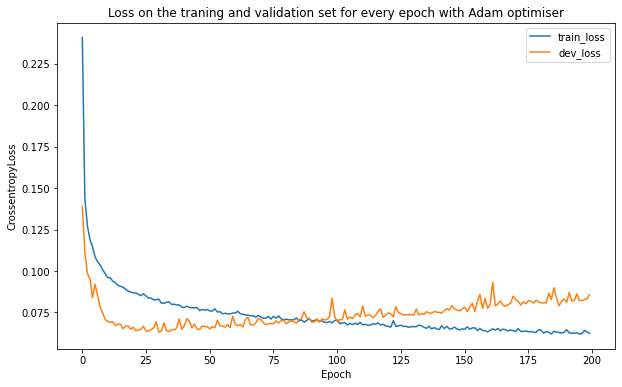

In [14]:
# Plot loss curve
fig = plt.figure(figsize = (10, 6))
plt.plot(train_loss_list)
plt.plot(dev_loss_list)
plt.legend(['train_loss', 'dev_loss'])
plt.title('Loss on the traning and validation set for every epoch with Adam optimiser')
plt.xlabel('Epoch')
plt.ylabel('CrossentropyLoss')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
def test_accu(model, imgs, label):
    dataset = MyDataset(imgs, label)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

    y_hat3_list = []
    for X, y in dataloader:
        with torch.no_grad():
            #Accuracy Check
            y_hat3 = model(X)
            y_hat3 = torch.softmax(y_hat3, dim = 1)
            y_hat3_list.append(y_hat3)

    y_hat3_list = torch.cat(y_hat3_list, dim = 0)
    y_prediction = torch.argmax(y_hat3_list, dim = 1).numpy()
    accuracy = accuracy_score(label, y_prediction)
    return accuracy, y_prediction

train_accuracy, train_preds = test_accu(model, train_imgs, train_label)
validation_accuracy, validation_preds = test_accu(model, dev_imgs, dev_label)
test_accuracy, test_preds = test_accu(model, test_imgs, test_label)

In [16]:
print(train_accuracy)
print(validation_accuracy)
print(test_accuracy)

0.9808333333333333
0.969
0.504


In [17]:
print(train_label)
print(train_preds)
print(dev_label)
print(validation_preds)
print(test_label)
print(test_preds)

[0 0 1 ... 1 1 1]
[0 0 1 ... 0 1 1]
[1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1
 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1
 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1
 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1
 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1
 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0
 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1
 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1
 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0

In [18]:
from sklearn.metrics import confusion_matrix                      

print(confusion_matrix(train_label, train_preds))
print("Accuracy is ", accuracy_score(train_label, train_preds))

print(confusion_matrix(dev_label, validation_preds))
print("Accuracy is ", accuracy_score(dev_label, validation_preds))

print(confusion_matrix(test_label, test_preds))
print("Accuracy is ", accuracy_score(test_label, test_preds))

[[5929   71]
 [ 159 5841]]
Accuracy is  0.9808333333333333
[[486   9]
 [ 22 483]]
Accuracy is  0.969
[[266 242]
 [254 238]]
Accuracy is  0.504
